In [26]:
import numpy as np
import pptk
import networkx as nx
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from math import *
from PIL import Image 

In [27]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [28]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points

def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000,  maxNeighborDis:int=10):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data, maxNeighborDis)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

In [29]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [30]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [31]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        orientation: 0, 1, or 2. 0 stands for coronal. 1 stands for transverse. 2 stands for sagittal.
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def ReadPointFromPNG(pngPath, orientation:int, padding:int):
    
    path_list = [im_path for im_path in glob.glob(pngPath)]
    path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    imageData = []

    for path in path_list_parsed_valid:
        s = "\\"
        path = [f for f in path if f != '']
        s = s.join(path)
        s = s[:-4] + '.png'
        imageArray = np.array(Image.open(s))
        
        for i in range(padding):
            imageData.append(imageArray)
    
    
    # Transfrom the matrix to list of points' coordinate whose grey scalse is not 0 (colon area)
    if(orientation == 0):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [1, 2, 0]]
        #xyz[:, 2] = xyz[:, 2]*3*thickness
        
    elif(orientation == 1):
        yxz = np.transpose(np.where(imageData))
        xyz = yxz[:, [1, 0, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
        
    elif(orientation == 2):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [0, 1, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
    
    else:
        print("Orientation shoud only be one of 0, 1 or 2 only.  0 stands for coronal. \
        1 stands for transverse. 2 stands for sagittal.")
        
    print("Done!")
    return xyz

In [32]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# return: a tuple(closestIndices, closesDis). ClosestIndices is a matrix of each point's neighbors. 
#         closestDis is a matrix of the distances between each point and their neighbors

def getNearbyPoints(pointsData, maxNeighborDis):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = maxNeighborDis # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [33]:
# This function converts points' coordinate data into a minimum spanning tree. In this graph, the nodes are the points
# from the points cloud and the edges are the connection between each point and their neighbors. The weights are each 
# connection's distance in space
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# Return: A networkX instance containing the MST

def CreateMSTGraph(pointsData, maxNeighborDis):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData, maxNeighborDis)
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    print("---------------")
    print("Nearby points calculation Done! Total:", closestIndicies.shape[0], "points,",\
          closestIndicies.shape[1]*closestIndicies.shape[0],"edges.")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    
    grid = np.indices(closestIndicies.shape)
    VEStack = np.stack((grid[0], closestIndicies, closestDis), axis=-1)
    VEList = VEStack.reshape(VEStack.shape[0]*VEStack.shape[1], 3).tolist()
    VETupleList = [(int(x[0]), int(x[1]), x[2]) for x in VEList]
    
    G.add_weighted_edges_from(VETupleList)
    
    '''
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    '''     
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [34]:
# Impliment the collect algorithm for 3D points in the paper. This is a recursive function which may not be efficient 
# enough for the project. The non-Recursive version is right below.

def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [35]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    global weight_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [36]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsLite(PStar: int, H:int, H_outer:int):
    
    global graph_base
    global pointsCor3D_base
    
    toExplore = [PStar]
    explored = []
    A = [PStar]
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        explored.append(curP)
        
        for Pj in graph_base.neighbors(curP):
            PjCurDist = distance.euclidean(pointsCor3D_base[Pj], pointsCor3D_base[PStar])
            
            if (Pj) not in A and PjCurDist < H:                     
                toExplore.append(Pj)
                A.append(Pj)
            elif (Pj) not in A and (Pj) not in explored and PjCurDist < H_outer:
                toExplore.append(Pj)    
        
    return np.asarray(pointsCor3D_base[A])

In [37]:
# Calculate the weight between any tew points. This weight is used to calculate regression plane
# Params: P1: the index of the first point
#         P2: the index of the second point
# Return: the weight between the two points

def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [38]:
# Calculate the regression plane for a specific point given its neighbors. 
# Params: PStar: the index of the point for which we want to find the gression plane.
#         A: A set of points' indicies representing PStar's neighbors
# Return: fitted_params: the regression plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0

def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    
    # The following code is used for a dynamic programming version. But currently there is no perfermance improvement 
    # using this technique. Need to explore further
    # global curScalar
    # global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c, d = params 
        loss = sum(((a * xMatrix + b*yMatrix + c*zMatrix + d)**2)*wM)
        
        # Dynamic programming version
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [39]:
# This function projects a list of points to a plane specified using 'params' and return their coordinate after the
# projection in 3D
# Param: params: a plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0
#        A: a list of points (points' indices) that need to be projected

def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c, d = params
    normal = np.asarray([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    if(a != 0):
        pointOnPlane = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        pointOnPlane = np.asarray([0, -d/b, 0])
    else:
        pointOnPlane = np.asarray([0, 0, -d/c])
        
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [40]:
# This function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )

def convertTo2DCor(pointsCor, planeParam):
    a, b, c, d = planeParam
    
    if(a != 0):
        origin = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        origin = np.asarray([0, -d/b, 0])
    else:
        origin = np.asarray([0, 0, -d/c])
    
    if( a == 0 and b !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([0, -d/b , 0])
        u = u / np.linalg.norm(u)
    elif( b == 0 and a !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif( c == 0 and a !=0 and b != 0):
        u = np.array([0, -d/b, 0]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif(a == 0 and b == 0):
        u = np.array([1, 0, 0])
    elif(a == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(b == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(a == 0 or b == 0 or c == 0):
        print("plane parameter error! a =", a, "b =", b, "c =", c, "d =", d)
    else:
        u = np.array([0, 0, -d/c]) - np.array([1, 1, (-d - a - b)/c])
        u = u / np.linalg.norm(u)
    
    normal = np.array([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [41]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [42]:
def getNeighborsCor(targetPoint):

    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

In [43]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [44]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [45]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [46]:
# This function is used to reconstruct the end point of the centerline after cleaning

def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    for grandChild in removedNodeDict[child]:
        if(graph_centerline.has_node(grandChild)):
            deleteChild(grandChild)
        

In [47]:
# This function is used to reconstruct the end point of the centerline after cleaning

def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(child, curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(child, curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(parent, child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [48]:
# This function is used for visulize the centerline in VPython

def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [49]:
def getMoveVec(targetPointCor, neighborsCor):
    totalVec = neighborsCor - targetPointCor
    averageVec = np.sum(totalVec, axis=0)/len(totalVec)
    return averageVec

Done!
---------------
There are 562443 points in total. Now sampleling 7000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done! Total: 7000 points, 168000 edges.
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


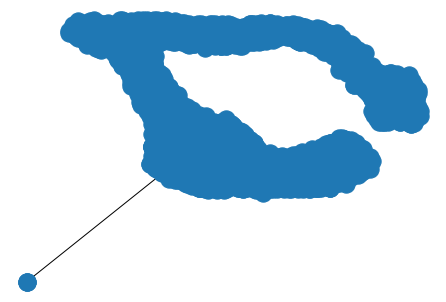

In [54]:
filePath = ".\\New_820_Lava_Cor_pre_mask\*.png"
pointData = ReadPointFromPNG(filePath, 0, 1)
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=True, sampleNumber=7000, maxNeighborDis=25)

if(not nx.is_connected(graph)):
    raise Exception('the raw centerline points cannot form a connected MST, raise maxNeighborDis and try again!')

In [55]:
displayPoints(pointsCor3D, 0.5)

In [56]:
pointsCor3D_base = copy.deepcopy(pointsCor3D)
pointsCor3D_moved = copy.deepcopy(pointsCor3D)
graph_base = copy.deepcopy(graph)

0 trial: 1 397
[0.05289673 3.27707809 4.11335013]
Moved! 5.259438002445489 > 4.4
1 trial: 1 235
[3.25531915 1.15319149 2.86808511]
Moved! 4.489194309675471 > 4.4
2 trial: 1 192
[-1.1875     -0.76041667  0.02083333]
Not Moved! 1.4102566378933383 < 4.4
3 trial: 1 210
[-1.81428571 -2.4952381   1.36666667]
Not Moved! 3.374258967946361 < 4.4
4 trial: 1 101
[ 0.7029703   5.55445545 -1.63366337]
Moved! 5.83223786633878 > 4.4
5 trial: 1 461
[1.06073753 4.52928416 2.38394794]
Moved! 5.227120328114351 > 4.4
6 trial: 1 298
[-4.01342282  0.15771812  3.44295302]
Moved! 5.290213911259324 > 4.4
7 trial: 1 476
[2.3697479  0.37605042 1.15966387]
Not Moved! 2.664946398172732 < 4.4
8 trial: 1 376
[-0.54787234  5.96010638 -0.96542553]
Moved! 6.062596692466044 > 4.4
9 trial: 1 610
[0.08360656 1.85081967 1.11639344]
Not Moved! 2.163066765940343 < 4.4
10 trial: 1 269
[-3.89962825 -1.18215613  1.21189591]
Not Moved! 4.251268673379704 < 4.4
11 trial: 1 136
[ 6.14705882 -1.75       -0.40441176]
Moved! 6.4040909

99 trial: 1 206
[1.0776699  4.01456311 0.60679612]
Not Moved! 4.200748848133813 < 4.4
100 trial: 1 199
[-1.54271357 -2.47236181 -2.88442211]
Not Moved! 4.100296206259516 < 4.4
101 trial: 1 472
[0.34322034 1.28389831 2.69491525]
Not Moved! 3.0047900569610433 < 4.4
102 trial: 1 328
[ 1.95731707  4.56097561 -2.92073171]
Moved! 5.75884210096465 > 4.4
103 trial: 1 236
[5.46610169 2.63559322 0.51271186]
Moved! 6.089950149069835 > 4.4
104 trial: 1 677
[0.01329394 0.09601182 0.43426883]
Not Moved! 0.44495439913233603 < 4.4
105 trial: 1 243
[-1.39506173 -5.08641975  3.58024691]
Moved! 6.374639683372012 > 4.4
106 trial: 1 229
[4.2139738  1.85152838 7.0349345 ]
Moved! 8.406904063095306 > 4.4
107 trial: 1 380
[-1.07631579  0.33947368  3.82631579]
Not Moved! 3.9892844698914933 < 4.4
108 trial: 1 426
[-1.03286385 -5.35446009 -0.08450704]
Moved! 5.453823619212007 > 4.4
109 trial: 1 141
[ 2.85815603 -3.12765957  6.21985816]
Moved! 7.525818611777418 > 4.4
110 trial: 1 384
[ 2.35416667 -0.12239583  4.68

197 trial: 1 178
[-3.33146067 -8.19101124 -0.35393258]
Moved! 8.849664601848277 > 4.4
198 trial: 1 312
[-0.03846154 -6.21474359  0.55448718]
Moved! 6.239549119000147 > 4.4
199 trial: 1 347
[-0.59942363 -3.1037464  -0.95100865]
Not Moved! 3.30105556369933 < 4.4
200 trial: 1 282
[0.20921986 3.88652482 2.0106383 ]
Not Moved! 4.380812083545981 < 4.4
201 trial: 1 372
[-0.18010753 -2.06451613  3.46505376]
Not Moved! 4.037482278822962 < 4.4
202 trial: 1 325
[-0.49846154  7.08307692 -0.76307692]
Moved! 7.14147946815524 > 4.4
203 trial: 1 531
[0.88323917 1.79096045 1.29001883]
Not Moved! 2.3773513333798935 < 4.4
204 trial: 1 291
[ 3.74570447  1.42268041 -1.4742268 ]
Not Moved! 4.269387096820417 < 4.4
205 trial: 1 329
[ 0.06990881 -3.83586626  3.38905775]
Moved! 5.119030147955349 > 4.4
206 trial: 1 278
[4.34532374 1.03956835 3.54676259]
Moved! 5.704565332089122 > 4.4
207 trial: 1 562
[-0.2366548   0.97864769  2.30960854]
Not Moved! 2.5195333702180456 < 4.4
208 trial: 1 284
[ 0.66197183 -0.454225

291 trial: 1 403
[ 1.74689826 -0.39950372  4.01985112]
Moved! 4.401188449176064 > 4.4
292 trial: 1 166
[ 2.39759036 -0.93373494 -8.54216867]
Moved! 8.921263707907636 > 4.4
293 trial: 1 482
[-1.6846473  -3.74273859 -0.98755187]
Not Moved! 4.221538507796292 < 4.4
294 trial: 1 246
[ 0.11788618 -1.40243902  4.7398374 ]
Moved! 4.944369619205663 > 4.4
295 trial: 1 458
[0.34279476 4.29475983 1.91484716]
Moved! 4.714775695278774 > 4.4
296 trial: 1 298
[ 4.77181208  2.20134228 -1.54362416]
Moved! 5.4771227779371525 > 4.4
297 trial: 1 305
[ 0.47540984 -5.26885246 -3.84590164]
Moved! 6.5404724727363455 > 4.4
298 trial: 1 326
[-3.45092025 -4.65030675 -4.14417178]
Moved! 7.120980489368264 > 4.4
299 trial: 1 490
[ 1.38163265 -0.91428571  1.14285714]
Not Moved! 2.0126970970147315 < 4.4
300 trial: 1 202
[5.50990099 2.23762376 0.9009901 ]
Moved! 6.014794442136714 > 4.4
301 trial: 1 250
[-4.3   -2.668 -5.964]
Moved! 7.821605973200134 > 4.4
302 trial: 1 290
[2.69655172 2.96896552 4.9       ]
Moved! 6.332

389 trial: 1 272
[ 3.40441176  3.53308824 -1.87132353]
Moved! 5.251150701872079 > 4.4
390 trial: 1 253
[1.96047431 4.64426877 5.44268775]
Moved! 7.418594332953081 > 4.4
391 trial: 1 173
[-1.8265896   3.86127168  4.16184971]
Moved! 5.963794222216454 > 4.4
392 trial: 1 252
[ 3.65873016  3.36111111 -1.75396825]
Moved! 5.2687549678804215 > 4.4
393 trial: 1 257
[-0.02723735  2.86381323 -6.9922179 ]
Moved! 7.556009478030402 > 4.4
394 trial: 1 300
[ 1.90333333 -2.75333333  5.67333333]
Moved! 6.587126333488172 > 4.4
395 trial: 1 127
[ 7.96850394  0.77952756 -1.84251969]
Moved! 8.215813836692869 > 4.4
396 trial: 1 298
[-0.04697987 -4.8557047   5.02348993]
Moved! 6.986810883918563 > 4.4
397 trial: 1 343
[ 1.76676385 -4.72886297  2.52769679]
Moved! 5.645604537865288 > 4.4
398 trial: 1 416
[-0.08413462  0.58894231 -4.24038462]
Not Moved! 4.281914684073748 < 4.4
399 trial: 1 274
[-4.66423358  0.56934307  4.38686131]
Moved! 6.428357377359165 > 4.4
400 trial: 1 500
[-1.658  0.102 -2.718]
Not Moved! 3

489 trial: 1 77
[ 1.33766234 -8.2987013   1.16883117]
Moved! 8.486692528653204 > 4.4
490 trial: 1 599
[ 0.38397329 -1.64440735 -1.35392321]
Not Moved! 2.1643980804536724 < 4.4
491 trial: 1 478
[0.34518828 2.15481172 3.27615063]
Not Moved! 3.9364363853321107 < 4.4
492 trial: 1 274
[ 0.30291971 -4.76277372  5.43065693]
Moved! 7.22964789049908 > 4.4
493 trial: 1 448
[ 2.59598214  2.20758929 -0.69866071]
Not Moved! 3.478606119427708 < 4.4
494 trial: 1 449
[1.86859688 2.30289532 3.42316258]
Moved! 4.5291305179794294 > 4.4
495 trial: 1 203
[1.99507389 3.33004926 2.99014778]
Moved! 4.900054252758109 > 4.4
496 trial: 1 365
[ 0.45479452 -1.90136986  3.30410959]
Not Moved! 3.839164699292085 < 4.4
497 trial: 1 378
[ 0.44708995 -0.18783069  5.18253968]
Moved! 5.205178896942771 > 4.4
498 trial: 1 159
[ 4.5408805   4.91194969 -4.52201258]
Moved! 8.074369524503268 > 4.4
499 trial: 1 90
[-7.95555556 -1.24444444 -3.87777778]
Moved! 8.937374707746491 > 4.4
500 trial: 1 277
[ 3.46931408  2.85920578 -4.84

590 trial: 1 205
[-1.80487805 -3.52682927 -2.91707317]
Moved! 4.919900948399094 > 4.4
591 trial: 1 207
[-2.06763285 -6.21256039  0.41545894]
Moved! 6.560763544548349 > 4.4
592 trial: 1 247
[-3.16194332 -5.53846154 -1.43724696]
Moved! 6.5374399121641344 > 4.4
593 trial: 1 206
[ 0.31067961  4.54368932 -1.97087379]
Moved! 4.962456845480444 > 4.4
594 trial: 1 429
[-0.41025641 -3.2027972   2.44988345]
Not Moved! 4.0531653263116345 < 4.4
595 trial: 1 423
[2.04018913 0.00472813 2.31678487]
Not Moved! 3.0870513691808408 < 4.4
596 trial: 1 198
[-1.78787879  0.94444444 -3.36363636]
Not Moved! 3.924606407726227 < 4.4
597 trial: 1 157
[ 0.19745223  5.25477707 -7.2611465 ]
Moved! 8.965261729985098 > 4.4
598 trial: 1 439
[3.35990888 0.53758542 1.738041  ]
Not Moved! 3.8208339820689683 < 4.4
599 trial: 1 283
[-1.56890459  0.10600707  4.32155477]
Moved! 4.598753608868925 > 4.4
600 trial: 1 226
[-4.41150442 -4.45575221 -5.55309735]
Moved! 8.375678431779468 > 4.4
601 trial: 1 108
[-4.71296296 -3.25     

685 trial: 1 595
[-0.54957983 -0.93109244 -0.25882353]
Not Moved! 1.111737710629657 < 4.4
686 trial: 1 366
[-0.31967213 -5.28415301 -1.19945355]
Moved! 5.427997059670114 > 4.4
687 trial: 1 298
[-3.66107383  4.39932886 -2.19798658]
Moved! 6.130962482303757 > 4.4
688 trial: 1 300
[-1.70666667 -2.29333333  1.34666667]
Not Moved! 3.16 < 4.4
689 trial: 1 254
[-3.07086614 -2.7519685  -1.74409449]
Moved! 4.4772106373087 > 4.4
690 trial: 1 577
[ 0.305026   -1.85441941 -1.05199307]
Not Moved! 2.1537413084606127 < 4.4
691 trial: 1 177
[-3.70056497 -3.55367232 -0.55367232]
Moved! 5.160360556813745 > 4.4
692 trial: 1 250
[-6.708 -0.608 -0.6  ]
Moved! 6.762168882836335 > 4.4
693 trial: 1 196
[5.17857143 1.79591837 5.78061224]
Moved! 7.966078254000186 > 4.4
694 trial: 1 499
[1.14028056 2.56513026 2.25250501]
Not Moved! 3.599154321737176 < 4.4
695 trial: 1 131
[-7.58015267 -2.65648855 -0.12977099]
Moved! 8.033211465649243 > 4.4
696 trial: 1 296
[ 2.41554054 -3.31756757  2.79391892]
Moved! 4.964581915

784 trial: 1 453
[-1.17218543 -2.54304636  1.09713024]
Not Moved! 3.0074571036171274 < 4.4
785 trial: 1 300
[ 0.14  7.44 -0.33]
Moved! 7.448630746654046 > 4.4
786 trial: 1 493
[-0.26774848  1.38742394  3.06085193]
Not Moved! 3.371268150473102 < 4.4
787 trial: 1 471
[-0.48619958  4.69214437 -1.5329087 ]
Moved! 4.960082453749108 > 4.4
788 trial: 1 303
[-4.01650165  1.92079208 -5.51815182]
Moved! 7.090255790358856 > 4.4
789 trial: 1 445
[-0.21573034  4.92808989 -0.11910112]
Moved! 4.934247115481939 > 4.4
790 trial: 1 644
[-0.08229814 -1.8136646  -0.4984472 ]
Not Moved! 1.8827113074531405 < 4.4
791 trial: 1 480
[0.00416667 0.95625    3.87916667]
Not Moved! 3.9952929118387415 < 4.4
792 trial: 1 205
[0.8097561  1.95609756 6.67317073]
Moved! 7.000944951940922 > 4.4
793 trial: 1 403
[ 0.13399504 -4.29032258 -2.85856079]
Moved! 5.157149632233182 > 4.4
794 trial: 1 247
[-2.82591093 -2.41295547  2.03643725]
Not Moved! 4.237358060237078 < 4.4
795 trial: 1 207
[0.98067633 0.61835749 4.73913043]
Mov

881 trial: 1 283
[-3.29328622  0.64664311  5.33215548]
Moved! 6.300457401105673 > 4.4
882 trial: 1 375
[-0.58666667 -6.13333333 -2.09866667]
Moved! 6.5089444100663005 > 4.4
883 trial: 1 302
[-1.6589404  -1.          1.59271523]
Not Moved! 2.5077529885403043 < 4.4
884 trial: 1 252
[-0.75793651  1.39285714 -0.36904762]
Not Moved! 1.6281016293818602 < 4.4
885 trial: 1 247
[-0.94736842  6.77327935  1.10526316]
Moved! 6.927945348854018 > 4.4
886 trial: 1 394
[0.64974619 0.34010152 2.91370558]
Not Moved! 3.0045830642257596 < 4.4
887 trial: 1 411
[ 0.52311436 -3.4622871  -2.40632603]
Not Moved! 4.248703991301034 < 4.4
888 trial: 1 185
[-2.82162162 -4.07567568 -3.91891892]
Moved! 6.3190668838015664 > 4.4
889 trial: 1 495
[-1.86262626 -2.56969697 -2.61212121]
Not Moved! 4.110461815551686 < 4.4
890 trial: 1 347
[-0.71181556 -5.57348703  1.23342939]
Moved! 5.752546145731227 > 4.4
891 trial: 1 447
[-2.46532438 -3.53914989 -3.00447427]
Moved! 5.25645050482488 > 4.4
892 trial: 1 242
[4.79338843 3.11

981 trial: 1 192
[-5.84375    -3.09895833  4.05208333]
Moved! 7.75708296684481 > 4.4
982 trial: 1 307
[-4.09120521 -3.03908795  2.70684039]
Moved! 5.770701910610164 > 4.4
983 trial: 1 385
[1.15844156 4.64415584 3.28831169]
Moved! 5.8071648942163385 > 4.4
984 trial: 1 321
[-3.40186916  3.58878505 -5.50778816]
Moved! 7.401879647978134 > 4.4
985 trial: 1 205
[-4.6195122   0.12195122 -4.23902439]
Moved! 6.270892504413038 > 4.4
986 trial: 1 282
[ 0.45390071 -4.65602837  5.5106383 ]
Moved! 7.228537920964737 > 4.4
987 trial: 1 180
[-0.68888889 -0.07777778 -3.71111111]
Not Moved! 3.7753096512687487 < 4.4
988 trial: 1 191
[ 3.83769634  4.55497382 -3.88481675]
Moved! 7.111082961889468 > 4.4
989 trial: 1 300
[-2.94       -1.51666667 -1.19      ]
Not Moved! 3.515676005802835 < 4.4
990 trial: 1 205
[ 7.8097561  -1.0195122  -2.02926829]
Moved! 8.133241987244785 > 4.4
991 trial: 1 290
[-4.57931034  3.6862069  -2.46206897]
Moved! 6.373381214817892 > 4.4
992 trial: 1 141
[6.34042553 3.78014184 1.049645

1081 trial: 1 588
[ 0.03911565 -2.78061224 -1.10714286]
Not Moved! 2.993175537181396 < 4.4
1082 trial: 1 275
[-2.17818182 -5.62181818  1.75636364]
Moved! 6.279659937100084 > 4.4
1083 trial: 1 284
[0.33098592 2.82746479 3.53521127]
Moved! 4.538923607462684 > 4.4
1084 trial: 1 477
[-1.1572327  -0.55555556  2.93291405]
Not Moved! 3.201533118583148 < 4.4
1085 trial: 1 229
[-5.46724891 -2.68995633  4.78165939]
Moved! 7.745381991981571 > 4.4
1086 trial: 1 431
[-0.67285383 -0.20649652 -3.48955916]
Not Moved! 3.55983093012812 < 4.4
1087 trial: 1 242
[-0.87190083 -5.21487603  1.26446281]
Moved! 5.436359930043539 > 4.4
1088 trial: 1 126
[ 6.46031746 -0.52380952  5.1984127 ]
Moved! 8.308644455525497 > 4.4
1089 trial: 1 222
[-2.5045045  -2.97297297  7.38738739]
Moved! 8.34773044140989 > 4.4
1090 trial: 1 492
[-0.22154472 -2.23780488 -1.36788618]
Not Moved! 2.6321028345189297 < 4.4
1091 trial: 1 197
[ 0.95431472 -2.26395939  8.11675127]
Moved! 8.480441018792906 > 4.4
1092 trial: 1 279
[-0.13620072 

1177 trial: 1 374
[-0.44652406  4.02673797 -4.70320856]
Moved! 6.207589961069243 > 4.4
1178 trial: 1 592
[-1.10135135 -1.85641892 -0.50337838]
Not Moved! 2.2164511710079204 < 4.4
1179 trial: 1 342
[ 2.64912281 -2.93567251  0.86549708]
Not Moved! 4.047852510697515 < 4.4
1180 trial: 1 248
[4.08870968 0.15322581 4.20967742]
Moved! 5.87046922732855 > 4.4
1181 trial: 1 246
[-0.31300813 -4.1504065  -4.75609756]
Moved! 6.32015128363242 > 4.4
1182 trial: 1 377
[-0.62334218 -4.49071618 -3.03713528]
Moved! 5.457039305325129 > 4.4
1183 trial: 1 505
[-1.80990099 -2.77425743 -1.92871287]
Not Moved! 3.833037855033241 < 4.4
1184 trial: 1 211
[ 3.14691943  3.03791469 -3.22748815]
Moved! 5.435872271456247 > 4.4
1185 trial: 1 406
[0.87931034 4.8817734  2.27832512]
Moved! 5.458540424750734 > 4.4
1186 trial: 1 236
[ 1.16101695 -5.05508475 -4.93220339]
Moved! 7.157406822426534 > 4.4
1187 trial: 1 581
[ 0.16695353 -2.7383821  -0.86919105]
Not Moved! 2.877864327336027 < 4.4
1188 trial: 1 215
[-1.8         1.

Moved! 6.8292251948053115 > 4.4
1274 trial: 1 182
[2.11538462 0.01098901 5.16483516]
Moved! 5.581262859719682 > 4.4
1275 trial: 1 296
[ 4.47297297 -0.42567568  1.45945946]
Moved! 4.724268082106932 > 4.4
1276 trial: 1 217
[0.01382488 6.56221198 2.29032258]
Moved! 6.950424069211301 > 4.4
1277 trial: 1 281
[3.98220641 5.47330961 2.6227758 ]
Moved! 7.259065974992614 > 4.4
1278 trial: 1 278
[5.56115108 3.28417266 2.1618705 ]
Moved! 6.810717691424601 > 4.4
1279 trial: 1 375
[-3.          1.496       3.33066667]
Moved! 4.725606463137239 > 4.4
1280 trial: 1 210
[ 1.78095238  0.66190476 -4.81428571]
Moved! 5.175640659457306 > 4.4
1281 trial: 1 277
[-0.63176895  1.38267148  2.38267148]
Not Moved! 2.826311344201065 < 4.4
1282 trial: 1 360
[ 0.29444444 -4.24166667 -3.18333333]
Moved! 5.311501176982493 > 4.4
1283 trial: 1 286
[-3.38461538 -1.97202797 -0.84965035]
Not Moved! 4.00829406866523 < 4.4
1284 trial: 1 433
[-1.36489607 -0.34411085 -0.72286374]
Not Moved! 1.5823670753925154 < 4.4
1285 trial:

1371 trial: 1 262
[ 0.25572519  5.39312977 -2.30916031]
Moved! 5.872262376271032 > 4.4
1372 trial: 1 153
[-0.13071895 -8.35947712  1.95424837]
Moved! 8.585862327734096 > 4.4
1373 trial: 1 202
[-3.54455446  4.69306931  4.90594059]
Moved! 7.6587870397154765 > 4.4
1374 trial: 1 188
[-0.89893617  3.39361702 -2.21276596]
Not Moved! 4.149826009322623 < 4.4
1375 trial: 1 294
[-0.97959184 -5.82653061 -4.05782313]
Moved! 7.167564976358025 > 4.4
1376 trial: 1 480
[ 0.98333333  1.68333333 -1.4375    ]
Not Moved! 2.4221812082409433 < 4.4
1377 trial: 1 296
[ 0.85472973 -2.7972973   5.63175676]
Moved! 6.346031771715771 > 4.4
1378 trial: 1 247
[-1.1417004  -4.09716599  0.38866397]
Not Moved! 4.270984507040282 < 4.4
1379 trial: 1 192
[ 4.71875    -4.83333333  3.921875  ]
Moved! 7.810814054196663 > 4.4
1380 trial: 1 239
[ 4.06276151  3.92887029 -0.29707113]
Moved! 5.659532144207234 > 4.4
1381 trial: 1 204
[-5.31862745 -4.2254902   3.39215686]
Moved! 7.592713187059405 > 4.4
1382 trial: 1 231
[ 2.7445887

1465 trial: 1 362
[1.00828729 2.33149171 5.03314917]
Moved! 5.637826482922563 > 4.4
1466 trial: 1 189
[-6.55555556 -3.86772487  1.84126984]
Moved! 7.831020298962486 > 4.4
1467 trial: 1 179
[0.33519553 4.36871508 3.72625698]
Moved! 5.751783952164516 > 4.4
1468 trial: 1 129
[-0.31007752  6.79069767  7.55813953]
Moved! 10.165392083050772 > 4.4
1469 trial: 1 211
[-1.2985782   2.63507109 -1.99052133]
Not Moved! 3.5485321108812697 < 4.4
1470 trial: 1 188
[-2.40957447 -8.65957447  1.11170213]
Moved! 9.05705033143804 > 4.4
1471 trial: 1 449
[-1.31625835 -5.00668151 -0.28730512]
Moved! 5.184779654888114 > 4.4
1472 trial: 1 451
[0.09534368 4.81596452 0.49889135]
Moved! 4.842674600735346 > 4.4
1473 trial: 1 211
[-3.95260664 -3.08530806 -4.27962085]
Moved! 6.592221147953819 > 4.4
1474 trial: 1 284
[6.01056338 3.1056338  3.29225352]
Moved! 7.524012673630592 > 4.4
1475 trial: 1 222
[-1.98648649  0.54054054 -8.23423423]
Moved! 8.487692622921516 > 4.4
1476 trial: 1 301
[ 0.2358804  -1.46511628  1.5049

1566 trial: 1 416
[-2.60817308 -3.5625     -3.13221154]
Moved! 5.413383615711894 > 4.4
1567 trial: 1 303
[ 2.57755776 -0.6369637  -4.84488449]
Moved! 5.52471107310273 > 4.4
1568 trial: 1 235
[ 0.11914894 -0.79148936  1.36170213]
Not Moved! 1.5795203585743194 < 4.4
1569 trial: 1 287
[ 0.13240418 -3.54355401 -3.88501742]
Moved! 5.260006295971124 > 4.4
1570 trial: 1 579
[-0.88946459 -2.54058722 -0.92918826]
Not Moved! 2.8476519270565426 < 4.4
1571 trial: 1 201
[-1.52736318  0.67661692 -0.6119403 ]
Not Moved! 1.7790783218440842 < 4.4
1572 trial: 1 461
[ 0.19305857 -0.26898048  3.31019523]
Not Moved! 3.3267122739810024 < 4.4
1573 trial: 1 465
[-1.38494624  1.28172043 -0.17419355]
Not Moved! 1.895053226538515 < 4.4
1574 trial: 1 104
[-6.72115385 -4.375      -3.91346154]
Moved! 8.923548354588908 > 4.4
1575 trial: 1 198
[0.77777778 3.98989899 1.02525253]
Not Moved! 4.192299483784359 < 4.4
1576 trial: 1 351
[ 1.66096866 -2.25071225  5.42735043]
Moved! 6.105788662366812 > 4.4
1577 trial: 1 234
[

1662 trial: 1 546
[-0.17582418 -0.62087912  0.31684982]
Not Moved! 0.7188872164572432 < 4.4
1663 trial: 1 223
[-0.01345291 -3.72197309  2.7264574 ]
Moved! 4.613765776864841 > 4.4
1664 trial: 1 241
[-5.07053942  1.29460581 -5.26970954]
Moved! 7.426722889345116 > 4.4
1665 trial: 1 368
[-1.26902174 -4.25543478 -1.71195652]
Moved! 4.75919494197776 > 4.4
1666 trial: 1 254
[ 1.36614173 -3.42519685 -2.36614173]
Not Moved! 4.381431660300864 < 4.4
1667 trial: 1 353
[-3.9631728  -2.63739377  2.26062323]
Moved! 5.2700096726761245 > 4.4
1668 trial: 1 378
[0.55820106 1.25925926 5.30952381]
Moved! 5.48528626302285 > 4.4
1669 trial: 1 394
[ 1.58629442  2.92385787 -0.84263959]
Not Moved! 3.431518074061761 < 4.4
1670 trial: 1 246
[0.1300813  6.58130081 2.43902439]
Moved! 7.01992033518382 > 4.4
1671 trial: 1 465
[ 0.56129032 -2.92043011 -1.12043011]
Not Moved! 3.1779431185949285 < 4.4
1672 trial: 1 309
[ 0.55339806  6.23624595 -3.65372168]
Moved! 7.2489099286727035 > 4.4
1673 trial: 1 271
[-1.099631   -

1762 trial: 1 421
[ 2.86223278 -0.14251781  1.77434679]
Not Moved! 3.3706074159300345 < 4.4
1763 trial: 1 461
[-2.09761388 -1.          1.68980477]
Not Moved! 2.873225394891035 < 4.4
1764 trial: 1 237
[ 3.97890295  3.38396624 -0.26160338]
Moved! 5.229850149439266 > 4.4
1765 trial: 1 190
[-1.35263158 -3.63157895  1.57894737]
Not Moved! 4.184620966297778 < 4.4
1766 trial: 1 242
[ 4.69834711 -2.64876033  6.52892562]
Moved! 8.468604759944322 > 4.4
1767 trial: 1 389
[ 0.46272494  6.02827763 -0.22622108]
Moved! 6.050241448671438 > 4.4
1768 trial: 1 235
[-0.36170213  6.85957447  3.06382979]
Moved! 7.521412319338777 > 4.4
1769 trial: 1 275
[ 2.07636364 -1.65818182  6.90545455]
Moved! 7.39906449302213 > 4.4
1770 trial: 1 335
[2.5641791  2.34626866 3.91940299]
Moved! 5.238483640209385 > 4.4
1771 trial: 1 508
[-0.33267717  1.41929134  3.50984252]
Not Moved! 3.800533714245017 < 4.4
1772 trial: 1 439
[2.38724374 1.49886105 0.65375854]
Not Moved! 2.8935993720767192 < 4.4
1773 trial: 1 124
[-1.258064

1858 trial: 1 194
[ 1.32474227 -6.47938144 -1.56185567]
Moved! 6.795345399516882 > 4.4
1859 trial: 1 252
[-2.81746032 -4.84126984  4.02380952]
Moved! 6.896884760553328 > 4.4
1860 trial: 1 202
[-0.38613861  1.34158416 -2.98019802]
Not Moved! 3.2909772591828674 < 4.4
1861 trial: 1 525
[-0.88761905  3.79428571 -2.07428571]
Moved! 4.414423278279802 > 4.4
1862 trial: 1 486
[0.67695473 2.5781893  2.44650206]
Not Moved! 3.618107253320443 < 4.4
1863 trial: 1 210
[ 0.26190476 -0.64285714  0.17142857]
Not Moved! 0.7150155002046318 < 4.4
1864 trial: 1 345
[ 1.12173913 -0.42028986  5.72173913]
Moved! 5.8457883057611655 > 4.4
1865 trial: 1 468
[ 0.65598291 -0.91880342 -1.93803419]
Not Moved! 2.2428753441366203 < 4.4
1866 trial: 1 219
[6.57077626 2.69863014 0.69406393]
Moved! 7.13718641717476 > 4.4
1867 trial: 1 132
[-7.74242424  1.50757576  3.61363636]
Moved! 8.676190729986505 > 4.4
1868 trial: 1 387
[ 0.7002584  -1.12403101  2.95865633]
Not Moved! 3.241520447837172 < 4.4
1869 trial: 1 253
[-0.4664

1959 trial: 1 440
[-1.59090909  2.79090909 -2.20681818]
Not Moved! 3.8974622226340445 < 4.4
1960 trial: 1 405
[0.97037037 0.06666667 4.29876543]
Moved! 4.407430922923745 > 4.4
1961 trial: 1 531
[0.14689266 3.02259887 1.43502825]
Not Moved! 3.3491771311341476 < 4.4
1962 trial: 1 192
[ 3.14583333  2.078125   -7.50520833]
Moved! 8.398989403700437 > 4.4
1963 trial: 1 286
[ 0.86713287  0.68881119 -5.63286713]
Moved! 5.740694417893042 > 4.4
1964 trial: 1 232
[-0.09913793  3.00862069 -1.83189655]
Not Moved! 3.5238433222562198 < 4.4
1965 trial: 1 291
[0.58419244 4.59106529 3.58762887]
Moved! 5.855787069480208 > 4.4
1966 trial: 1 142
[7.05633803 4.13380282 2.40140845]
Moved! 8.523320634818326 > 4.4
1967 trial: 1 67
[-9.2238806  -0.02985075 -3.08955224]
Moved! 9.727599774422886 > 4.4
1968 trial: 1 116
[ 1.81034483 -3.98275862  6.97413793]
Moved! 8.232758620689655 > 4.4
1969 trial: 1 192
[1.27083333 4.25       0.5625    ]
Moved! 4.47145654246031 > 4.4
1970 trial: 1 346
[ 3.65028902  3.64739884 -2

2055 trial: 1 368
[-1.77717391  0.30163043  3.45380435]
Not Moved! 3.8959071484638588 < 4.4
2056 trial: 1 170
[ 3.75294118 -1.68823529 -6.36470588]
Moved! 7.579194340509489 > 4.4
2057 trial: 1 381
[-0.31496063  0.24146982 -4.80839895]
Moved! 4.824749561810897 > 4.4
2058 trial: 1 245
[ 0.59591837 -0.19183673  4.93877551]
Moved! 4.978295247723967 > 4.4
2059 trial: 1 162
[5.37654321 3.79012346 1.58024691]
Moved! 6.765311006395802 > 4.4
2060 trial: 1 548
[-0.10766423 -2.03467153 -2.16240876]
Not Moved! 2.9711094687515347 < 4.4
2061 trial: 1 457
[ 2.91684902 -0.89059081 -0.32603939]
Not Moved! 3.067158595577969 < 4.4
2062 trial: 1 169
[-2.66863905 -1.23668639 -4.68047337]
Moved! 5.527916299872468 > 4.4
2063 trial: 1 226
[-1.03097345 -6.41150442  3.30973451]
Moved! 7.288665021432865 > 4.4
2064 trial: 1 487
[ 0.14784394 -2.45379877 -0.56673511]
Not Moved! 2.522731637183693 < 4.4
2065 trial: 1 539
[-2.03896104 -1.72727273 -2.13358071]
Not Moved! 3.4195028611728233 < 4.4
2066 trial: 1 342
[2.61

2152 trial: 1 287
[ 5.40069686 -0.12543554  5.271777  ]
Moved! 7.548171531384436 > 4.4
2153 trial: 1 374
[ 1.71657754 -2.4197861  -0.31818182]
Not Moved! 2.983830235160554 < 4.4
2154 trial: 1 167
[-4.68862275 -2.13173653  4.85628743]
Moved! 7.078913158805827 > 4.4
2155 trial: 1 202
[-2.50990099 -0.33168317 -6.44554455]
Moved! 6.92493041898003 > 4.4
2156 trial: 1 176
[-0.07954545 -4.15340909 -5.625     ]
Moved! 6.992693297706194 > 4.4
2157 trial: 1 342
[-2.90350877 -3.86842105 -2.29824561]
Moved! 5.355088937781348 > 4.4
2158 trial: 1 258
[ 1.47674419  0.56976744 -4.58527132]
Moved! 4.85078564636038 > 4.4
2159 trial: 1 256
[3.73046875 0.421875   3.6796875 ]
Moved! 5.256850360054756 > 4.4
2160 trial: 1 283
[-0.18021201  0.99646643  0.40989399]
Not Moved! 1.0924444167923573 < 4.4
2161 trial: 1 219
[0.16894977 0.87671233 5.57077626]
Moved! 5.641871730545069 > 4.4
2162 trial: 1 309
[ 3.81553398  2.84142395 -3.42394822]
Moved! 5.8613489082448265 > 4.4
2163 trial: 1 429
[-1.00699301 -2.9463869

Moved! 4.7273817449881586 > 4.4
2248 trial: 1 253
[-0.49011858  0.4229249   1.30039526]
Not Moved! 1.452621601054223 < 4.4
2249 trial: 1 275
[-3.48       -1.94545455 -4.62909091]
Moved! 6.109310602110344 > 4.4
2250 trial: 1 303
[ 0.06930693 -0.55775578  3.61386139]
Not Moved! 3.6573062592645864 < 4.4
2251 trial: 1 439
[-1.66742597  2.58314351 -2.48974943]
Not Moved! 3.9562345694739673 < 4.4
2252 trial: 1 389
[0.79691517 4.23650386 4.15424165]
Moved! 5.986715489555102 > 4.4
2253 trial: 1 563
[ 0.24333925 -2.96092362 -0.80284192]
Not Moved! 3.0774726387388824 < 4.4
2254 trial: 1 155
[ 3.15483871 -6.42580645  4.41290323]
Moved! 8.409382302999553 > 4.4
2255 trial: 1 144
[-1.77777778  5.55555556  3.45833333]
Moved! 6.781206441516814 > 4.4
2256 trial: 1 410
[-0.43658537  2.45365854  1.70487805]
Not Moved! 3.0195456871935846 < 4.4
2257 trial: 1 231
[-1.85714286  2.84848485 -3.62337662]
Moved! 4.969074730643188 > 4.4
2258 trial: 1 267
[0.97378277 2.56179775 2.42322097]
Not Moved! 3.65828655250

2343 trial: 1 544
[-0.4375     -2.51654412 -1.44669118]
Not Moved! 2.935526512593928 < 4.4
2344 trial: 1 196
[5.75       1.13265306 3.35204082]
Moved! 6.751413229200257 > 4.4
2345 trial: 1 243
[-5.36625514 -1.71193416  1.89711934]
Moved! 5.943607879291073 > 4.4
2346 trial: 1 269
[-3.44237918  0.05576208  6.00743494]
Moved! 6.924042060296695 > 4.4
2347 trial: 1 389
[ 0.19280206  5.99228792 -0.77634961]
Moved! 6.045445049444322 > 4.4
2348 trial: 1 276
[1.32971014 2.64130435 6.51449275]
Moved! 7.1542458417625845 > 4.4
2349 trial: 1 340
[-0.05294118  4.36470588 -3.71470588]
Moved! 5.731710041514662 > 4.4
2350 trial: 1 169
[ 2.44970414 -3.47928994  4.36094675]
Moved! 6.092976726803458 > 4.4
2351 trial: 1 620
[-0.32419355 -1.96451613  0.2516129 ]
Not Moved! 2.006921555794701 < 4.4
2352 trial: 1 217
[ 1.29953917 -1.99078341 -4.79723502]
Moved! 5.354015736627901 > 4.4
2353 trial: 1 297
[-2.92592593 -2.51178451  0.3030303 ]
Not Moved! 3.8680655788392064 < 4.4
2354 trial: 1 207
[-3.352657   -0.2

2437 trial: 1 302
[-3.95695364 -0.0794702  -4.87417219]
Moved! 6.278642539090623 > 4.4
2438 trial: 1 645
[0.19689922 0.94883721 1.36434109]
Not Moved! 1.6734658500983 < 4.4
2439 trial: 1 185
[-2.20540541 -1.12972973 -0.00540541]
Not Moved! 2.477928869607476 < 4.4
2440 trial: 1 426
[-2.82394366 -1.35680751 -3.59859155]
Moved! 4.771314867891243 > 4.4
2441 trial: 1 233
[ 5.22317597 -2.61373391  4.16309013]
Moved! 7.1724815452964865 > 4.4
2442 trial: 1 236
[-3.77966102  3.47881356  5.70762712]
Moved! 7.678866355722642 > 4.4
2443 trial: 1 285
[-0.87017544 -5.39298246 -3.37894737]
Moved! 6.423297469737313 > 4.4
2444 trial: 1 641
[ 0.00624025 -1.07176287  0.60686427]
Not Moved! 1.2316650677355139 < 4.4
2445 trial: 1 278
[-0.54676259  1.57553957 -4.78776978]
Moved! 5.069912599582299 > 4.4
2446 trial: 1 276
[-3.85507246 -2.72826087  1.63405797]
Moved! 4.997513034094051 > 4.4
2447 trial: 1 188
[-0.19148936 -2.54255319 -4.83510638]
Moved! 5.466214287961955 > 4.4
2448 trial: 1 198
[4.86363636 4.74

2530 trial: 1 451
[ 0.55432373  4.86474501 -0.03769401]
Moved! 4.896370048688009 > 4.4
2531 trial: 1 250
[-2.096 -3.208  6.564]
Moved! 7.6006957576264025 > 4.4
2532 trial: 1 267
[-3.54307116 -5.50187266  2.8988764 ]
Moved! 7.157334728694607 > 4.4
2533 trial: 1 155
[ 5.6516129   6.03870968 -1.54193548]
Moved! 8.413341073110432 > 4.4
2534 trial: 1 190
[-1.55789474  4.71052632 -2.84736842]
Moved! 5.720454624243884 > 4.4
2535 trial: 1 475
[ 0.27789474 -4.41052632 -1.54736842]
Moved! 4.682340963397147 > 4.4
2536 trial: 1 200
[-0.885  0.785 -3.23 ]
Not Moved! 3.439818309155296 < 4.4
2537 trial: 1 280
[-0.58928571  3.60714286 -3.89642857]
Moved! 5.342367720135226 > 4.4
2538 trial: 1 546
[0.67399267 0.31318681 3.02564103]
Not Moved! 3.115582725685836 < 4.4
2539 trial: 1 239
[-3.51046025 -5.41004184 -4.42259414]
Moved! 7.819924733828155 > 4.4
2540 trial: 1 356
[0.98876404 1.69101124 2.11235955]
Not Moved! 2.8808394970129023 < 4.4
2541 trial: 1 465
[-0.56129032 -4.11827957 -1.86451613]
Moved! 4.

2631 trial: 1 531
[0.17702448 1.97551789 2.64595104]
Not Moved! 3.3068210546959182 < 4.4
2632 trial: 1 429
[-2.67599068 -3.26573427 -2.66666667]
Moved! 4.99370178359612 > 4.4
2633 trial: 1 187
[ 1.79144385 -0.12834225 -5.63101604]
Moved! 5.910506279061089 > 4.4
2634 trial: 1 200
[ 3.17  -2.92   6.345]
Moved! 7.670353642433965 > 4.4
2635 trial: 1 305
[-0.56393443  0.1147541   0.27213115]
Not Moved! 0.6365892723250559 < 4.4
2636 trial: 1 198
[-0.2020202   0.03535354  5.56565657]
Moved! 5.5694339964957225 > 4.4
2637 trial: 1 261
[-3.31034483 -2.25287356 -4.5440613 ]
Moved! 6.056592713061284 > 4.4
2638 trial: 1 219
[-0.59817352  5.83105023  1.00456621]
Moved! 5.947109515610706 > 4.4
2639 trial: 1 328
[-4.30487805 -2.27743902  2.2195122 ]
Moved! 5.352096590027384 > 4.4
2640 trial: 1 223
[ 0.81165919  2.24215247 -5.79372197]
Moved! 6.26524162576756 > 4.4
2641 trial: 1 174
[ 1.8045977  -0.8908046   5.08045977]
Moved! 5.46453814791659 > 4.4
2642 trial: 1 236
[-3.1779661  -2.09322034  6.7415254

2726 trial: 1 477
[2.25366876 3.10062893 1.88679245]
Not Moved! 4.27234226396541 < 4.4
2727 trial: 1 163
[ 0.5398773   4.49079755 -3.66257669]
Moved! 5.8200685638570695 > 4.4
2728 trial: 1 135
[-6.24444444 -0.00740741 -4.28888889]
Moved! 7.575467588913053 > 4.4
2729 trial: 1 241
[-4.90041494  1.02074689 -0.4813278 ]
Moved! 5.028684442611256 > 4.4
2730 trial: 1 514
[-0.14980545  3.29961089  2.36575875]
Not Moved! 4.062842381427594 < 4.4
2731 trial: 1 328
[ 1.16158537 -1.25        5.50609756]
Moved! 5.764450616767129 > 4.4
2732 trial: 1 434
[ 0.0875576  -3.62442396 -3.40552995]
Moved! 4.974107926606235 > 4.4
2733 trial: 1 225
[-6.52888889 -3.88        1.87111111]
Moved! 7.82188256838341 > 4.4
2734 trial: 1 220
[ 0.02272727 -6.11363636  1.54090909]
Moved! 6.304876441465666 > 4.4
2735 trial: 1 161
[-5.13664596 -2.22981366  6.7515528 ]
Moved! 8.771582859973012 > 4.4
2736 trial: 1 301
[ 0.04318937 -4.95016611  3.66445183]
Moved! 6.159075990895212 > 4.4
2737 trial: 1 362
[ 3.88121547  3.36464

[-4.49047619 -2.28095238 -0.10952381]
Moved! 5.037768915527836 > 4.4
2825 trial: 1 209
[-1.76555024 -1.51196172 -3.8277512 ]
Moved! 4.478266977004375 > 4.4
2826 trial: 1 550
[1.44363636 2.12727273 0.50727273]
Not Moved! 2.6204390522288974 < 4.4
2827 trial: 1 142
[-4.9084507   5.21126761 -1.98591549]
Moved! 7.429270402839584 > 4.4
2828 trial: 1 319
[-0.71159875  1.82758621  6.70532915]
Moved! 6.986263892614468 > 4.4
2829 trial: 1 292
[ 2.14041096 -3.95547945  3.19863014]
Moved! 5.518913980291912 > 4.4
2830 trial: 1 575
[0.57391304 0.29043478 2.33565217]
Not Moved! 2.4226018290111493 < 4.4
2831 trial: 1 336
[2.06845238 6.04464286 1.74107143]
Moved! 6.62174691769955 > 4.4
2832 trial: 1 175
[2.86285714 2.80571429 0.98285714]
Not Moved! 4.127225682796459 < 4.4
2833 trial: 1 610
[-0.67704918 -2.24754098 -0.52131148]
Not Moved! 2.404496146798275 < 4.4
2834 trial: 1 216
[ 3.61111111  0.24537037 -4.72685185]
Moved! 5.95344089622137 > 4.4
2835 trial: 1 283
[-3.31095406 -3.97173145 -6.22968198]
M

2918 trial: 1 237
[5.03797468 0.05063291 1.87763713]
Moved! 5.376734492116436 > 4.4
2919 trial: 1 215
[-1.33023256 -6.69302326  2.95813953]
Moved! 7.437517628176954 > 4.4
2920 trial: 1 192
[-1.03125    -3.234375   -3.20833333]
Moved! 4.670980730093283 > 4.4
2921 trial: 1 186
[-0.53763441 -5.80645161  3.30645161]
Moved! 6.703473231002702 > 4.4
2922 trial: 1 248
[-1.77419355  1.19758065 -7.89919355]
Moved! 8.184083385675128 > 4.4
2923 trial: 1 206
[-3.39805825 -5.34466019  1.43203883]
Moved! 6.4932986765506 > 4.4
2924 trial: 1 214
[-0.92523364 -2.08411215 -5.85046729]
Moved! 6.279135948320417 > 4.4
2925 trial: 1 216
[-4.95833333  0.86574074  6.18055556]
Moved! 7.970811969299703 > 4.4
2926 trial: 1 363
[ 3.4214876   3.28374656 -0.88705234]
Moved! 4.824565340366221 > 4.4
2927 trial: 1 259
[ 2.63320463  2.48648649 -0.66409266]
Not Moved! 3.6820375818712052 < 4.4
2928 trial: 1 317
[-3.83911672 -0.87066246  4.05047319]
Moved! 5.648292072448846 > 4.4
2929 trial: 1 154
[1.11038961 4.81168831 4.

3016 trial: 1 614
[0.18403909 1.64820847 1.3257329 ]
Not Moved! 2.123212015534471 < 4.4
3017 trial: 1 347
[-2.22190202 -3.98270893 -2.91930836]
Moved! 5.414903536577721 > 4.4
3018 trial: 1 296
[1.93243243 3.64864865 5.27364865]
Moved! 6.697634070072509 > 4.4
3019 trial: 1 220
[-5.70909091  2.75909091  3.39090909]
Moved! 7.190588718297167 > 4.4
3020 trial: 1 114
[-0.51754386  6.4122807   4.98245614]
Moved! 8.136956718286783 > 4.4
3021 trial: 1 230
[-0.58695652 -5.70869565  1.13478261]
Moved! 5.8499107323581905 > 4.4
3022 trial: 1 287
[ 1.68292683  0.33449477 -4.28222997]
Moved! 4.6132009430187875 > 4.4
3023 trial: 1 227
[-3.19823789 -2.66960352  2.22907489]
Moved! 4.724858031012531 > 4.4
3024 trial: 1 396
[ 2.77777778 -2.17424242  0.34090909]
Not Moved! 3.543952385452729 < 4.4
3025 trial: 1 375
[-2.49866667  2.50933333 -3.40266667]
Moved! 4.911031392012612 > 4.4
3026 trial: 1 220
[ 2.95454545 -2.55909091  3.30454545]
Moved! 5.118428058019764 > 4.4
3027 trial: 1 185
[-2.75675676 -3.78378

3111 trial: 1 162
[ 2.59259259 -3.42592593  4.88888889]
Moved! 6.508436015587664 > 4.4
3112 trial: 1 261
[-0.90804598 -3.95402299  4.42528736]
Moved! 6.00350010210882 > 4.4
3113 trial: 1 219
[-0.37442922  2.76255708 -0.97716895]
Not Moved! 2.954112050537486 < 4.4
3114 trial: 1 480
[-2.51875     1.22916667 -1.98333333]
Not Moved! 3.433447737778392 < 4.4
3115 trial: 1 237
[-1.56540084 -5.04219409 -1.53586498]
Moved! 5.4984618126514375 > 4.4
3116 trial: 1 508
[-0.76968504 -0.97637795  0.46062992]
Not Moved! 1.3258615654802661 < 4.4
3117 trial: 1 608
[-0.67269737 -1.98519737  0.53289474]
Not Moved! 2.1627545264362524 < 4.4
3118 trial: 1 404
[1.62623762 2.63613861 4.03217822]
Moved! 5.084519326416979 > 4.4
3119 trial: 1 196
[3.02040816 3.30612245 0.79081633]
Moved! 4.547384037298135 > 4.4
3120 trial: 1 242
[-0.9338843   0.60743802  0.81818182]
Not Moved! 1.3822236840264168 < 4.4
3121 trial: 1 158
[ 0.25949367 -5.43670886  5.94303797]
Moved! 8.058836179649106 > 4.4
3122 trial: 1 507
[ 0.2169

3208 trial: 1 124
[-7.08870968 -5.35483871  3.        ]
Moved! 9.376785296539456 > 4.4
3209 trial: 1 215
[1.7255814  5.34418605 2.49767442]
Moved! 6.146245451741715 > 4.4
3210 trial: 1 187
[ 2.34224599  2.         -3.88235294]
Moved! 4.955681651829148 > 4.4
3211 trial: 1 265
[ 2.46415094  2.69056604 -1.47924528]
Not Moved! 3.9369216505528364 < 4.4
3212 trial: 1 363
[ 0.59779614 -5.1322314   0.31955923]
Moved! 5.1768018624962835 > 4.4
3213 trial: 1 268
[ 0.87313433 -3.3358209   6.36567164]
Moved! 7.239602202708656 > 4.4
3214 trial: 1 250
[-1.232 -1.104  1.172]
Not Moved! 2.0273687380444634 < 4.4
3215 trial: 1 195
[ 3.40512821 -5.49230769 -4.56410256]
Moved! 7.911471045007336 > 4.4
3216 trial: 1 172
[-2.33139535  4.54069767 -4.29069767]
Moved! 6.668090144584993 > 4.4
3217 trial: 1 394
[-2.05076142  2.69035533 -2.41370558]
Not Moved! 4.15567188955245 < 4.4
3218 trial: 1 270
[-0.19259259 -3.3962963  -1.95185185]
Not Moved! 3.921944172286875 < 4.4
3219 trial: 1 360
[-0.15833333 -1.42222222 

3304 trial: 1 170
[ 0.23529412  4.87647059 -6.52941176]
Moved! 8.152824462283165 > 4.4
3305 trial: 1 231
[ 1.3030303  -5.29004329 -6.89177489]
Moved! 8.785158344619981 > 4.4
3306 trial: 1 434
[ 0.58064516 -0.18894009  4.64746544]
Moved! 4.6874067625065035 > 4.4
3307 trial: 1 357
[2.36414566 0.38655462 5.29691877]
Moved! 5.813429074025567 > 4.4
3308 trial: 1 193
[-3.33160622 -7.7357513  -0.11917098]
Moved! 8.423517662835549 > 4.4
3309 trial: 1 274
[-2.03649635 -1.76277372 -1.32481752]
Not Moved! 3.001637892700237 < 4.4
3310 trial: 1 320
[ 2.021875 -4.59375   3.26875 ]
Moved! 5.9895946557864 > 4.4
3311 trial: 1 239
[0.07531381 1.37238494 3.87866109]
Not Moved! 4.1149877788507085 < 4.4
3312 trial: 1 335
[-2.74626866  4.19104478 -3.39402985]
Moved! 6.0519655053591865 > 4.4
3313 trial: 1 422
[-0.44312796  1.92890995 -4.38388626]
Moved! 4.809939157715786 > 4.4
3314 trial: 1 176
[-2.4375      0.88068182 -5.23295455]
Moved! 5.839590738199846 > 4.4
3315 trial: 1 271
[ 1.24354244  4.5904059  -1.

3401 trial: 1 240
[ 4.66666667  4.7375     -3.45833333]
Moved! 7.495448850617435 > 4.4
3402 trial: 1 195
[-4.55384615  1.98974359 -3.84615385]
Moved! 6.2840666573572515 > 4.4
3403 trial: 1 215
[-2.02790698  1.67906977 -6.5255814 ]
Moved! 7.036682068815379 > 4.4
3404 trial: 1 192
[-3.11979167 -3.5        -3.96354167]
Moved! 6.139443182146533 > 4.4
3405 trial: 1 231
[0.77056277 5.12121212 6.66233766]
Moved! 8.438443203626495 > 4.4
3406 trial: 1 381
[-0.1312336   1.98687664 -3.74278215]
Not Moved! 4.239495168056203 < 4.4
3407 trial: 1 369
[0.13550136 5.98102981 0.26287263]
Moved! 5.988337016886954 > 4.4
3408 trial: 1 410
[-0.2902439  -3.94634146 -3.29268293]
Moved! 5.147777513199414 > 4.4
3409 trial: 1 397
[-2.20906801 -3.71788413  1.13602015]
Moved! 4.471374024651832 > 4.4
3410 trial: 1 453
[0.75717439 0.42604857 1.39514349]
Not Moved! 1.6435497536961214 < 4.4
3411 trial: 1 216
[-0.375       3.10648148 -1.94444444]
Not Moved! 3.6839810521117293 < 4.4
3412 trial: 1 409
[0.55745721 3.73594

3497 trial: 1 197
[ 3.5786802  -3.00507614 -7.40101523]
Moved! 8.752854450239724 > 4.4
3498 trial: 1 417
[ 1.79616307 -2.52757794  2.95203837]
Not Moved! 4.281282814430245 < 4.4
3499 trial: 1 180
[-1.41111111 -3.77222222 -2.38333333]
Moved! 4.679868891273149 > 4.4
3500 trial: 1 182
[-5.03846154 -2.4010989   2.62087912]
Moved! 6.1660666533597155 > 4.4
3501 trial: 1 502
[-1.54581673 -3.26494024  0.0498008 ]
Not Moved! 3.6127363944969635 < 4.4
3502 trial: 1 365
[ 1.2739726  -0.89589041  5.93972603]
Moved! 6.140518797424203 > 4.4
3503 trial: 1 487
[-0.48665298  5.16016427 -0.33470226]
Moved! 5.193857143454557 > 4.4
3504 trial: 1 206
[-1.66990291  6.34466019 -3.96116505]
Moved! 7.663818712556496 > 4.4
3505 trial: 1 190
[-4.6        -6.96842105  0.15789474]
Moved! 8.351276711658011 > 4.4
3506 trial: 1 268
[-4.52985075  1.07089552 -6.35074627]
Moved! 7.8739026646383365 > 4.4
3507 trial: 1 386
[0.45595855 5.9507772  0.54663212]
Moved! 5.993200662975466 > 4.4
3508 trial: 1 177
[0.0960452  7.350

3594 trial: 1 321
[-0.95327103  4.80062305 -3.8847352 ]
Moved! 6.248669853895616 > 4.4
3595 trial: 1 566
[ 0.25265018 -2.34452297 -1.29328622]
Not Moved! 2.6894626423597296 < 4.4
3596 trial: 1 318
[-0.56603774 -2.61949686  4.28930818]
Moved! 5.0576997857856245 > 4.4
3597 trial: 1 102
[ 8.48039216  2.02941176 -0.31372549]
Moved! 8.725479180429266 > 4.4
3598 trial: 1 579
[-0.36787565  2.11226252  0.1433506 ]
Not Moved! 2.148845003266761 < 4.4
3599 trial: 1 268
[-0.16044776  5.35074627 -1.59701493]
Moved! 5.586294459431986 > 4.4
3600 trial: 1 459
[1.79956427 0.91285403 4.46405229]
Moved! 4.898928134773463 > 4.4
3601 trial: 1 217
[ 3.76497696  1.35023041 -6.33179724]
Moved! 7.489314380941611 > 4.4
3602 trial: 1 239
[ 2.87447699 -5.23430962  3.10041841]
Moved! 6.728536951123533 > 4.4
3603 trial: 1 193
[-2.70466321 -2.15025907 -2.22279793]
Not Moved! 4.108484851594224 < 4.4
3604 trial: 1 257
[-1.41245136 -2.20233463  5.80544747]
Moved! 6.367771746074019 > 4.4
3605 trial: 1 175
[-3.8        -

3688 trial: 1 411
[-0.65450122 -4.71532847 -2.74939173]
Moved! 5.497440246770949 > 4.4
3689 trial: 1 66
[ 6.31818182 -1.43939394  7.43939394]
Moved! 9.865893704366503 > 4.4
3690 trial: 1 457
[1.81619256 2.45295405 3.60612691]
Moved! 4.7243719479485415 > 4.4
3691 trial: 1 181
[3.40883978 1.13812155 0.53038674]
Not Moved! 3.6327426813507646 < 4.4
3692 trial: 1 271
[-0.76383764 -2.08118081 -5.33948339]
Moved! 5.78142235379376 > 4.4
3693 trial: 1 244
[5.18442623 2.34836066 3.18852459]
Moved! 6.5237843435163825 > 4.4
3694 trial: 1 356
[ 0.46348315 -4.59831461 -4.75280899]
Moved! 6.6293670235504205 > 4.4
3695 trial: 1 239
[ 0.49790795 -1.93723849  3.72803347]
Not Moved! 4.230725573985213 < 4.4
3696 trial: 1 500
[-0.372 -0.762  0.996]
Not Moved! 1.3080688055297398 < 4.4
3697 trial: 1 234
[ 1.78632479 -3.07264957 -0.38888889]
Not Moved! 3.5753833649614597 < 4.4
3698 trial: 1 222
[3.58558559 4.58558559 1.55405405]
Moved! 6.024873704668941 > 4.4
3699 trial: 1 196
[ 2.44897959  5.51020408 -5.5714

3784 trial: 1 510
[ 0.40196078 -1.51960784 -1.6627451 ]
Not Moved! 2.288121878332491 < 4.4
3785 trial: 1 288
[-2.63194444  4.90972222 -0.93402778]
Moved! 5.648443303042458 > 4.4
3786 trial: 1 252
[-3.20634921 -5.81349206  2.73412698]
Moved! 7.1800289394035675 > 4.4
3787 trial: 1 230
[-2.2         5.00434783  1.97391304]
Moved! 5.812041798514087 > 4.4
3788 trial: 1 200
[-1.465  5.19  -3.28 ]
Moved! 6.311950966222726 > 4.4
3789 trial: 1 405
[ 2.40740741 -2.67654321  0.81234568]
Not Moved! 3.6904470571715717 < 4.4
3790 trial: 1 253
[1.40711462 3.59683794 2.90513834]
Moved! 4.832912531874758 > 4.4
3791 trial: 1 336
[-0.95833333 -3.23809524  2.5297619 ]
Not Moved! 4.219402664304204 < 4.4
3792 trial: 1 206
[-2.81067961  0.9223301   0.30097087]
Not Moved! 2.973414897757911 < 4.4
3793 trial: 1 458
[ 0.5349345  -0.27947598  4.22270742]
Not Moved! 4.265620673117948 < 4.4
3794 trial: 1 422
[ 0.33649289 -3.492891   -3.09952607]
Moved! 4.68194156375866 > 4.4
3795 trial: 1 395
[-0.09873418 -2.807594

3880 trial: 1 185
[-2.8        -0.68108108  2.85945946]
Not Moved! 4.059603409115077 < 4.4
3881 trial: 1 243
[-3.48148148 -4.02880658 -5.00823045]
Moved! 7.309881535784176 > 4.4
3882 trial: 1 188
[-1.35106383 -3.66489362  2.55319149]
Moved! 4.666433914413839 > 4.4
3883 trial: 1 213
[-2.12206573 -5.40375587 -0.58215962]
Moved! 5.834607978930891 > 4.4
3884 trial: 1 628
[ 0.00477707 -0.72929936  1.03980892]
Not Moved! 1.2700799052176013 < 4.4
3885 trial: 1 154
[-4.55194805 -4.7012987   6.05194805]
Moved! 8.913389690232574 > 4.4
3886 trial: 1 201
[0.63681592 2.85074627 3.43283582]
Moved! 4.507399536091292 > 4.4
3887 trial: 1 290
[-0.52758621  3.62413793 -4.85517241]
Moved! 6.0815641176039525 > 4.4
3888 trial: 1 547
[-0.50822669 -1.66179159 -0.75502742]
Not Moved! 1.8947063276806329 < 4.4
3889 trial: 1 416
[1.53605769 3.53365385 4.04567308]
Moved! 5.586918057737713 > 4.4
3890 trial: 1 409
[-0.12469438 -2.08557457 -1.79217604]
Not Moved! 2.7526468968315183 < 4.4
3891 trial: 1 435
[ 0.1908046

3975 trial: 1 553
[-0.45027125  3.82640145 -0.76311031]
Not Moved! 3.927649369378984 < 4.4
3976 trial: 1 228
[-4.71052632  2.74122807 -6.62719298]
Moved! 8.580389054767787 > 4.4
3977 trial: 1 529
[ 0.18714556 -2.19848771 -1.51606805]
Not Moved! 2.6770943247495524 < 4.4
3978 trial: 1 311
[-3.64630225  1.26366559 -6.16398714]
Moved! 7.2723523209837815 > 4.4
3979 trial: 1 143
[-5.2027972  -3.51748252 -6.97202797]
Moved! 9.383547092489598 > 4.4
3980 trial: 1 491
[0.55397149 0.51934827 2.34419552]
Not Moved! 2.464114377504351 < 4.4
3981 trial: 1 383
[-2.37336815 -5.56657963 -0.77023499]
Moved! 6.100241562382256 > 4.4
3982 trial: 1 258
[-0.73255814 -2.17829457 -3.28682171]
Not Moved! 4.010586690326611 < 4.4
3983 trial: 1 229
[ 6.33624454 -0.31441048  0.11790393]
Moved! 6.3451359462495915 > 4.4
3984 trial: 1 327
[ 0.05504587  0.77370031 -0.26911315]
Not Moved! 0.8210140672409256 < 4.4
3985 trial: 1 194
[ 1.22680412 -1.63402062  0.90206186]
Not Moved! 2.233559341338072 < 4.4
3986 trial: 1 340


4070 trial: 1 357
[-1.87955182  3.02521008  4.30252101]
Moved! 5.5853646368965 > 4.4
4071 trial: 1 296
[-0.25337838 -1.68581081 -0.24662162]
Not Moved! 1.722492646349336 < 4.4
4072 trial: 1 400
[ 1.5275 -0.725   5.1625]
Moved! 5.43233720418753 > 4.4
4073 trial: 1 193
[-5.83419689 -3.5388601   1.10362694]
Moved! 6.912262771883059 > 4.4
4074 trial: 1 310
[1.27096774 2.42580645 5.62580645]
Moved! 6.256963654420308 > 4.4
4075 trial: 1 354
[-1.68361582 -4.01129944 -3.04237288]
Moved! 5.3085890906491215 > 4.4
4076 trial: 1 206
[-4.98543689 -2.66504854 -0.17475728]
Moved! 5.6557585577705565 > 4.4
4077 trial: 1 287
[ 2.39372822 -3.37630662 -5.65505226]
Moved! 7.007781197850841 > 4.4
4078 trial: 1 206
[ 0.74757282 -5.63592233 -1.19902913]
Moved! 5.810349083396015 > 4.4
4079 trial: 1 264
[-2.21212121 -1.45454545  6.125     ]
Moved! 6.672691191450078 > 4.4
4080 trial: 1 460
[ 1.65434783 -0.33043478 -1.05434783]
Not Moved! 1.9893977012177797 < 4.4
4081 trial: 1 250
[5.024 1.876 3.3  ]
Moved! 6.296

4164 trial: 1 262
[-4.21374046 -1.70229008 -0.52671756]
Moved! 4.575022572252921 > 4.4
4165 trial: 1 202
[-0.0049505  -4.84653465  0.46039604]
Moved! 4.868355694474749 > 4.4
4166 trial: 1 136
[ 5.375      -3.52941176 -0.93382353]
Moved! 6.497645634299191 > 4.4
4167 trial: 1 299
[-1.95317726 -1.24080268 -1.21404682]
Not Moved! 2.6131211925327738 < 4.4
4168 trial: 1 180
[-1.8        -4.93333333 -2.99444444]
Moved! 6.045202668946838 > 4.4
4169 trial: 1 190
[-3.96315789  0.68947368  3.35789474]
Moved! 5.239985832380246 > 4.4
4170 trial: 1 605
[ 0.20661157 -0.51239669  0.09586777]
Not Moved! 0.5607399952366894 < 4.4
4171 trial: 1 308
[-0.62987013 -5.00649351 -3.31818182]
Moved! 6.039208904283463 > 4.4
4172 trial: 1 257
[ 0.16731518 -4.86770428  0.44747082]
Moved! 4.8910908250653025 > 4.4
4173 trial: 1 512
[ 0.17382812 -2.87304688 -2.14648438]
Not Moved! 3.590544490061002 < 4.4
4174 trial: 1 226
[ 0.91150442  5.22123894 -0.10619469]
Moved! 5.301269062863502 > 4.4
4175 trial: 1 334
[-4.083832

4261 trial: 1 233
[-4.10300429 -6.527897   -2.27038627]
Moved! 8.03758279601201 > 4.4
4262 trial: 1 104
[-6.38461538 -2.21153846 -4.21153846]
Moved! 7.961863612832683 > 4.4
4263 trial: 1 413
[0.02905569 5.3535109  0.60532688]
Moved! 5.38770301454166 > 4.4
4264 trial: 1 230
[-3.80869565 -5.74782609  1.6       ]
Moved! 7.07839440104791 > 4.4
4265 trial: 1 217
[7.10138249 2.13364055 2.88940092]
Moved! 7.958058365151025 > 4.4
4266 trial: 1 417
[0.05035971 2.86570743 4.02158273]
Moved! 4.9384150173009544 > 4.4
4267 trial: 1 291
[-3.35395189 -2.29209622 -4.6838488 ]
Moved! 6.200091766868989 > 4.4
4268 trial: 1 351
[ 0.16524217 -2.68091168  5.16239316]
Moved! 5.819355254420054 > 4.4
4269 trial: 1 295
[ 3.2779661  -1.4         5.66779661]
Moved! 6.695444733407165 > 4.4
4270 trial: 1 447
[1.9753915  3.17897092 3.62863535]
Moved! 5.212966731732476 > 4.4
4271 trial: 1 293
[-2.57679181 -3.86348123 -4.71672355]
Moved! 6.6192011808715385 > 4.4
4272 trial: 1 448
[-2.50446429 -0.96651786  1.29464286]


4358 trial: 1 541
[-0.19963031 -1.07578558  0.14232902]
Not Moved! 1.1033695805927888 < 4.4
4359 trial: 1 260
[-0.4        -6.91538462 -0.02307692]
Moved! 6.926981804731187 > 4.4
4360 trial: 1 636
[0.18553459 0.43710692 1.57232704]
Not Moved! 1.6424670090675075 < 4.4
4361 trial: 1 465
[-0.62150538 -0.04086022 -3.25806452]
Not Moved! 3.317065402016962 < 4.4
4362 trial: 1 163
[ 1.58282209  4.70552147 -0.76687117]
Moved! 5.023479816563857 > 4.4
4363 trial: 1 392
[-0.20153061  2.51020408 -3.49489796]
Not Moved! 4.307673486259519 < 4.4
4364 trial: 1 312
[ 0.95512821 -2.77884615  0.80448718]
Not Moved! 3.04654812155269 < 4.4
4365 trial: 1 188
[-2.39893617  1.17553191 -4.43617021]
Moved! 5.178453069046827 > 4.4
4366 trial: 1 283
[2.72791519 2.6819788  1.11660777]
Not Moved! 3.985140462297287 < 4.4
4367 trial: 1 258
[-3.95348837 -2.55813953 -5.82945736]
Moved! 7.4937788432059 > 4.4
4368 trial: 1 134
[-3.50746269  4.40298507 -5.94776119]
Moved! 8.189287837550669 > 4.4
4369 trial: 1 248
[4.91935

4455 trial: 1 537
[ 0.25698324 -1.63500931 -1.40409683]
Not Moved! 2.1704340010148244 < 4.4
4456 trial: 1 243
[ 1.20987654  0.63374486 -5.67489712]
Moved! 5.836941931130152 > 4.4
4457 trial: 1 432
[ 0.58564815 -1.57638889 -2.81712963]
Not Moved! 3.2808847941643537 < 4.4
4458 trial: 1 253
[ 2.22924901 -3.05928854  1.94071146]
Not Moved! 4.253840440512182 < 4.4
4459 trial: 1 441
[-0.36281179 -2.82993197 -1.87528345]
Not Moved! 3.414210797840828 < 4.4
4460 trial: 1 258
[1.40310078 2.82170543 2.2751938 ]
Not Moved! 3.8868007562754276 < 4.4
4461 trial: 1 513
[-0.3625731  -3.32748538 -1.80311891]
Not Moved! 3.8019542350055433 < 4.4
4462 trial: 1 138
[-5.6884058  -7.75362319 -0.6884058 ]
Moved! 9.641085810310182 > 4.4
4463 trial: 1 431
[-0.12993039 -0.6612529  -4.12296984]
Not Moved! 4.177680886223196 < 4.4
4464 trial: 1 388
[-2.62628866  2.47938144 -2.83505155]
Moved! 4.5915402357635005 > 4.4
4465 trial: 1 243
[-1.53497942 -6.29218107  1.7654321 ]
Moved! 6.713006401322651 > 4.4
4466 trial: 1

4552 trial: 1 159
[ 1.91823899 -1.71698113  9.10062893]
Moved! 9.457754066443568 > 4.4
4553 trial: 1 543
[-0.18416206  3.32228361 -0.27808471]
Not Moved! 3.338984150341614 < 4.4
4554 trial: 1 311
[1.38585209 2.36655949 0.30546624]
Not Moved! 2.7594382465501215 < 4.4
4555 trial: 1 225
[-0.91111111 -3.92888889  4.52444444]
Moved! 6.061096343805211 > 4.4
4556 trial: 1 476
[0.16176471 3.88445378 2.53571429]
Moved! 4.641658748718209 > 4.4
4557 trial: 1 205
[ 0.18536585 -4.15609756  4.52682927]
Moved! 6.148145302473034 > 4.4
4558 trial: 1 266
[-0.20300752  8.05263158 -1.36466165]
Moved! 8.169968716538387 > 4.4
4559 trial: 1 472
[-0.26694915 -2.59322034 -2.46398305]
Not Moved! 3.5870971622500005 < 4.4
4560 trial: 1 285
[-2.36491228 -0.46315789  0.98596491]
Not Moved! 2.603738108781244 < 4.4
4561 trial: 1 323
[ 0.6130031  -0.54798762  1.20743034]
Not Moved! 1.4608050008031261 < 4.4
4562 trial: 1 237
[ 1.94092827 -0.37130802 -3.01265823]
Not Moved! 3.602940714287074 < 4.4
4563 trial: 1 491
[1.0

4653 trial: 1 64
[ 7.140625 -2.359375  6.40625 ]
Moved! 9.879029043572551 > 4.4
4654 trial: 1 568
[ 1.11795775 -0.25352113 -1.10739437]
Not Moved! 1.5938710007122054 < 4.4
4655 trial: 1 405
[-0.40987654  3.39012346 -4.22962963]
Moved! 5.436055797799832 > 4.4
4656 trial: 1 167
[-4.67664671 -5.66467066  4.34730539]
Moved! 8.535723884751905 > 4.4
4657 trial: 1 221
[1.71945701 5.47058824 3.8959276 ]
Moved! 6.9326849012640235 > 4.4
4658 trial: 1 313
[-1.7827476   1.24600639 -1.2715655 ]
Not Moved! 2.5194443337652106 < 4.4
4659 trial: 1 187
[-2.65775401  0.82352941 -4.29946524]
Moved! 5.121255552000326 > 4.4
4660 trial: 1 357
[ 0.64985994 -1.27731092  4.78991597]
Moved! 4.99971360273223 > 4.4
4661 trial: 1 220
[-0.70454545 -2.16818182 -0.51363636]
Not Moved! 2.3369251182407327 < 4.4
4662 trial: 1 500
[2.46  3.374 1.354]
Not Moved! 4.389623218455087 < 4.4
4663 trial: 1 198
[4.82323232 1.84343434 3.66161616]
Moved! 6.330027893890749 > 4.4
4664 trial: 1 460
[-0.51956522 -3.86521739 -2.41086957]

4752 trial: 1 385
[ 0.65454545 -4.02857143 -4.47272727]
Moved! 6.055006751719316 > 4.4
4753 trial: 1 362
[3.65469613 0.26243094 2.96961326]
Moved! 4.716383861760989 > 4.4
4754 trial: 1 263
[-3.5513308   5.41825095 -3.34980989]
Moved! 7.293189979389494 > 4.4
4755 trial: 1 497
[ 0.40442656 -2.23943662 -2.30985915]
Not Moved! 3.2425432196441104 < 4.4
4756 trial: 1 192
[-0.52604167 -3.65104167 -6.04166667]
Moved! 7.078740085489555 > 4.4
4757 trial: 1 431
[-2.6937355  -4.10904872 -2.40139211]
Moved! 5.468745416054963 > 4.4
4758 trial: 1 584
[ 0.35787671  1.62328767 -0.50342466]
Not Moved! 1.736829004426566 < 4.4
4759 trial: 1 591
[ 0.16751269 -2.11844332 -1.45516074]
Not Moved! 2.5755301160383763 < 4.4
4760 trial: 1 584
[ 0.12157534 -2.04965753 -1.60958904]
Not Moved! 2.608956391510867 < 4.4
4761 trial: 1 416
[-0.56009615  5.69471154 -1.50240385]
Moved! 5.916135945427396 > 4.4
4762 trial: 1 333
[ 1.7987988  -0.6996997  -0.08708709]
Not Moved! 1.9320561454205116 < 4.4
4763 trial: 1 226
[-2.2

4850 trial: 1 421
[-1.43230404 -2.78622328 -1.74346793]
Not Moved! 3.5852775968904522 < 4.4
4851 trial: 1 581
[0.4302926  1.20137694 2.0929432 ]
Not Moved! 2.4512995549360466 < 4.4
4852 trial: 1 208
[ 2.73557692  1.12980769 -6.72596154]
Moved! 7.348360711106426 > 4.4
4853 trial: 1 312
[ 3.07692308  1.79487179 -1.15705128]
Not Moved! 3.7453688804475043 < 4.4
4854 trial: 1 355
[-0.17464789  6.49014085 -1.74366197]
Moved! 6.722558080478565 > 4.4
4855 trial: 1 289
[-0.29757785 -3.66782007  2.31141869]
Not Moved! 4.345585458551529 < 4.4
4856 trial: 1 211
[ 7.09004739 -2.24170616 -0.71563981]
Moved! 7.470351992463924 > 4.4
4857 trial: 1 355
[-2.54084507  0.88732394 -5.2       ]
Moved! 5.8551889340042935 > 4.4
4858 trial: 1 293
[-4.74061433  0.3890785   3.77474403]
Moved! 6.072355294092361 > 4.4
4859 trial: 1 449
[2.01781737 1.56570156 2.24944321]
Not Moved! 3.4033811218405576 < 4.4
4860 trial: 1 360
[-1.91944444 -6.175      -1.58055556]
Moved! 6.656804626809034 > 4.4
4861 trial: 1 251
[ 3.88

4946 trial: 1 473
[ 0.5602537  -3.51585624 -2.5243129 ]
Not Moved! 4.364319521396016 < 4.4
4947 trial: 1 261
[-0.4789272  -1.41762452  0.26436782]
Not Moved! 1.5195133730138402 < 4.4
4948 trial: 1 195
[-2.83076923 -4.13846154  0.78461538]
Moved! 5.075011295058408 > 4.4
4949 trial: 1 180
[-1.8        -4.93333333 -2.99444444]
Moved! 6.045202668946838 > 4.4
4950 trial: 1 310
[ 0.5483871  -4.18387097 -1.33870968]
Moved! 4.426923116910717 > 4.4
4951 trial: 1 155
[-3.11612903  0.19354839 -6.87741935]
Moved! 7.552921163770971 > 4.4
4952 trial: 1 146
[ 2.32191781 -4.2260274   5.50684932]
Moved! 7.319562777201253 > 4.4
4953 trial: 1 274
[-5.1459854  -2.75547445 -3.94890511]
Moved! 7.0475284160100085 > 4.4
4954 trial: 1 244
[-0.75409836 -2.9795082  -4.02868852]
Moved! 5.067194949874893 > 4.4
4955 trial: 1 589
[-0.74872666 -2.01188455 -0.65534805]
Not Moved! 2.244493731492936 < 4.4
4956 trial: 1 232
[ 3.59913793 -2.98275862 -0.70689655]
Moved! 4.727615209674864 > 4.4
4957 trial: 1 307
[-1.0846905

5047 trial: 1 335
[4.41492537 2.56119403 0.52835821]
Moved! 5.131319840534086 > 4.4
5048 trial: 1 489
[ 0.20245399 -0.34560327 -1.16768916]
Not Moved! 1.2344744698715864 < 4.4
5049 trial: 1 308
[-0.2987013   0.34415584 -4.03896104]
Not Moved! 4.064587554126212 < 4.4
5050 trial: 1 252
[6.79365079 1.86904762 0.97222222]
Moved! 7.112822657547589 > 4.4
5051 trial: 1 305
[-0.76721311  3.61311475  2.02622951]
Not Moved! 4.212934868903277 < 4.4
5052 trial: 1 156
[5.21153846 2.58974359 2.46794872]
Moved! 6.32120841858085 > 4.4
5053 trial: 1 208
[ 1.41346154  5.46634615 -5.3125    ]
Moved! 7.75251378872548 > 4.4
5054 trial: 1 289
[-1.15224913  1.48442907  6.69896194]
Moved! 6.9575353943178255 > 4.4
5055 trial: 1 225
[ 3.80888889 -2.51555556  0.43111111]
Moved! 4.584922148860448 > 4.4
5056 trial: 1 325
[-3.88307692  0.78769231 -4.72615385]
Moved! 6.167274579556595 > 4.4
5057 trial: 1 412
[-1.08495146  1.05825243  1.24514563]
Not Moved! 1.9614804370067291 < 4.4
5058 trial: 1 596
[0.44798658 1.639

5149 trial: 1 532
[-0.54511278 -0.2537594   2.69548872]
Not Moved! 2.761738804947182 < 4.4
5150 trial: 1 301
[-0.11295681  1.6179402   7.05315615]
Moved! 7.237230226549533 > 4.4
5151 trial: 1 257
[-5.42023346  2.73151751  3.05836576]
Moved! 6.796596193248311 > 4.4
5152 trial: 1 184
[1.50543478 7.73913043 1.55434783]
Moved! 8.035948664328798 > 4.4
5153 trial: 1 238
[-6.32352941 -3.5         2.07142857]
Moved! 7.518499886811457 > 4.4
5154 trial: 1 453
[-3.20750552 -0.51655629  0.01766004]
Not Moved! 3.2488819511079408 < 4.4
5155 trial: 1 264
[ 1.99621212 -1.03030303  0.03787879]
Not Moved! 2.246735847779389 < 4.4
5156 trial: 1 314
[-2.21656051 -3.38535032  4.04458599]
Moved! 5.721224788420581 > 4.4
5157 trial: 1 351
[3.92877493 4.47008547 1.86039886]
Moved! 6.235224171640749 > 4.4
5158 trial: 1 222
[ 4.8963964  -3.13963964 -4.71621622]
Moved! 7.488306226079496 > 4.4
5159 trial: 1 262
[ 1.32061069 -5.2480916  -1.01526718]
Moved! 5.506109833495339 > 4.4
5160 trial: 1 251
[ 0.29880478 -3.13

5249 trial: 1 238
[-2.31512605  3.8487395   5.91176471]
Moved! 7.424389959691521 > 4.4
5250 trial: 1 398
[ 0.38693467 -5.33919598 -2.94723618]
Moved! 6.1108864544565975 > 4.4
5251 trial: 1 292
[ 1.43493151  0.25342466 -4.46575342]
Moved! 4.697468055903701 > 4.4
5252 trial: 1 403
[0.3101737  5.31513648 0.32506203]
Moved! 5.334093063675406 > 4.4
5253 trial: 1 323
[1.03405573 7.15479876 1.3126935 ]
Moved! 7.3473519575218695 > 4.4
5254 trial: 1 193
[-0.74093264  2.86528497 -1.43005181]
Not Moved! 3.2869267336952626 < 4.4
5255 trial: 1 200
[2.925 1.75  2.15 ]
Not Moved! 4.029965880748867 < 4.4
5256 trial: 1 179
[ 3.16201117 -5.77094972  4.88268156]
Moved! 8.194068256713162 > 4.4
5257 trial: 1 150
[5.35333333 0.16666667 7.50666667]
Moved! 9.221496624735055 > 4.4
5258 trial: 1 130
[ 4.9        -2.19230769  7.06153846]
Moved! 8.870261465229673 > 4.4
5259 trial: 1 539
[-0.28571429 -3.20593692  1.12801484]
Not Moved! 3.4105837731916457 < 4.4
5260 trial: 1 278
[0.5        2.59352518 2.43884892]
N

5345 trial: 1 261
[ 0.68582375 -1.1532567   0.57471264]
Not Moved! 1.4596745777809748 < 4.4
5346 trial: 1 447
[-0.6196868   1.80313199  4.21700224]
Moved! 4.62800222302998 > 4.4
5347 trial: 1 221
[ 6.5158371   2.57013575 -1.23076923]
Moved! 7.111717360961314 > 4.4
5348 trial: 1 394
[0.46446701 1.31725888 4.49492386]
Moved! 4.706935420454929 > 4.4
5349 trial: 1 309
[ 1.19417476  1.80906149 -1.89644013]
Not Moved! 2.8801461742967924 < 4.4
5350 trial: 1 156
[-4.96794872  4.07051282  2.53205128]
Moved! 6.903685449168805 > 4.4
5351 trial: 1 127
[6.96850394 0.92913386 4.07874016]
Moved! 8.12769697509179 > 4.4
5352 trial: 1 309
[ 1.7605178   1.6763754  -5.25242718]
Moved! 5.787715330497096 > 4.4
5353 trial: 1 331
[0.53776435 5.99093656 1.99697885]
Moved! 6.337857354699831 > 4.4
5354 trial: 1 292
[-1.26027397 -2.59246575 -1.34589041]
Not Moved! 3.1812875014702295 < 4.4
5355 trial: 1 373
[ 1.0080429  -0.79356568  5.23592493]
Moved! 5.390807627533274 > 4.4
5356 trial: 1 375
[ 3.42933333 -2.23466

5444 trial: 1 361
[-2.21883657  5.04155125 -4.21606648]
Moved! 6.936547502516736 > 4.4
5445 trial: 1 341
[-0.33431085 -5.18475073 -3.69208211]
Moved! 6.3737645255443685 > 4.4
5446 trial: 1 329
[-0.48024316 -4.90881459 -4.05471125]
Moved! 6.384964953667157 > 4.4
5447 trial: 1 302
[-3.15562914 -1.39403974  0.7218543 ]
Not Moved! 3.5245447484068992 < 4.4
5448 trial: 1 163
[-4.93865031 -4.89570552  5.03680982]
Moved! 8.586480799919228 > 4.4
5449 trial: 1 243
[ 3.68312757  5.5308642  -3.76954733]
Moved! 7.639723458310967 > 4.4
5450 trial: 1 179
[ 2.27932961 -2.64804469  3.92178771]
Moved! 5.252418776076616 > 4.4
5451 trial: 1 169
[-1.24852071  2.92899408 -7.02366864]
Moved! 7.711662042126845 > 4.4
5452 trial: 1 346
[-1.23410405 -5.84104046  1.25433526]
Moved! 6.10033797632887 > 4.4
5453 trial: 1 227
[-4.57709251 -1.36563877 -7.4845815 ]
Moved! 8.878834680979569 > 4.4
5454 trial: 1 190
[ 0.17368421 -2.91578947  2.12631579]
Not Moved! 3.6129230958323615 < 4.4
5455 trial: 1 224
[-1.80803571 -3

5538 trial: 1 460
[-1.88478261 -1.46521739 -3.48913043]
Not Moved! 4.2276824238285196 < 4.4
5539 trial: 1 674
[ 0.6884273  -1.03264095  0.1884273 ]
Not Moved! 1.25530248344685 < 4.4
5540 trial: 1 172
[-2.96511628 -7.34883721  4.1744186 ]
Moved! 8.956734536877192 > 4.4
5541 trial: 1 206
[ 0.92718447 -3.47087379  1.18932039]
Not Moved! 3.784325416946083 < 4.4
5542 trial: 1 359
[ 1.64066852 -0.77158774  3.56545961]
Not Moved! 3.999955384951488 < 4.4
5543 trial: 1 593
[-0.02529511 -0.37942664  1.76559865]
Not Moved! 1.8060849971810746 < 4.4
5544 trial: 1 441
[-1.8276644  -1.54648526 -1.54195011]
Not Moved! 2.847733128234154 < 4.4
5545 trial: 1 181
[-0.51381215  0.59668508 -7.12154696]
Moved! 7.164947113608562 > 4.4
5546 trial: 1 224
[3.51339286 4.45982143 1.08482143]
Moved! 5.7802053661833765 > 4.4
5547 trial: 1 181
[-2.10497238 -3.7679558   2.71823204]
Moved! 5.100704369752366 > 4.4
5548 trial: 1 185
[-2.63783784 -4.93513514  1.54054054]
Moved! 5.80405137966776 > 4.4
5549 trial: 1 212
[-0

5634 trial: 1 572
[-1.37937063 -1.94755245  0.18881119]
Not Moved! 2.3940078392014823 < 4.4
5635 trial: 1 602
[-0.86378738 -0.75249169  0.24252492]
Not Moved! 1.170978528980898 < 4.4
5636 trial: 1 288
[-2.78472222  2.95138889  5.48263889]
Moved! 6.820901950208041 > 4.4
5637 trial: 1 593
[-0.24789207  3.1163575  -1.09274874]
Not Moved! 3.3116815023355772 < 4.4
5638 trial: 1 461
[-0.39262473  1.18872017  4.62472885]
Moved! 4.791171753100452 > 4.4
5639 trial: 1 188
[ 1.06914894 -0.04255319  3.87765957]
Not Moved! 4.022578028737769 < 4.4
5640 trial: 1 420
[ 0.13809524  1.8547619  -3.79285714]
Not Moved! 4.2243315831339565 < 4.4
5641 trial: 1 381
[-0.3832021  -4.4488189  -1.86614173]
Moved! 4.839557665550887 > 4.4
5642 trial: 1 288
[ 1.29513889  5.03472222 -3.94097222]
Moved! 6.523578362584279 > 4.4
5643 trial: 1 513
[ 0.08576998 -1.74853801  2.59454191]
Not Moved! 3.129918432222738 < 4.4
5644 trial: 1 190
[ 0.28947368 -3.92631579  3.97894737]
Moved! 5.597479151652608 > 4.4
5645 trial: 1 24

5731 trial: 1 248
[-2.91129032 -2.375      -1.64112903]
Not Moved! 4.099944004845921 < 4.4
5732 trial: 1 392
[-1.82908163  3.19897959  0.15561224]
Not Moved! 3.6882550370953053 < 4.4
5733 trial: 1 406
[ 0.0320197   5.05172414 -1.10837438]
Moved! 5.171985673110338 > 4.4
5734 trial: 1 428
[-0.36682243  1.11915888  2.82943925]
Not Moved! 3.0647678171568913 < 4.4
5735 trial: 1 203
[-4.14285714  0.04926108 -8.0591133 ]
Moved! 9.061732679276682 > 4.4
5736 trial: 1 159
[3.81761006 5.43396226 6.59748428]
Moved! 9.361030459421267 > 4.4
5737 trial: 1 326
[-2.42944785  5.69018405 -3.59202454]
Moved! 7.154233129886541 > 4.4
5738 trial: 1 424
[ 1.59198113  2.96226415 -1.5754717 ]
Not Moved! 3.713694103773817 < 4.4
5739 trial: 1 196
[-1.84183673  7.03061224  2.80612245]
Moved! 7.790776231804129 > 4.4
5740 trial: 1 194
[ 4.32474227 -4.74226804 -5.31958763]
Moved! 8.336097072437756 > 4.4
5741 trial: 1 388
[0.71649485 0.78865979 2.76030928]
Not Moved! 2.958826869885428 < 4.4
5742 trial: 1 131
[6.206106

5830 trial: 1 407
[-0.66093366 -4.08845209 -0.93120393]
Not Moved! 4.244928096589278 < 4.4
5831 trial: 1 134
[-6.10447761 -0.82835821 -4.36567164]
Moved! 7.550490919202694 > 4.4
5832 trial: 1 239
[-1.60669456  1.06694561 -3.57322176]
Not Moved! 4.0605115522468616 < 4.4
5833 trial: 1 401
[ 1.48129676 -0.9127182  -3.73067332]
Not Moved! 4.116456972005855 < 4.4
5834 trial: 1 493
[-0.02434077 -0.95131846  1.64705882]
Not Moved! 1.9022097809167389 < 4.4
5835 trial: 1 438
[-2.67579909 -1.10273973 -2.01141553]
Not Moved! 3.524447200728666 < 4.4
5836 trial: 1 419
[-0.99761337 -5.28878282 -0.94749403]
Moved! 5.464814822748302 > 4.4
5837 trial: 1 165
[-0.56363636  3.82424242  4.34545455]
Moved! 5.815968644722938 > 4.4
5838 trial: 1 311
[1.46945338 2.68167203 0.47266881]
Not Moved! 3.0942000392041247 < 4.4
5839 trial: 1 256
[ 1.05859375 -0.453125    3.09765625]
Not Moved! 3.3047567590260143 < 4.4
5840 trial: 1 251
[-3.95219124 -2.41035857 -4.84063745]
Moved! 6.697866443739843 > 4.4
5841 trial: 1 

5925 trial: 1 400
[-1.1075 -5.7725 -1.0225]
Moved! 5.966055543656965 > 4.4
5926 trial: 1 488
[ 1.27868852 -0.47540984 -1.25      ]
Not Moved! 1.8502861549356269 < 4.4
5927 trial: 1 338
[1.5295858  0.76627219 0.78402367]
Not Moved! 1.8818870574764683 < 4.4
5928 trial: 1 438
[-0.95890411  3.70547945 -0.92237443]
Not Moved! 3.937111841016569 < 4.4
5929 trial: 1 352
[-2.70170455 -3.49431818 -3.73863636]
Moved! 5.786783983027101 > 4.4
5930 trial: 1 378
[-0.24603175 -0.34126984 -3.32539683]
Not Moved! 3.3519040515765153 < 4.4
5931 trial: 1 204
[ 1.16176471 -3.97058824  1.23529412]
Not Moved! 4.317547883137301 < 4.4
5932 trial: 1 277
[ 1.85198556 -0.48736462  5.59927798]
Moved! 5.917709748315015 > 4.4
5933 trial: 1 313
[4.13099042 3.46325879 0.47603834]
Moved! 5.41164076134713 > 4.4
5934 trial: 1 263
[ 2.3460076   2.26996198 -1.03041825]
Not Moved! 3.423191614623671 < 4.4
5935 trial: 1 203
[-0.44334975 -3.33004926  0.61083744]
Not Moved! 3.4145145279417677 < 4.4
5936 trial: 1 427
[0.50819672 

6023 trial: 1 658
[0.36778116 0.59726444 1.4224924 ]
Not Moved! 1.5860240912514971 < 4.4
6024 trial: 1 254
[-2.22440945  4.77952756 -3.13779528]
Moved! 6.134952344988554 > 4.4
6025 trial: 1 222
[ 0.54954955  6.27027027 -4.90540541]
Moved! 7.980056150242672 > 4.4
6026 trial: 1 269
[-0.11895911  1.58736059  4.72862454]
Moved! 4.989364180257053 > 4.4
6027 trial: 1 414
[0.21014493 5.49275362 1.21256039]
Moved! 5.628925825276362 > 4.4
6028 trial: 1 144
[ 1.56944444 -6.04166667  3.95833333]
Moved! 7.3914338766633385 > 4.4
6029 trial: 1 115
[-3.11304348 -1.52173913 -6.26086957]
Moved! 7.1557820950127 > 4.4
6030 trial: 1 149
[ 1.93959732 -5.         -6.82550336]
Moved! 8.680410923728413 > 4.4
6031 trial: 1 279
[-0.48028674 -0.80645161 -1.29749104]
Not Moved! 1.6014126739795775 < 4.4
6032 trial: 1 394
[1.11928934 5.37817259 1.16243655]
Moved! 5.615051892082517 > 4.4
6033 trial: 1 233
[-4.27038627 -3.34334764 -4.49785408]
Moved! 7.045911126345622 > 4.4
6034 trial: 1 214
[-2.26635514 -7.9953271  

6119 trial: 1 390
[-2.26410256  2.12820513 -4.54871795]
Moved! 5.50874327460295 > 4.4
6120 trial: 1 189
[-2.6031746  -0.80952381  1.94708995]
Not Moved! 3.3500755327093636 < 4.4
6121 trial: 1 380
[0.26052632 2.65       4.29736842]
Moved! 5.055467268955385 > 4.4
6122 trial: 1 123
[6.         5.91056911 3.74796748]
Moved! 9.218572957993521 > 4.4
6123 trial: 1 176
[-2.92045455  1.93181818 -4.72159091]
Moved! 5.87829881449381 > 4.4
6124 trial: 1 275
[-2.17454545 -5.          3.54909091]
Moved! 6.505743171604304 > 4.4
6125 trial: 1 667
[0.55022489 0.6041979  0.35982009]
Not Moved! 0.8929014658147275 < 4.4
6126 trial: 1 201
[ 7.13432836  1.88059701 -2.58208955]
Moved! 7.816807066256113 > 4.4
6127 trial: 1 72
[-1.23611111  6.51388889 -0.77777778]
Moved! 6.675601651342553 > 4.4
6128 trial: 1 446
[-0.67040359 -4.0470852  -2.02242152]
Moved! 4.573677778774801 > 4.4
6129 trial: 1 344
[-0.48546512  6.82848837 -2.76744186]
Moved! 7.38394638915994 > 4.4
6130 trial: 1 68
[-3.32352941  6.60294118 -6.4

6218 trial: 1 239
[4.94560669 2.19665272 2.36820084]
Moved! 5.907002958490159 > 4.4
6219 trial: 1 181
[ 0.16022099 -3.8121547   2.51381215]
Moved! 4.5691843630361895 > 4.4
6220 trial: 1 318
[-3.49056604  3.05345912 -5.55031447]
Moved! 7.232817882620831 > 4.4
6221 trial: 1 253
[3.9486166  3.33596838 4.36758893]
Moved! 6.76728092919738 > 4.4
6222 trial: 1 280
[-0.225      -1.96785714 -4.74285714]
Moved! 5.139823013708244 > 4.4
6223 trial: 1 267
[-5.23595506 -3.13483146 -0.06741573]
Moved! 6.103026996324357 > 4.4
6224 trial: 1 351
[ 2.72649573 -3.15954416 -0.51566952]
Not Moved! 4.205046170031895 < 4.4
6225 trial: 1 298
[ 0.86912752  0.54362416 -4.97651007]
Moved! 5.081000129601725 > 4.4
6226 trial: 1 295
[3.6        1.88474576 1.85423729]
Moved! 4.466594061561087 > 4.4
6227 trial: 1 420
[-2.11666667  2.78571429 -2.70238095]
Moved! 4.420785526487551 > 4.4
6228 trial: 1 275
[-2.98181818 -3.01818182  4.85818182]
Moved! 6.450007111278032 > 4.4
6229 trial: 1 149
[-7.5033557  3.9261745  4.2147

6317 trial: 1 291
[ 0.21993127 -5.58075601  1.2233677 ]
Moved! 5.7175025992692206 > 4.4
6318 trial: 1 246
[-0.86178862 -1.66666667  2.34146341]
Not Moved! 3.0004846811417223 < 4.4
6319 trial: 1 537
[ 0.33333333 -0.97579143 -0.76722533]
Not Moved! 1.2852683510639893 < 4.4
6320 trial: 1 257
[ 5.00389105 -0.78988327 -0.56809339]
Moved! 5.097604468597354 > 4.4
6321 trial: 1 535
[-1.24299065 -1.77757009 -2.17757009]
Not Moved! 3.0735309849619226 < 4.4
6322 trial: 1 393
[-0.90839695 -0.85750636 -2.81933842]
Not Moved! 3.0836944258815744 < 4.4
6323 trial: 1 316
[ 1.42088608  0.96518987 -4.0664557 ]
Moved! 4.414359598147043 > 4.4
6324 trial: 1 572
[-2.03496503 -1.12412587 -1.84090909]
Not Moved! 2.9654153090926814 < 4.4
6325 trial: 1 191
[-1.67015707 -1.5078534   4.96335079]
Moved! 5.449577739210949 > 4.4
6326 trial: 1 217
[-0.2718894   1.39631336 -0.47465438]
Not Moved! 1.4996371679222247 < 4.4
6327 trial: 1 372
[2.43010753 4.2688172  2.72849462]
Moved! 5.618977293713089 > 4.4
6328 trial: 1 1

6416 trial: 1 545
[-0.04220183  0.75779817  2.51926606]
Not Moved! 2.6311101288349894 < 4.4
6417 trial: 1 416
[-2.62259615  1.76442308 -2.43509615]
Not Moved! 3.9900993294683365 < 4.4
6418 trial: 1 161
[-5.77018634 -0.44099379 -0.18012422]
Moved! 5.789816111327371 > 4.4
6419 trial: 1 353
[ 1.98016997  2.49858357 -0.85552408]
Not Moved! 3.3008960026493894 < 4.4
6420 trial: 1 255
[ 1.18431373 -3.54901961 -3.58431373]
Moved! 5.181258926166201 > 4.4
6421 trial: 1 622
[ 0.29421222 -2.1221865  -0.24437299]
Not Moved! 2.156375317130132 < 4.4
6422 trial: 1 204
[-3.00980392 -0.44607843 -1.04901961]
Not Moved! 3.2184387132373753 < 4.4
6423 trial: 1 226
[-0.2699115   1.00442478 -5.93362832]
Moved! 6.024090502267781 > 4.4
6424 trial: 1 198
[-0.31313131 -2.04545455  1.46969697]
Not Moved! 2.5380986386506845 < 4.4
6425 trial: 1 353
[0.69688385 4.38526912 3.9490085 ]
Moved! 5.942297577263684 > 4.4
6426 trial: 1 207
[-2.65700483  5.44444444 -3.70531401]
Moved! 7.1014788523489365 > 4.4
6427 trial: 1 37

6511 trial: 1 555
[0.24504505 2.87747748 1.06306306]
Not Moved! 3.077340862423319 < 4.4
6512 trial: 1 206
[-2.63592233  1.58737864 -1.81067961]
Not Moved! 3.570212617694539 < 4.4
6513 trial: 1 365
[-0.16438356 -2.57534247 -2.93150685]
Not Moved! 3.9055272600294066 < 4.4
6514 trial: 1 190
[-7.72105263 -2.16842105  4.        ]
Moved! 8.961958692222813 > 4.4
6515 trial: 1 322
[-4.06521739 -1.36645963 -5.61490683]
Moved! 7.065435803053641 > 4.4
6516 trial: 1 207
[-2.58454106  0.42995169 -2.93236715]
Not Moved! 3.9323641823630626 < 4.4
6517 trial: 1 189
[-0.42857143 -2.4021164  -5.20634921]
Moved! 5.749774668381137 > 4.4
6518 trial: 1 271
[ 1.42435424  2.55350554 -1.78228782]
Not Moved! 3.4242846570102303 < 4.4
6519 trial: 1 706
[ 0.00708215  0.35977337 -0.03824363]
Not Moved! 0.36186960411351576 < 4.4
6520 trial: 1 247
[0.89878543 5.76923077 0.44534413]
Moved! 5.855780930221196 > 4.4
6521 trial: 1 468
[-0.86538462  0.08119658  1.22008547]
Not Moved! 1.498029362748299 < 4.4
6522 trial: 1 39

6608 trial: 1 390
[ 3.21794872  3.52820513 -1.44615385]
Moved! 4.989467539205593 > 4.4
6609 trial: 1 172
[-3.10465116 -6.13953488 -1.55813953]
Moved! 7.05411555343485 > 4.4
6610 trial: 1 616
[-0.1737013   1.64935065  0.09415584]
Not Moved! 1.6611426876318078 < 4.4
6611 trial: 1 447
[2.68903803 3.62863535 1.58836689]
Moved! 4.787570301527637 > 4.4
6612 trial: 1 123
[ 1.91869919 -6.03252033  3.70731707]
Moved! 7.336000812784634 > 4.4
6613 trial: 1 645
[0.34573643 0.91162791 1.0620155 ]
Not Moved! 1.4416920798567938 < 4.4
6614 trial: 1 184
[-0.86956522 -3.9673913   6.59782609]
Moved! 7.747751060974761 > 4.4
6615 trial: 1 212
[-6.89622642 -0.31603774  3.37735849]
Moved! 7.685334670170456 > 4.4
6616 trial: 1 169
[-2.16568047  2.81656805 -6.21893491]
Moved! 7.162288664128354 > 4.4
6617 trial: 1 264
[ 4.45454545  2.125      -0.30681818]
Moved! 4.944970940592652 > 4.4
6618 trial: 1 198
[-1.07575758  3.62626263  0.34343434]
Not Moved! 3.7980234523603347 < 4.4
6619 trial: 1 320
[2.       3.67187

6703 trial: 1 648
[0.14814815 0.11882716 0.79166667]
Not Moved! 0.8141276797787079 < 4.4
6704 trial: 1 384
[ 1.53125    -2.35416667 -2.8203125 ]
Not Moved! 3.9800741016469394 < 4.4
6705 trial: 1 253
[0.65217391 5.41106719 5.66403162]
Moved! 7.860421947068632 > 4.4
6706 trial: 1 611
[-1.08346972 -1.63993453 -0.7299509 ]
Not Moved! 2.0966926882525847 < 4.4
6707 trial: 1 96
[-5.08333333 -1.27083333 -6.63541667]
Moved! 8.45482403596708 > 4.4
6708 trial: 1 216
[-4.19444444 -2.00462963  0.5787037 ]
Moved! 4.684741415083684 > 4.4
6709 trial: 1 402
[ 0.63930348 -0.92288557 -0.32089552]
Not Moved! 1.1676474889278632 < 4.4
6710 trial: 1 188
[0.79787234 1.79255319 2.95212766]
Not Moved! 3.54470096543551 < 4.4
6711 trial: 1 291
[ 0.39862543 -6.80068729 -0.09621993]
Moved! 6.813039560993256 > 4.4
6712 trial: 1 448
[-0.32589286 -3.46651786 -2.97098214]
Moved! 4.577082815659234 > 4.4
6713 trial: 1 229
[ 1.95633188 -6.66375546  2.99126638]
Moved! 7.561781916729887 > 4.4
6714 trial: 1 183
[2.25136612 3

6799 trial: 1 435
[-0.68965517  1.45747126  4.97931034]
Moved! 5.233868383270832 > 4.4
6800 trial: 1 214
[ 0.89719626  0.07476636 -4.04672897]
Not Moved! 4.145668403570063 < 4.4
6801 trial: 1 141
[-3.81560284 -1.73758865 -6.46808511]
Moved! 7.708058398679321 > 4.4
6802 trial: 1 400
[-1.215   3.1    -0.5825]
Not Moved! 3.380167340532122 < 4.4
6803 trial: 1 507
[-2.23668639 -0.75147929 -2.62919132]
Not Moved! 3.5327233316308826 < 4.4
6804 trial: 1 93
[4.80645161 6.21505376 2.17204301]
Moved! 8.151480922519541 > 4.4
6805 trial: 1 304
[-2.47697368 -2.24671053 -0.64802632]
Not Moved! 3.4063242545719743 < 4.4
6806 trial: 1 266
[ 3.83082707 -2.9887218   4.37969925]
Moved! 6.54136526660402 > 4.4
6807 trial: 1 356
[-0.53932584 -4.74438202  3.26404494]
Moved! 5.783945239629561 > 4.4
6808 trial: 1 304
[-4.25986842  2.76315789 -4.07565789]
Moved! 6.510952909586947 > 4.4
6809 trial: 1 346
[-3.26589595 -1.2716763   0.38150289]
Not Moved! 3.5254476948935602 < 4.4
6810 trial: 1 208
[-2.37980769 -5.375

6897 trial: 1 362
[-0.83149171  4.50552486  0.78729282]
Moved! 4.6487592678128 > 4.4
6898 trial: 1 596
[ 0.48825503  1.37583893 -0.37583893]
Not Moved! 1.507508085218379 < 4.4
6899 trial: 1 275
[-1.63636364 -1.60727273 -0.93090909]
Not Moved! 2.4753996254716375 < 4.4
6900 trial: 1 189
[-0.54497354 -3.03174603 -9.11640212]
Moved! 9.622747409844543 > 4.4
6901 trial: 1 255
[-2.34901961 -2.11372549 -1.81960784]
Not Moved! 3.646464214652708 < 4.4
6902 trial: 1 391
[ 2.14578005 -1.8056266  -3.30690537]
Not Moved! 4.335929262882405 < 4.4
6903 trial: 1 260
[ 0.05384615  3.21538462 -1.33076923]
Not Moved! 3.480308086750112 < 4.4
6904 trial: 1 149
[-1.20805369 -7.7852349   1.54362416]
Moved! 8.028203516938422 > 4.4
6905 trial: 1 109
[8.18348624 0.34862385 2.5412844 ]
Moved! 8.576077893046861 > 4.4
6906 trial: 1 287
[-3.22648084 -1.79442509 -1.11149826]
Not Moved! 3.855589236034814 < 4.4
6907 trial: 1 263
[-1.36882129  4.81749049  3.57034221]
Moved! 6.15054711853393 > 4.4
6908 trial: 1 107
[-3.73

6993 trial: 1 566
[ 0.15194346 -0.02473498  0.92579505]
Not Moved! 0.9385068542286091 < 4.4
6994 trial: 1 287
[ 3.22996516  1.42160279 -4.39372822]
Moved! 5.635466005306579 > 4.4
6995 trial: 1 311
[-3.71061093  3.45016077  2.44051447]
Moved! 5.623909113635037 > 4.4
6996 trial: 1 101
[-1.88118812 -0.81188119 -7.08910891]
Moved! 7.379260461079799 > 4.4
6997 trial: 1 197
[-3.5177665  -6.13705584  2.6751269 ]
Moved! 7.562700538442063 > 4.4
6998 trial: 1 176
[-0.33522727  5.66477273  5.94886364]
Moved! 8.221374942190792 > 4.4
6999 trial: 1 654
[ 0.1116208  -0.60244648  0.51681957]
Not Moved! 0.8015631209455514 < 4.4
---------------
There are 7000 points in total. Now sampleling 7000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done! Total: 7000 points, 133000 edges.
---------------
Begin construct graph
---------------
Graph cons

85 trial: 1 783
[1.42401022 3.85823755 4.09067688]
Moved! 5.800641295745506 > 4.4
86 trial: 1 628
[-3.12261146 -1.05254777 -5.20063694]
Moved! 6.156718588686271 > 4.4
87 trial: 1 254
[-2.38188976  3.18897638 -2.88582677]
Moved! 4.91639759803158 > 4.4
88 trial: 1 594
[-0.13299663 -1.32154882  2.83164983]
Not Moved! 3.127686071396559 < 4.4
89 trial: 1 585
[4.06324786 0.76581197 1.08376068]
Not Moved! 4.274457671428569 < 4.4
90 trial: 1 266
[-1.54887218  2.27443609 -1.69548872]
Not Moved! 3.2321427204970816 < 4.4
91 trial: 1 486
[-3.93004115  1.10288066  2.68312757]
Moved! 4.884745927164613 > 4.4
92 trial: 1 404
[ 1.76485149 -2.93069307  6.46039604]
Moved! 7.31029271778122 > 4.4
93 trial: 1 356
[-1.6011236  -1.2752809   0.73033708]
Not Moved! 2.173322430652508 < 4.4
94 trial: 1 209
[-0.61722488  0.21052632 -0.71291866]
Not Moved! 0.9661992024365095 < 4.4
95 trial: 1 711
[1.59634318 3.47116737 0.07172996]
Not Moved! 3.821316480042966 < 4.4
96 trial: 1 478
[0.16945607 2.25523013 6.4707113 ]

181 trial: 1 750
[-0.04133333  5.208       0.648     ]
Moved! 5.248321297752686 > 4.4
182 trial: 1 445
[0.20224719 4.33483146 5.52359551]
Moved! 7.024370080541423 > 4.4
183 trial: 1 255
[-2.41568627  0.52941176 -1.19607843]
Not Moved! 2.747074918428449 < 4.4
184 trial: 1 407
[ 0.75675676  3.08108108 -5.85995086]
Moved! 6.66369008118862 > 4.4
185 trial: 1 669
[-1.10313901  0.37070254 -4.02989537]
Not Moved! 4.194567047938515 < 4.4
186 trial: 1 288
[ 0.89236111  3.01736111 -1.66319444]
Not Moved! 3.559071815445707 < 4.4
187 trial: 1 307
[0.61563518 0.77198697 2.1465798 ]
Not Moved! 2.3627897524034482 < 4.4
188 trial: 1 512
[0.48046875 3.11328125 1.12109375]
Not Moved! 3.343683830390844 < 4.4
189 trial: 1 284
[ 0.92253521  2.90492958 -2.51760563]
Not Moved! 3.9532297167523676 < 4.4
190 trial: 1 414
[-2.6763285  -5.4589372   0.48550725]
Moved! 6.09905294874313 > 4.4
191 trial: 1 265
[-0.15471698 -1.43018868 -0.21132075]
Not Moved! 1.4539716172835508 < 4.4
192 trial: 1 444
[-0.02027027  0.9

279 trial: 1 502
[-3.33067729 -1.54581673 -4.5059761 ]
Moved! 5.81263977571325 > 4.4
280 trial: 1 259
[1.98841699 3.87258687 3.13899614]
Moved! 5.366938416470803 > 4.4
281 trial: 1 315
[ 0.39047619 -1.74920635  0.20634921]
Not Moved! 1.8040993604548365 < 4.4
282 trial: 1 676
[-1.38609467 -0.41272189 -1.29585799]
Not Moved! 1.9418665591880402 < 4.4
283 trial: 1 773
[-1.26390686 -5.41914618 -1.28719276]
Moved! 5.711520908810511 > 4.4
284 trial: 1 420
[ 4.86904762  1.80238095 -4.24761905]
Moved! 6.708089846428348 > 4.4
285 trial: 1 580
[-0.17241379 -4.78793103  3.53275862]
Moved! 5.9526795293441195 > 4.4
286 trial: 1 254
[-1.05511811 -2.12598425 -1.57874016]
Not Moved! 2.8505269251504193 < 4.4
287 trial: 1 415
[-2.7060241 -5.4626506 -0.5060241]
Moved! 6.11712174150134 > 4.4
288 trial: 1 704
[-2.02130682  2.9375     -2.96875   ]
Moved! 4.639834486889409 > 4.4
289 trial: 1 332
[-5.36746988  5.60240964 -1.03614458]
Moved! 7.827536154682832 > 4.4
290 trial: 1 258
[-2.53100775 -0.54263566 -1.8

380 trial: 1 543
[-3.08655617 -0.67771639 -3.62799263]
Moved! 4.811284552148916 > 4.4
381 trial: 1 474
[-1.19198312  1.03797468  4.02320675]
Not Moved! 4.3225464450263775 < 4.4
382 trial: 1 345
[-0.85217391 -1.0173913  -0.33333333]
Not Moved! 1.3683554199642414 < 4.4
383 trial: 1 270
[ 0.71851852  2.98888889 -0.17037037]
Not Moved! 3.078758144882063 < 4.4
384 trial: 1 396
[ 2.23989899  3.31818182 -5.9040404 ]
Moved! 7.133384270877638 > 4.4
385 trial: 1 392
[-0.66581633  3.97193878  0.83673469]
Not Moved! 4.113360422454441 < 4.4
386 trial: 1 445
[2.94382022 0.16853933 0.25393258]
Not Moved! 2.959554827533121 < 4.4
387 trial: 1 689
[-0.76777939  2.61393324 -1.58345428]
Not Moved! 3.1511045078574638 < 4.4
388 trial: 1 221
[0.86877828 1.90950226 0.38914027]
Not Moved! 2.133636506511278 < 4.4
389 trial: 1 483
[2.14906832 2.28985507 2.67080745]
Not Moved! 4.122516629797052 < 4.4
390 trial: 1 785
[1.58089172 3.94649682 4.21783439]
Moved! 5.988671198643781 > 4.4
391 trial: 1 333
[1.91591592 3.

476 trial: 1 547
[-2.19012797  0.511883   -1.83729433]
Not Moved! 2.904192692838485 < 4.4
477 trial: 1 719
[ 1.05285118 -0.91376912  4.34631433]
Moved! 4.564418674821942 > 4.4
478 trial: 1 545
[3.5412844  1.51743119 3.08990826]
Moved! 4.9387068842029285 > 4.4
479 trial: 1 345
[2.43768116 0.73333333 0.66086957]
Not Moved! 2.6299839913963448 < 4.4
480 trial: 1 191
[-1.7591623  -3.96335079 -3.08900524]
Moved! 5.323979226468723 > 4.4
481 trial: 1 245
[ 0.72653061 -2.62040816  2.75510204]
Not Moved! 3.8710428734317435 < 4.4
482 trial: 1 699
[0.40200286 5.15021459 1.20457797]
Moved! 5.304462718237894 > 4.4
483 trial: 1 228
[-3.33333333  3.37719298 -0.82894737]
Moved! 4.817021620407604 > 4.4
484 trial: 1 677
[-0.95864106  2.01920236  4.19202363]
Moved! 4.750708685891304 > 4.4
485 trial: 1 377
[ 2.78779841 -3.40848806 -3.9469496 ]
Moved! 5.913376531912683 > 4.4
486 trial: 1 365
[ 5.52054795  3.33424658 -4.65479452]
Moved! 7.953663424423904 > 4.4
487 trial: 1 351
[-1.45014245 -0.55555556  0.720

572 trial: 1 753
[-0.50066401 -2.6188579  -3.39176627]
Not Moved! 4.314297113027518 < 4.4
573 trial: 1 699
[-0.34477825 -5.41344778 -3.        ]
Moved! 6.198732849481152 > 4.4
574 trial: 1 653
[ 1.0474732   0.59111792 -1.52986217]
Not Moved! 1.9460469602163757 < 4.4
575 trial: 1 281
[-1.05338078 -0.15658363 -4.39501779]
Moved! 4.5222019982506705 > 4.4
576 trial: 1 209
[ 0.35406699  3.1722488  -0.73205742]
Not Moved! 3.2748181574591113 < 4.4
577 trial: 1 828
[0.55676329 3.76328502 2.01086957]
Not Moved! 4.303010101881551 < 4.4
578 trial: 1 289
[4.67474048 5.53979239 0.87197232]
Moved! 7.300878989395176 > 4.4
579 trial: 1 407
[-3.78869779  1.41523342  1.55773956]
Not Moved! 4.334013046060589 < 4.4
580 trial: 1 396
[ 0.35858586  6.8459596  -0.29545455]
Moved! 6.861708241824246 > 4.4
581 trial: 1 768
[-0.45703125 -0.96354167 -3.46354167]
Not Moved! 3.624004826654547 < 4.4
582 trial: 1 277
[ 0.32851986 -1.75090253 -0.45487365]
Not Moved! 1.8386122453788036 < 4.4
583 trial: 1 308
[3.3538961 

666 trial: 1 233
[-0.78111588  1.21459227  3.12017167]
Not Moved! 3.438145966292709 < 4.4
667 trial: 1 783
[-0.11749681  0.09578544  2.98212005]
Not Moved! 2.985970587499303 < 4.4
668 trial: 1 484
[1.90082645 5.44214876 1.46487603]
Moved! 5.947771523913489 > 4.4
669 trial: 1 614
[-2.67752443 -0.44788274  0.16938111]
Not Moved! 2.720004775362437 < 4.4
670 trial: 1 280
[ 0.67142857 -1.43214286  0.48571429]
Not Moved! 1.6546201549427764 < 4.4
671 trial: 1 497
[-0.29376258 -3.82696177  0.78269618]
Not Moved! 3.9172115273674306 < 4.4
672 trial: 1 302
[ 3.39072848 -3.46688742 -0.6986755 ]
Moved! 4.899438275646268 > 4.4
673 trial: 1 795
[-0.94716981 -2.60251572  0.33584906]
Not Moved! 2.789805249505582 < 4.4
674 trial: 1 89
[3.80898876 1.17977528 1.74157303]
Not Moved! 4.3512459996855 < 4.4
675 trial: 1 227
[-5.25550661 -2.8722467  -2.55506608]
Moved! 6.5114140905367766 > 4.4
676 trial: 1 683
[-2.64714495  1.32942899 -3.91947291]
Moved! 4.912944711584383 > 4.4
677 trial: 1 744
[ 0.32795699 -1

763 trial: 1 660
[ 1.47575758 -2.60606061  5.13939394]
Moved! 5.948342825455339 > 4.4
764 trial: 1 250
[ 0.244 -0.74  -0.256]
Not Moved! 0.8201658368891014 < 4.4
765 trial: 1 712
[-0.36657303  5.0997191  -1.86938202]
Moved! 5.44390483433976 > 4.4
766 trial: 1 213
[-1.50234742 -0.00469484 -0.13615023]
Not Moved! 1.508511415864645 < 4.4
767 trial: 1 266
[-0.87593985  3.44360902 -3.89473684]
Moved! 5.272066842296604 > 4.4
768 trial: 1 329
[2.26443769 0.94224924 0.93920973]
Not Moved! 2.626333298062368 < 4.4
769 trial: 1 207
[1.08695652 3.00483092 0.6763285 ]
Not Moved! 3.2661756793449817 < 4.4
770 trial: 1 537
[ 3.73556797 -4.01675978  1.51396648]
Moved! 5.6904236807409365 > 4.4
771 trial: 1 194
[-2.05670103 -4.72164948 -0.89690722]
Moved! 5.2276606183301535 > 4.4
772 trial: 1 535
[-2.54205607 -3.08971963 -2.91588785]
Moved! 4.950840172343316 > 4.4
773 trial: 1 641
[-1.46333853 -0.46333853 -4.47425897]
Moved! 4.730225744533498 > 4.4
774 trial: 1 207
[2.72463768 1.11594203 2.96135266]
Not 

861 trial: 1 199
[-1.21105528 -0.92462312 -3.77889447]
Not Moved! 4.074509322797049 < 4.4
862 trial: 1 466
[-3.53433476  3.06008584  3.97639485]
Moved! 6.137374320856695 > 4.4
863 trial: 1 346
[-3.80057803  3.28323699 -4.65606936]
Moved! 6.848577989758673 > 4.4
864 trial: 1 832
[-0.18509615 -2.22355769 -1.94110577]
Not Moved! 2.957424725082673 < 4.4
865 trial: 1 438
[ 0.66666667 -6.6803653  -0.37899543]
Moved! 6.724236944220261 > 4.4
866 trial: 1 603
[ 0.37645108  1.58374793 -1.40298507]
Not Moved! 2.149032347380389 < 4.4
867 trial: 1 342
[1.94152047 4.11403509 2.98830409]
Moved! 5.442862095041858 > 4.4
868 trial: 1 718
[-0.70752089 -0.47214485 -3.42200557]
Not Moved! 3.526135093305298 < 4.4
869 trial: 1 335
[-0.46865672 -0.3641791   0.48059701]
Not Moved! 0.7637008764803878 < 4.4
870 trial: 1 329
[ 1.20972644  0.38905775 -4.27963526]
Moved! 4.464312035103162 > 4.4
871 trial: 1 231
[ 1.52813853 -0.96536797  0.54978355]
Not Moved! 1.8892868023020415 < 4.4
872 trial: 1 241
[ 4.86721992 -

955 trial: 1 678
[-1.72713864 -0.70943953  2.02507375]
Not Moved! 2.7544937854904448 < 4.4
956 trial: 1 444
[2.94369369 6.2027027  0.7545045 ]
Moved! 6.907107240207367 > 4.4
957 trial: 1 427
[-2.58548009 -0.88056206  1.91100703]
Not Moved! 3.3334733702830404 < 4.4
958 trial: 1 253
[-0.51383399 -0.01976285  0.8972332 ]
Not Moved! 1.0341389459485444 < 4.4
959 trial: 1 601
[2.45757072 3.17637271 0.87520799]
Not Moved! 4.110351134390928 < 4.4
960 trial: 1 399
[ 0.47368421 -8.12030075  2.27067669]
Moved! 8.445095243432295 > 4.4
961 trial: 1 315
[0.68888889 1.85396825 0.37777778]
Not Moved! 2.0135744926223564 < 4.4
962 trial: 1 214
[-1.         -1.02336449  0.91588785]
Not Moved! 1.69886003714296 < 4.4
963 trial: 1 330
[ 0.57272727  0.37878788 -4.12121212]
Not Moved! 4.178024190220534 < 4.4
964 trial: 1 413
[ 1.031477    4.93220339 -3.22033898]
Moved! 5.980063397736388 > 4.4
965 trial: 1 807
[-0.57744734 -0.75340768 -1.83890954]
Not Moved! 2.0694581087725537 < 4.4
966 trial: 1 295
[3.8305084

1050 trial: 1 604
[0.37582781 3.33609272 4.80629139]
Moved! 5.8626954622782 > 4.4
1051 trial: 1 707
[1.54738331 1.13578501 4.85855728]
Moved! 5.223981391088169 > 4.4
1052 trial: 1 449
[ 2.75278396 -1.94877506 -0.28062361]
Not Moved! 3.384419208886695 < 4.4
1053 trial: 1 598
[ 2.06354515 -0.65551839 -1.20401338]
Not Moved! 2.477412191805744 < 4.4
1054 trial: 1 706
[-2.33994334  2.99575071 -3.1898017 ]
Moved! 4.962327280288027 > 4.4
1055 trial: 1 409
[-2.18581907  2.11246944  3.4596577 ]
Moved! 4.605384191222191 > 4.4
1056 trial: 2 1246
[0.4470305  2.36918138 4.85553772]
Moved! 5.421171758604882 > 5.4
1057 trial: 1 571
[ 1.11033275 -2.94921191 -1.68651489]
Not Moved! 3.5742163000844984 < 4.4
1058 trial: 1 418
[ 1.36842105 -0.9569378  -2.30861244]
Not Moved! 2.8492099830530444 < 4.4
1059 trial: 1 406
[-6.21182266 -5.93842365 -0.04433498]
Moved! 8.593810664766387 > 4.4
1060 trial: 1 471
[-0.02547771  1.98726115  3.06581741]
Not Moved! 3.6536409741458225 < 4.4
1061 trial: 1 258
[-1.72093023

1142 trial: 1 365
[-2.23835616 -0.77808219  1.90958904]
Not Moved! 3.043383071792616 < 4.4
1143 trial: 1 711
[ 1.53867792 -1.98312236  4.92123769]
Moved! 5.524389964294552 > 4.4
1144 trial: 1 310
[-0.83548387 -2.35483871  0.23548387]
Not Moved! 2.509731320426234 < 4.4
1145 trial: 1 527
[ 3.88045541 -2.61859583  3.85388994]
Moved! 6.063616574579167 > 4.4
1146 trial: 1 724
[ 0.05939227  6.01657459 -0.15469613]
Moved! 6.0188560440600725 > 4.4
1147 trial: 1 845
[-0.18343195  0.16923077 -1.20828402]
Not Moved! 1.2337895348741506 < 4.4
1148 trial: 1 389
[ 5.16452442 -0.77377892 -4.17994859]
Moved! 6.689022088567568 > 4.4
1149 trial: 1 272
[-1.19117647 -1.625      -1.88970588]
Not Moved! 2.7623386298356603 < 4.4
1150 trial: 1 454
[-0.54625551 -5.0154185   0.61674009]
Moved! 5.082635749983738 > 4.4
1151 trial: 1 505
[-1.55049505  4.53861386  0.26336634]
Moved! 4.803375116371569 > 4.4
1152 trial: 1 654
[3.40519878 2.71100917 0.61009174]
Not Moved! 4.395129279948738 < 4.4
1153 trial: 1 197
[-1.6

1235 trial: 1 919
[ 0.61371055 -1.34276387  0.59630033]
Not Moved! 1.5922404169252813 < 4.4
1236 trial: 1 341
[-0.15249267 -0.74193548  3.75659824]
Not Moved! 3.8321994489465925 < 4.4
1237 trial: 1 618
[-1.28964401 -4.31067961  0.14886731]
Moved! 4.501922019712974 > 4.4
1238 trial: 1 483
[-0.71221532  0.16977226 -6.66666667]
Moved! 6.70675165239772 > 4.4
1239 trial: 1 252
[1.63888889 7.30555556 1.98412698]
Moved! 7.745570260127587 > 4.4
1240 trial: 1 780
[-1.80897436 -2.75       -1.96025641]
Not Moved! 3.8311216928437606 < 4.4
1241 trial: 1 233
[-0.48497854  0.46781116 -2.12446352]
Not Moved! 2.228765736949292 < 4.4
1242 trial: 1 442
[-0.63800905  2.45701357  2.2081448 ]
Not Moved! 3.364502146743305 < 4.4
1243 trial: 1 224
[-0.21875     0.72767857 -1.25      ]
Not Moved! 1.4628286522406944 < 4.4
1244 trial: 1 608
[ 2.77302632 -2.98026316  1.92434211]
Moved! 4.502747603014663 > 4.4
1245 trial: 1 298
[ 3.64765101 -3.4261745  -2.5033557 ]
Moved! 5.595607146008599 > 4.4
1246 trial: 1 600
[

1329 trial: 1 670
[0.93880597 2.47014925 0.25970149]
Not Moved! 2.6552662485188754 < 4.4
1330 trial: 1 676
[-1.38609467 -0.41272189 -1.29585799]
Not Moved! 1.9418665591880402 < 4.4
1331 trial: 1 538
[-4.70260223 -2.94423792  2.13011152]
Moved! 5.9430951332263975 > 4.4
1332 trial: 1 367
[-1.83923706 -0.7493188   1.76839237]
Not Moved! 2.659226051808818 < 4.4
1333 trial: 1 235
[1.01702128 3.34468085 2.22978723]
Not Moved! 4.1464651670574355 < 4.4
1334 trial: 1 224
[-2.22767857  4.54017857  1.63839286]
Moved! 5.31602336642701 > 4.4
1335 trial: 1 204
[-0.03921569 -1.17647059 -1.73039216]
Not Moved! 2.092815790165198 < 4.4
1336 trial: 1 488
[-3.02254098 -1.79713115 -2.24385246]
Not Moved! 4.171367667429615 < 4.4
1337 trial: 1 224
[-0.69642857  0.77232143 -1.51339286]
Not Moved! 1.8362600807575362 < 4.4
1338 trial: 1 315
[-0.31111111  1.0952381  -3.32063492]
Not Moved! 3.5104063703305988 < 4.4
1339 trial: 1 396
[-3.51262626  3.85606061 -2.08080808]
Moved! 5.6158266468669105 > 4.4
1340 trial:

1426 trial: 1 375
[ 0.75466667 -5.87733333  5.14666667]
Moved! 7.848614315066492 > 4.4
1427 trial: 1 529
[-0.90548204  2.53119093  4.9168242 ]
Moved! 5.6037474437331065 > 4.4
1428 trial: 1 297
[3.72727273 0.42424242 0.81818182]
Not Moved! 3.8395266772873797 < 4.4
1429 trial: 1 358
[-5.66480447  1.27374302 -4.46089385]
Moved! 7.322021915508169 > 4.4
1430 trial: 1 571
[0.0647986  5.07530648 2.57267951]
Moved! 5.690484564798952 > 4.4
1431 trial: 1 805
[ 0.52298137 -1.46335404  0.8621118 ]
Not Moved! 1.7771188215454183 < 4.4
1432 trial: 1 439
[ 3.92482916  2.28246014 -3.66970387]
Moved! 5.837862168628424 > 4.4
1433 trial: 1 496
[ 0.78024194  2.95766129 -5.34274194]
Moved! 6.156413661811412 > 4.4
1434 trial: 1 867
[-0.35755479 -3.21222607 -1.03575548]
Not Moved! 3.3939698204121544 < 4.4
1435 trial: 1 673
[1.64933135 4.90936107 1.12035661]
Moved! 5.298803540582682 > 4.4
1436 trial: 1 245
[-1.48979592 -5.24897959  0.27346939]
Moved! 5.463155145146593 > 4.4
1437 trial: 1 338
[ 0.38461538 -0.63

1520 trial: 1 484
[ 2.12603306 -3.23140496  1.03305785]
Not Moved! 4.0036487226092845 < 4.4
1521 trial: 1 269
[ 0.62081784 -0.42750929 -0.79925651]
Not Moved! 1.098630944927167 < 4.4
1522 trial: 1 286
[ 0.66083916  0.84615385 -1.59090909]
Not Moved! 1.9192906146273792 < 4.4
1523 trial: 1 274
[-3.02554745 -0.9270073   1.72627737]
Not Moved! 3.6046238974931057 < 4.4
1524 trial: 1 293
[-0.07849829 -0.56313993  1.6552901 ]
Not Moved! 1.7502210968540213 < 4.4
1525 trial: 1 410
[ 5.16829268  2.16829268 -3.72439024]
Moved! 6.729325754048818 > 4.4
1526 trial: 1 156
[ 1.87820513 -4.97435897  7.88461538]
Moved! 9.509945397988115 > 4.4
1527 trial: 1 344
[ 1.45930233 -0.0755814   0.6627907 ]
Not Moved! 1.6045458340894747 < 4.4
1528 trial: 1 605
[-2.60330579 -1.4446281   1.05123967]
Not Moved! 3.157412896399061 < 4.4
1529 trial: 1 230
[-1.55652174  3.06521739 -0.23913043]
Not Moved! 3.4460848720221016 < 4.4
1530 trial: 1 574
[0.72125436 3.07491289 5.94425087]
Moved! 6.731226898331652 > 4.4
1531 tri

1619 trial: 1 775
[0.         4.42064516 0.74709677]
Moved! 4.483331041987637 > 4.4
1620 trial: 1 508
[-3.23228346  1.99606299 -3.48622047]
Moved! 5.156128106080579 > 4.4
1621 trial: 1 644
[-0.54192547 -0.57919255  1.83229814]
Not Moved! 1.996613051669962 < 4.4
1622 trial: 1 249
[ 5.2811245  -2.92771084  1.73895582]
Moved! 6.283767508514528 > 4.4
1623 trial: 1 598
[ 2.60367893 -2.86956522  1.13879599]
Not Moved! 4.03861421843129 < 4.4
1624 trial: 1 682
[-0.23460411  5.80645161 -0.35923754]
Moved! 5.8222822867910615 > 4.4
1625 trial: 1 418
[-2.41148325 -1.00239234  4.0215311 ]
Moved! 4.795076045983091 > 4.4
1626 trial: 1 560
[-2.00714286 -4.11964286 -1.28392857]
Moved! 4.759049516018758 > 4.4
1627 trial: 1 863
[1.08806489 2.34183082 2.90266512]
Not Moved! 3.8850381742560867 < 4.4
1628 trial: 1 532
[-2.29511278  1.84398496 -2.7518797 ]
Not Moved! 4.029970856297368 < 4.4
1629 trial: 1 283
[ 0.09187279 -3.71731449  1.64310954]
Not Moved! 4.065301535226299 < 4.4
1630 trial: 1 289
[ 1.512110

1715 trial: 1 669
[-1.14499253 -0.50373692 -3.9715994 ]
Not Moved! 4.163935708079049 < 4.4
1716 trial: 1 556
[-4.48021583 -1.6205036  -2.45323741]
Moved! 5.358800197618296 > 4.4
1717 trial: 1 239
[ 1.41841004 -0.56066946 -0.70711297]
Not Moved! 1.6811442648119046 < 4.4
1718 trial: 1 603
[-0.33665008  0.55058043  2.06965174]
Not Moved! 2.1679322913237136 < 4.4
1719 trial: 1 423
[ 4.84869976 -1.55082742  3.32387707]
Moved! 6.079729752283823 > 4.4
1720 trial: 1 776
[-1.33376289 -1.85438144 -2.44716495]
Not Moved! 3.347576774303703 < 4.4
1721 trial: 1 259
[-1.33204633 -1.8996139   1.003861  ]
Not Moved! 2.5279670317069476 < 4.4
1722 trial: 1 322
[ 1.35403727 -2.55590062  1.62111801]
Not Moved! 3.3157304649013857 < 4.4
1723 trial: 1 276
[ 0.9384058  -7.88043478  4.00362319]
Moved! 8.888805118671641 > 4.4
1724 trial: 1 653
[-2.38744257  1.26646248 -4.28024502]
Moved! 5.062045704082907 > 4.4
1725 trial: 1 548
[ 1.70072993  1.50912409 -2.60948905]
Not Moved! 3.4611227808545686 < 4.4
1726 trial

Moved! 5.187656766482995 > 4.4
1812 trial: 1 636
[-0.1572327  -4.44025157  2.62578616]
Moved! 5.160940720976184 > 4.4
1813 trial: 1 178
[-4.43258427  1.80898876 -6.87078652]
Moved! 8.37424331007201 > 4.4
1814 trial: 1 703
[-3.14793741 -2.21621622 -4.18349929]
Moved! 5.68531358504252 > 4.4
1815 trial: 1 315
[ 0.15238095  1.57460317 -2.12063492]
Not Moved! 2.6456922683364366 < 4.4
1816 trial: 1 714
[-1.09943978 -0.99859944 -0.76610644]
Not Moved! 1.6711935086436362 < 4.4
1817 trial: 1 537
[-1.64990689 -1.65921788  1.23091248]
Not Moved! 2.6439255350940503 < 4.4
1818 trial: 1 234
[ 3.6965812  -3.42307692 -4.01282051]
Moved! 6.440877008011605 > 4.4
1819 trial: 1 315
[1.68571429 2.76190476 2.62222222]
Not Moved! 4.164828922009819 < 4.4
1820 trial: 1 502
[-0.0876494   2.54780876 -3.25498008]
Not Moved! 4.134477867828975 < 4.4
1821 trial: 1 426
[-3.17370892 -0.37558685 -0.5258216 ]
Not Moved! 3.2388241919560135 < 4.4
1822 trial: 1 378
[ 4.08994709 -0.74074074  0.8968254 ]
Not Moved! 4.2521359

1907 trial: 1 848
[0.23820755 1.65330189 2.06721698]
Not Moved! 2.6577313655599117 < 4.4
1908 trial: 1 585
[ 1.14700855 -2.41538462  3.73504274]
Moved! 4.593501461820042 > 4.4
1909 trial: 1 468
[-3.0534188   4.51495726  4.74786325]
Moved! 7.2284445708514955 > 4.4
1910 trial: 1 576
[-2.10243056 -2.19791667 -5.36111111]
Moved! 6.163810855325118 > 4.4
1911 trial: 1 609
[ 0.51724138 -3.13793103 -0.27093596]
Not Moved! 3.1917951244373977 < 4.4
1912 trial: 1 698
[-2.35243553 -1.75501433 -3.46418338]
Moved! 4.540329801651089 > 4.4
1913 trial: 1 525
[-0.40380952  3.28190476  2.10666667]
Not Moved! 3.9207149146777898 < 4.4
1914 trial: 1 239
[ 0.46861925 -0.51464435 -0.19246862]
Not Moved! 0.7221543992931705 < 4.4
1915 trial: 1 684
[-0.39473684  4.7997076  -2.15789474]
Moved! 5.277264436974769 > 4.4
1916 trial: 1 216
[-0.7037037  -1.00925926  0.94444444]
Not Moved! 1.5510572083739638 < 4.4
1917 trial: 1 213
[-0.17370892 -1.01877934  1.25352113]
Not Moved! 1.6246234497098089 < 4.4
1918 trial: 1 5

2003 trial: 1 684
[-2.93421053 -4.92397661 -3.5380117 ]
Moved! 6.7359233822162174 > 4.4
2004 trial: 1 245
[-1.26122449 -5.3877551  -0.35102041]
Moved! 5.544529518378897 > 4.4
2005 trial: 1 365
[-2.32328767 -0.69041096  5.1369863 ]
Moved! 5.680049397315061 > 4.4
2006 trial: 1 808
[1.45668317 3.98762376 3.73267327]
Moved! 5.652956646193283 > 4.4
2007 trial: 1 775
[1.51354839 1.85032258 4.59354839]
Moved! 5.17834038637168 > 4.4
2008 trial: 1 518
[-2.13899614 -6.29150579  1.22586873]
Moved! 6.757300033316141 > 4.4
2009 trial: 1 545
[2.36330275 2.92110092 2.80183486]
Moved! 4.687036277317846 > 4.4
2010 trial: 1 323
[ 0.99071207 -1.6501548   0.41486068]
Not Moved! 1.9689161126826493 < 4.4
2011 trial: 1 603
[ 2.63681592 -1.99668325 -1.960199  ]
Not Moved! 3.8447265624041536 < 4.4
2012 trial: 1 444
[-1.14864865  0.86711712 -7.02252252]
Moved! 7.168480201003275 > 4.4
2013 trial: 1 485
[-2.0185567  -2.66597938  0.72783505]
Not Moved! 3.4222450350343405 < 4.4
2014 trial: 1 584
[-1.50684932 -3.780

2098 trial: 1 582
[-2.71821306  0.29725086 -5.74742268]
Moved! 6.364739411124307 > 4.4
2099 trial: 1 260
[ 0.26538462 -0.87692308 -1.01923077]
Not Moved! 1.3704942312428106 < 4.4
2100 trial: 1 298
[ 3.90268456 -1.95637584  0.46644295]
Not Moved! 4.3904353150632165 < 4.4
2101 trial: 1 253
[ 3.52964427 -2.743083    2.2687747 ]
Moved! 5.013006252356877 > 4.4
2102 trial: 1 633
[-1.14375987  0.86255924 -4.93680885]
Moved! 5.140454910162409 > 4.4
2103 trial: 1 298
[ 2.93959732 -0.91275168 -2.48322148]
Not Moved! 3.9548371526199504 < 4.4
2104 trial: 1 443
[ 4.58465011 -1.8261851   2.23250564]
Moved! 5.416461033755504 > 4.4
2105 trial: 1 215
[-2.71627907  4.2744186   1.90697674]
Moved! 5.411597425484557 > 4.4
2106 trial: 1 591
[-0.68527919 -6.95600677  1.83417936]
Moved! 7.2263304406925215 > 4.4
2107 trial: 1 463
[ 2.25917927 -0.88336933  2.2462203 ]
Not Moved! 3.306015422706562 < 4.4
2108 trial: 1 274
[-1.24087591 -2.67518248 -0.60583942]
Not Moved! 3.0105507367785878 < 4.4
2109 trial: 1 405


2195 trial: 1 691
[-0.32127352 -4.89290883  2.10853835]
Moved! 5.337575052760982 > 4.4
2196 trial: 1 643
[-0.27371695 -3.01244168  2.17573872]
Not Moved! 3.7260655980711257 < 4.4
2197 trial: 1 248
[-3.14112903 -1.35483871  1.11693548]
Not Moved! 3.598586444934307 < 4.4
2198 trial: 1 275
[1.06181818 1.86545455 2.58181818]
Not Moved! 3.357553221672538 < 4.4
2199 trial: 1 584
[-1.1130137  -3.01027397 -1.64554795]
Not Moved! 3.606712758654034 < 4.4
2200 trial: 1 552
[ 1.70108696 -1.08333333 -2.92028986]
Not Moved! 3.5489999693432877 < 4.4
2201 trial: 1 397
[-3.49622166 -0.48110831  4.44332494]
Moved! 5.67434292383986 > 4.4
2202 trial: 1 237
[ 4.74683544 -2.5021097  -3.16455696]
Moved! 6.2295602142723405 > 4.4
2203 trial: 1 650
[ 0.59230769 -0.25692308  3.16615385]
Not Moved! 3.231310577356698 < 4.4
2204 trial: 1 641
[-2.26053042  0.36349454 -4.67550702]
Moved! 5.206005374794863 > 4.4
2205 trial: 1 433
[ 4.62124711 -0.9330254   2.83140878]
Moved! 5.499394234134697 > 4.4
2206 trial: 1 867
[-

2292 trial: 1 435
[ 1.25747126  3.35172414 -4.33103448]
Moved! 5.618998875987124 > 4.4
2293 trial: 1 496
[-0.83266129  3.65927419  0.01209677]
Not Moved! 3.7528334335428153 < 4.4
2294 trial: 1 199
[ 0.26633166 -0.52763819 -1.57788945]
Not Moved! 1.6849539223556245 < 4.4
2295 trial: 1 364
[ 1.03296703 -0.71978022 -0.6978022 ]
Not Moved! 1.4394555787662064 < 4.4
2296 trial: 1 636
[ 1.19339623  2.96855346 -0.14465409]
Not Moved! 3.2027221231417786 < 4.4
2297 trial: 1 566
[-2.48586572  3.45229682 -1.74204947]
Moved! 4.597022741664195 > 4.4
2298 trial: 1 585
[1.05128205 4.74017094 1.84615385]
Moved! 5.194487319943855 > 4.4
2299 trial: 1 286
[-4.06993007  1.96853147 -1.58741259]
Moved! 4.791589051598183 > 4.4
2300 trial: 1 426
[-3.78638498 -1.84037559  4.41784038]
Moved! 6.102541034300035 > 4.4
2301 trial: 1 531
[0.35216573 2.55555556 2.70433145]
Not Moved! 3.737418024170857 < 4.4
2302 trial: 1 332
[5.68674699 0.53012048 2.38554217]
Moved! 6.189582414740384 > 4.4
2303 trial: 1 471
[ 3.      

2386 trial: 1 541
[-2.56561922 -3.6857671  -2.32532348]
Moved! 5.057114826150206 > 4.4
2387 trial: 1 323
[2.22910217 4.09907121 0.80804954]
Moved! 4.735422397982281 > 4.4
2388 trial: 1 502
[ 0.312749   -3.08167331 -3.19721116]
Moved! 4.451593139680032 > 4.4
2389 trial: 1 218
[-0.30275229 -0.11926606 -1.17431193]
Not Moved! 1.2185613829926112 < 4.4
2390 trial: 1 165
[ 2.4969697  -6.05454545  6.40606061]
Moved! 9.161331279746605 > 4.4
2391 trial: 1 266
[-1.94360902  3.21804511 -2.2556391 ]
Not Moved! 4.384214652561554 < 4.4
2392 trial: 1 151
[ 6.1192053   1.13245033 -6.1192053 ]
Moved! 8.727645198501925 > 4.4
2393 trial: 1 229
[ 6.33187773 -3.31441048  2.01746725]
Moved! 7.426181152580114 > 4.4
2394 trial: 1 842
[-0.12470309  1.86104513 -0.3871734 ]
Not Moved! 1.904978497911365 < 4.4
2395 trial: 1 393
[-6.12468193 -2.35877863  1.3740458 ]
Moved! 6.705487846658518 > 4.4
2396 trial: 1 388
[-4.18556701 -5.05670103  0.40206186]
Moved! 6.576537861957526 > 4.4
2397 trial: 1 585
[ 1.08888889 -3

2481 trial: 1 787
[-0.83227446 -1.64167726 -2.48030496]
Not Moved! 3.0886400988198472 < 4.4
2482 trial: 1 625
[ 1.056   3.5744 -2.3376]
Not Moved! 4.399527829210767 < 4.4
2483 trial: 1 200
[ 0.16 -0.74  2.2 ]
Not Moved! 2.326628461959494 < 4.4
2484 trial: 1 379
[-1.45382586 -1.11345646 -0.54881266]
Not Moved! 1.911698266784191 < 4.4
2485 trial: 1 245
[-0.48571429 -1.12244898  0.39183673]
Not Moved! 1.2842687046678565 < 4.4
2486 trial: 1 442
[-4.10859729 -2.06334842  1.5361991 ]
Moved! 4.847461809794916 > 4.4
2487 trial: 1 427
[ 4.93442623  0.71194379 -3.55035129]
Moved! 6.120491846963709 > 4.4
2488 trial: 1 340
[ 1.29411765 -0.95588235 -0.10294118]
Not Moved! 1.6121564573286844 < 4.4
2489 trial: 1 355
[-2.75211268 -7.37464789  0.35211268]
Moved! 7.87931081886995 > 4.4
2490 trial: 1 713
[-1.47265077  1.13884993  1.59607293]
Not Moved! 2.452168073195137 < 4.4
2491 trial: 1 521
[ 2.09021113 -5.10556622 -0.99232246]
Moved! 5.605398545252319 > 4.4
2492 trial: 1 350
[5.24857143 0.43428571 2.

Moved! 7.247524146217107 > 4.4
2574 trial: 1 345
[-1.23768116  0.77101449 -0.4       ]
Not Moved! 1.512057538726645 < 4.4
2575 trial: 1 515
[0.38834951 2.39029126 5.51067961]
Moved! 6.0192937663454416 > 4.4
2576 trial: 1 237
[-1.34177215 -0.32911392  1.86075949]
Not Moved! 2.317562162251813 < 4.4
2577 trial: 1 342
[ 1.49707602 -1.25730994 -0.5994152 ]
Not Moved! 2.0448382567969645 < 4.4
2578 trial: 1 422
[-3.81753555 -3.59952607 -3.42890995]
Moved! 6.2679812541952 > 4.4
2579 trial: 1 254
[ 6.93307087  1.42125984 -0.97244094]
Moved! 7.143744995881722 > 4.4
2580 trial: 1 357
[0.84593838 1.91876751 1.2745098 ]
Not Moved! 2.4539062168534427 < 4.4
2581 trial: 1 223
[-0.28251121 -0.23318386 -0.94170404]
Not Moved! 1.0104423715986304 < 4.4
2582 trial: 1 362
[-0.78729282  0.97237569  1.12983425]
Not Moved! 1.6857846559661813 < 4.4
2583 trial: 3 1845
[0.19078591 2.11653117 6.68617886]
Moved! 7.015774455340056 > 6.4
2584 trial: 1 242
[-1.05371901 -0.02892562 -1.14049587]
Not Moved! 1.55302648536

2668 trial: 1 564
[ 0.32978723 -1.52304965 -2.33156028]
Not Moved! 2.8043917698016556 < 4.4
2669 trial: 1 546
[ 2.09340659  3.01282051 -0.91025641]
Not Moved! 3.779947795962683 < 4.4
2670 trial: 1 529
[ 0.25141777  2.08884688 -5.48960302]
Moved! 5.87896534724044 > 4.4
2671 trial: 1 290
[ 7.23103448  0.58965517 -4.54137931]
Moved! 8.559186816142445 > 4.4
2672 trial: 1 590
[-1.57627119 -2.5         2.79322034]
Not Moved! 4.066535468345467 < 4.4
2673 trial: 1 531
[-2.42937853  1.47834275 -2.20338983]
Not Moved! 3.597541393440007 < 4.4
2674 trial: 1 623
[ 0.31139647 -0.27287319 -1.8105939 ]
Not Moved! 1.8573308303326954 < 4.4
2675 trial: 1 217
[-0.23963134  0.46082949 -0.50230415]
Not Moved! 0.7225624233571906 < 4.4
2676 trial: 1 362
[-1.42265193  1.26519337  1.65469613]
Not Moved! 2.522433761193116 < 4.4
2677 trial: 1 469
[-4.55863539  2.26226013  3.57782516]
Moved! 6.220917168789362 > 4.4
2678 trial: 1 701
[-0.59486448 -1.60057061 -4.30242511]
Moved! 4.628882353065245 > 4.4
2679 trial: 1

2764 trial: 1 274
[-0.83211679 -0.67153285  0.54379562]
Not Moved! 1.1996201025453974 < 4.4
2765 trial: 1 469
[ 0.54584222 -0.95309168 -0.96588486]
Not Moved! 1.462621294396689 < 4.4
2766 trial: 1 819
[-0.42979243 -1.36752137  2.04273504]
Not Moved! 2.4955165153034207 < 4.4
2767 trial: 1 559
[-3.82826476  0.09123435 -3.9588551 ]
Moved! 5.5078551594320455 > 4.4
2768 trial: 1 461
[-0.48156182  0.18655098  1.77223427]
Not Moved! 1.8459462003952212 < 4.4
2769 trial: 1 548
[-0.69160584  0.82664234 -4.72992701]
Moved! 4.851171578368961 > 4.4
2770 trial: 1 493
[ 0.1643002  -2.39148073 -2.40973631]
Not Moved! 3.398970978884669 < 4.4
2771 trial: 1 258
[ 0.50775194 -1.10852713  0.89922481]
Not Moved! 1.5150081466824368 < 4.4
2772 trial: 1 397
[-0.08816121 -4.55919395  1.80352645]
Moved! 4.903746482531087 > 4.4
2773 trial: 1 525
[-0.09904762  0.36190476 -3.77904762]
Not Moved! 3.7976290490986377 < 4.4
2774 trial: 3 1735
[-0.29048991  0.47146974  6.19884726]
Not Moved! 6.223534003030931 < 6.4
2775

2859 trial: 1 329
[ 4.93920973 -1.48328267  6.03343465]
Moved! 7.937143938243646 > 4.4
2860 trial: 1 333
[-2.00900901 -4.79279279 -1.42042042]
Moved! 5.387445974083937 > 4.4
2861 trial: 1 585
[1.17777778 1.73333333 4.58632479]
Moved! 5.042418069133965 > 4.4
2862 trial: 1 541
[-1.19778189 -1.11829945 -5.42513863]
Moved! 5.667221918445708 > 4.4
2863 trial: 1 284
[ 4.36267606 -0.87323944 -0.30985915]
Moved! 4.459989033854986 > 4.4
2864 trial: 1 763
[-0.14416776 -2.94888598 -2.57929227]
Not Moved! 3.9203904709919275 < 4.4
2865 trial: 1 333
[ 2.36036036 -0.16816817  0.18018018]
Not Moved! 2.37319330457409 < 4.4
2866 trial: 1 243
[ 1.37037037 -2.78600823  2.83950617]
Not Moved! 4.207440090807323 < 4.4
2867 trial: 1 435
[ 2.49885057 -0.48275862  0.99310345]
Not Moved! 2.7319525141497785 < 4.4
2868 trial: 1 340
[ 0.16470588 -0.7         0.50588235]
Not Moved! 0.8792297667270836 < 4.4
2869 trial: 1 347
[-2.26224784 -0.91354467  1.47550432]
Not Moved! 2.8512176611641213 < 4.4
2870 trial: 1 487
[

2953 trial: 1 344
[ 0.17732558 -0.48546512  0.75      ]
Not Moved! 0.9108351886818215 < 4.4
2954 trial: 1 466
[ 0.71244635 -0.21459227 -2.7360515 ]
Not Moved! 2.8354201577767535 < 4.4
2955 trial: 1 730
[0.39315068 5.20958904 2.90273973]
Moved! 5.976644824249314 > 4.4
2956 trial: 1 465
[-0.71182796  1.79139785 -6.54408602]
Moved! 6.822086715387891 > 4.4
2957 trial: 1 633
[-0.98262243  0.14691943 -1.82306477]
Not Moved! 2.0762218869522715 < 4.4
2958 trial: 1 406
[ 1.76847291 -3.23152709  1.63300493]
Not Moved! 4.029512236738388 < 4.4
2959 trial: 1 709
[0.40761636 1.26657264 3.86036671]
Not Moved! 4.083232605181831 < 4.4
2960 trial: 1 375
[-4.008       3.824       2.92533333]
Moved! 6.264552267409947 > 4.4
2961 trial: 1 730
[-0.53835616 -3.89452055  0.94383562]
Not Moved! 4.0432589985004395 < 4.4
2962 trial: 1 802
[ 0.18204489 -4.56982544 -1.81047382]
Moved! 4.918766135616604 > 4.4
2963 trial: 1 490
[ 1.4755102  -2.08571429  1.77959184]
Not Moved! 3.113564123212245 < 4.4
2964 trial: 1 604

3047 trial: 1 598
[ 0.05518395 -3.3361204  -2.85451505]
Not Moved! 4.391013638307611 < 4.4
3048 trial: 1 343
[-1.14868805 -1.69387755  0.89795918]
Not Moved! 2.234957736044386 < 4.4
3049 trial: 1 308
[-1.25        3.81493506 -4.13311688]
Moved! 5.7618473356361095 > 4.4
3050 trial: 1 480
[-0.31041667  4.46041667 -5.11666667]
Moved! 6.794994711182636 > 4.4
3051 trial: 1 197
[ 1.01522843 -1.69543147  3.59390863]
Not Moved! 4.101384628520085 < 4.4
3052 trial: 1 600
[2.17833333 1.005      2.44      ]
Not Moved! 3.421806702768453 < 4.4
3053 trial: 1 462
[ 2.16450216  5.04545455 -0.96103896]
Moved! 5.57362333451206 > 4.4
3054 trial: 1 551
[ 1.87114338 -0.3430127  -2.64065336]
Not Moved! 3.2545176911828264 < 4.4
3055 trial: 1 301
[-3.71760797  1.43521595 -1.53820598]
Not Moved! 4.271595895591876 < 4.4
3056 trial: 1 651
[ 1.24884793 -2.30414747  4.89554531]
Moved! 5.552934414853674 > 4.4
3057 trial: 1 244
[ 0.28278689 -1.31147541  1.69672131]
Not Moved! 2.1630532545193124 < 4.4
3058 trial: 1 49

3140 trial: 1 233
[ 6.05150215 -3.75965665  1.84120172]
Moved! 7.358377547222347 > 4.4
3141 trial: 1 730
[1.94383562 2.45342466 5.08630137]
Moved! 5.9722902708259 > 4.4
3142 trial: 1 220
[-4.41818182 -0.93636364  2.58636364]
Moved! 5.204458117568117 > 4.4
3143 trial: 1 647
[2.49459042 0.04173107 0.2797527 ]
Not Moved! 2.5105745174928003 < 4.4
3144 trial: 1 197
[1.4822335  1.25380711 1.15228426]
Not Moved! 2.2576110031563967 < 4.4
3145 trial: 1 343
[-1.3819242  -1.6180758  -0.31778426]
Not Moved! 2.151481030275357 < 4.4
3146 trial: 1 442
[ 4.51809955  2.23076923 -2.95248869]
Moved! 5.840097972949948 > 4.4
3147 trial: 1 266
[-1.57142857 -0.59398496 -0.52631579]
Not Moved! 1.7604585200781708 < 4.4
3148 trial: 1 200
[2.515 0.53  0.91 ]
Not Moved! 2.7265775250302346 < 4.4
3149 trial: 1 611
[1.23404255 0.39770867 4.50900164]
Moved! 4.691708534437943 > 4.4
3150 trial: 1 304
[ 0.16447368  0.04934211 -4.58881579]
Moved! 4.592027502734775 > 4.4
3151 trial: 1 381
[ 3.2808399   2.82677165 -2.50918

3233 trial: 1 225
[ 5.30222222 -2.41777778 -2.91111111]
Moved! 6.514121412575742 > 4.4
3234 trial: 1 279
[-0.85663082  2.32258065 -1.53405018]
Not Moved! 2.912302727204391 < 4.4
3235 trial: 1 614
[ 0.10912052 -0.26221498 -4.3713355 ]
Not Moved! 4.380552257661318 < 4.4
3236 trial: 1 737
[ 1.71370421 -1.78018996  4.6797829 ]
Moved! 5.292090931105001 > 4.4
3237 trial: 1 587
[-0.06303237  3.94207836 -3.3253833 ]
Moved! 5.157725180403132 > 4.4
3238 trial: 1 282
[-0.03191489 -1.62056738  2.42907801]
Not Moved! 2.920218686882258 < 4.4
3239 trial: 1 242
[ 1.8677686   6.99173554 -0.64876033]
Moved! 7.265935267614327 > 4.4
3240 trial: 1 251
[ 0.31474104 -3.35458167  1.03984064]
Not Moved! 3.526123746244674 < 4.4
3241 trial: 1 378
[-3.57407407 -2.37830688 -0.61640212]
Not Moved! 4.33708435051421 < 4.4
3242 trial: 1 598
[ 0.74080268 -3.06688963  5.36789298]
Moved! 6.22646574131661 > 4.4
3243 trial: 1 654
[-0.94801223  0.98318043 -4.65137615]
Moved! 4.84774906590622 > 4.4
3244 trial: 1 352
[-0.3522

3327 trial: 1 365
[-0.43835616  0.64383562 -3.72876712]
Not Moved! 3.8092498851556904 < 4.4
3328 trial: 1 643
[ 1.41679627 -2.34214619  5.26749611]
Moved! 5.936284673712754 > 4.4
3329 trial: 1 735
[-0.23673469  4.04897959 -1.90748299]
Moved! 4.482049801121415 > 4.4
3330 trial: 1 192
[ 2.91145833 -0.13541667  0.46354167]
Not Moved! 2.9512367199334135 < 4.4
3331 trial: 1 338
[-0.05325444  2.48816568  4.03254438]
Moved! 4.7386937709466945 > 4.4
3332 trial: 1 481
[ 1.63825364  3.13929314 -2.96465696]
Moved! 4.618249377822002 > 4.4
3333 trial: 1 443
[-0.55530474 -2.32731377  0.42889391]
Not Moved! 2.43078232663978 < 4.4
3334 trial: 1 604
[-0.24503311 -1.99337748 -0.22847682]
Not Moved! 2.0213353693992504 < 4.4
3335 trial: 1 378
[-1.56349206 -0.65079365 -1.23015873]
Not Moved! 2.0931627528459744 < 4.4
3336 trial: 1 400
[-2.12    2.2075  6.995 ]
Moved! 7.635278727721733 > 4.4
3337 trial: 1 194
[ 0.71649485 -3.33505155 -0.17010309]
Not Moved! 3.4153870560586785 < 4.4
3338 trial: 1 341
[-0.6246

3424 trial: 1 248
[-3.14112903 -1.35483871  1.11693548]
Not Moved! 3.598586444934307 < 4.4
3425 trial: 1 523
[0.69024857 3.02676864 6.25239006]
Moved! 6.980698598787369 > 4.4
3426 trial: 1 352
[-1.09375    -1.21590909  0.70454545]
Not Moved! 1.780760589572903 < 4.4
3427 trial: 1 621
[0.22061192 4.81481481 4.04025765]
Moved! 6.289260146351364 > 4.4
3428 trial: 1 311
[ 4.06430868  0.56913183 -2.90353698]
Moved! 5.02723016010617 > 4.4
3429 trial: 1 611
[-0.66121113  0.24222586  1.79705401]
Not Moved! 1.9300975723012657 < 4.4
3430 trial: 1 603
[ 0.37645108  1.58374793 -1.40298507]
Not Moved! 2.149032347380389 < 4.4
3431 trial: 1 345
[-0.3942029  -0.93043478  0.68405797]
Not Moved! 1.2202623150873537 < 4.4
3432 trial: 1 666
[-1.15315315  3.47297297 -2.67117117]
Moved! 4.530613522617412 > 4.4
3433 trial: 1 527
[-3.25237192  0.19544592 -3.5370019 ]
Moved! 4.809002455209423 > 4.4
3434 trial: 1 715
[-0.3034965   4.96503497  0.09230769]
Moved! 4.975158594629274 > 4.4
3435 trial: 1 463
[0.6609071

3519 trial: 1 552
[ 2.38405797 -3.95652174  1.47463768]
Moved! 4.848953801807633 > 4.4
3520 trial: 1 675
[0.29777778 3.42074074 0.59407407]
Not Moved! 3.484689774684219 < 4.4
3521 trial: 1 256
[ 0.05859375 -1.47265625  0.51953125]
Not Moved! 1.5627099468326449 < 4.4
3522 trial: 1 297
[3.72727273 0.42424242 0.81818182]
Not Moved! 3.8395266772873797 < 4.4
3523 trial: 1 278
[3.06115108 0.16906475 3.44244604]
Moved! 4.609735738465896 > 4.4
3524 trial: 1 564
[ 0.86524823 -2.21099291  4.14184397]
Moved! 4.7740984089068235 > 4.4
3525 trial: 1 345
[ 0.8         0.12173913 -0.33623188]
Not Moved! 0.8762832280354281 < 4.4
3526 trial: 1 604
[-0.36754967  2.19536424  2.06953642]
Not Moved! 3.039358140790007 < 4.4
3527 trial: 1 651
[-2.19354839 -3.00460829 -4.60368664]
Moved! 5.918889775496593 > 4.4
3528 trial: 1 278
[5.52517986 0.4028777  1.06115108]
Moved! 5.640564200023911 > 4.4
3529 trial: 1 659
[-2.86646434  0.30500759 -4.51441578]
Moved! 5.356267103906564 > 4.4
3530 trial: 1 372
[-1.06182796 

3613 trial: 1 542
[-2.25092251  3.85239852 -1.28228782]
Moved! 4.642401166513039 > 4.4
3614 trial: 1 573
[0.32286213 4.62478185 1.29144852]
Moved! 4.8125550786139994 > 4.4
3615 trial: 1 504
[2.40277778 1.33531746 1.12896825]
Not Moved! 2.971697004689327 < 4.4
3616 trial: 1 290
[ 7.23103448  0.58965517 -4.54137931]
Moved! 8.559186816142445 > 4.4
3617 trial: 1 302
[-0.96357616  0.52649007 -0.47350993]
Not Moved! 1.1957769278989947 < 4.4
3618 trial: 1 312
[-1.6474359  -1.61858974  0.75961538]
Not Moved! 2.431232882049499 < 4.4
3619 trial: 1 249
[-1.94779116 -1.63855422  2.14056225]
Not Moved! 3.3257716524985828 < 4.4
3620 trial: 1 440
[ 4.23409091  3.67045455 -2.31136364]
Moved! 6.061531510781607 > 4.4
3621 trial: 1 627
[ 0.4784689   2.25677831 -3.61562998]
Not Moved! 4.288911401183428 < 4.4
3622 trial: 1 364
[-1.89010989  0.31593407  3.97527473]
Moved! 4.413064566955359 > 4.4
3623 trial: 1 394
[ 5.63705584 -2.2715736   2.90101523]
Moved! 6.734414192046427 > 4.4
3624 trial: 1 539
[-0.6697

3707 trial: 1 389
[ 5.52956298  0.68637532 -3.59383033]
Moved! 6.6304445043034335 > 4.4
3708 trial: 1 229
[-1.91266376  1.4279476   1.83842795]
Not Moved! 3.012828289715877 < 4.4
3709 trial: 1 451
[ 0.9556541  -2.19733925  0.20620843]
Not Moved! 2.405014852352718 < 4.4
3710 trial: 1 769
[-0.05461638  4.53836151 -0.12093628]
Moved! 4.540301059945137 > 4.4
3711 trial: 1 346
[ 2.70520231  0.14739884 -0.06358382]
Not Moved! 2.709961045905723 < 4.4
3712 trial: 1 452
[-3.84734513 -0.36061947  4.15265487]
Moved! 5.672446863429862 > 4.4
3713 trial: 1 445
[2.02696629 3.67865169 1.40449438]
Moved! 4.42873289339402 > 4.4
3714 trial: 1 282
[5.13475177 0.43262411 0.60638298]
Moved! 5.188500719021067 > 4.4
3715 trial: 1 300
[ 2.03       -0.91333333 -3.49333333]
Not Moved! 4.142276615045832 < 4.4
3716 trial: 1 491
[-0.82688391  1.20977597 -5.62118126]
Moved! 5.809042406545589 > 4.4
3717 trial: 1 670
[ 2.11791045  3.2        -1.73283582]
Not Moved! 4.210494584596289 < 4.4
3718 trial: 1 710
[-2.2830985

3803 trial: 1 315
[-0.31111111  0.85396825 -0.62222222]
Not Moved! 1.1014592121679037 < 4.4
3804 trial: 1 355
[1.02535211 2.14084507 1.75211268]
Not Moved! 2.9503327609134233 < 4.4
3805 trial: 1 554
[-1.4566787   3.17509025  2.16064982]
Not Moved! 4.107495415871589 < 4.4
3806 trial: 1 339
[-2.15634218 -1.43657817  2.68731563]
Not Moved! 3.7329926023614064 < 4.4
3807 trial: 1 304
[ 0.79605263 -0.11513158  5.10197368]
Moved! 5.164986984213166 > 4.4
3808 trial: 1 268
[-0.95895522  0.28731343  1.09701493]
Not Moved! 1.4851215022977795 < 4.4
3809 trial: 1 468
[ 0.61538462 -7.41239316  2.01495726]
Moved! 7.705992693894087 > 4.4
3810 trial: 1 453
[ 4.02207506  2.75717439 -4.02869757]
Moved! 6.325306514881312 > 4.4
3811 trial: 1 552
[-4.33333333 -3.36956522  0.07246377]
Moved! 5.489717527316014 > 4.4
3812 trial: 1 406
[-5.40147783 -2.50492611  2.40147783]
Moved! 6.420102286068783 > 4.4
3813 trial: 1 347
[-0.59654179  1.14697406  1.8184438 ]
Not Moved! 2.2311767016255204 < 4.4
3814 trial: 1 631

3902 trial: 1 876
[0.17123288 0.30707763 0.89726027]
Not Moved! 0.9636873795182521 < 4.4
3903 trial: 1 431
[-2.35962877 -2.19489559 -1.6612529 ]
Not Moved! 3.625627640891621 < 4.4
3904 trial: 1 510
[ 0.82745098  4.84705882 -3.76470588]
Moved! 6.192872091713917 > 4.4
3905 trial: 1 302
[ 2.54304636 -1.52649007 -2.20198675]
Not Moved! 3.694049589314846 < 4.4
3906 trial: 1 253
[-2.24505929 -3.23320158 -1.27667984]
Not Moved! 4.138090754359465 < 4.4
3907 trial: 1 619
[-0.27948304  0.73667205  1.00807754]
Not Moved! 1.2794595794262904 < 4.4
3908 trial: 1 392
[-0.66581633  3.97193878  0.83673469]
Not Moved! 4.113360422454441 < 4.4
3909 trial: 1 247
[-0.61133603 -0.14574899  0.42510121]
Not Moved! 0.7587394510570189 < 4.4
3910 trial: 1 811
[-0.18988903 -4.89889026 -2.05302096]
Moved! 5.315080308027153 > 4.4
3911 trial: 1 191
[ 0.45549738 -2.52356021  1.71727749]
Not Moved! 3.086239777274275 < 4.4
3912 trial: 1 421
[-5.63420428  0.13539192  3.40142518]
Moved! 6.58272603364796 > 4.4
3913 trial: 

[0.70187394 4.64906303 4.3867121 ]
Moved! 6.430369904435141 > 4.4
3996 trial: 1 531
[ 5.52730697 -5.73822976  1.48399247]
Moved! 8.104359116166847 > 4.4
3997 trial: 1 281
[-0.57295374 -0.23843416  1.93594306]
Not Moved! 2.032978693508062 < 4.4
3998 trial: 1 241
[-3.57261411 -3.70539419  0.75518672]
Moved! 5.202290328179152 > 4.4
3999 trial: 1 306
[-0.76143791 -0.95424837 -4.64052288]
Moved! 4.798419551635238 > 4.4
4000 trial: 1 307
[-1.22801303  3.58957655  1.6514658 ]
Not Moved! 4.137682330812376 < 4.4
4001 trial: 1 559
[-2.49552773  2.69230769 -4.64221825]
Moved! 5.918308001724132 > 4.4
4002 trial: 1 326
[ 1.58588957  0.29754601 -0.07668712]
Not Moved! 1.6153823922684007 < 4.4
4003 trial: 1 236
[-0.05508475 -3.95762712  2.80932203]
Moved! 4.853672530114614 > 4.4
4004 trial: 1 420
[-0.8452381 -2.7547619  1.8047619]
Not Moved! 3.400045017709174 < 4.4
4005 trial: 1 347
[2.73487032 0.93371758 0.28242075]
Not Moved! 2.9036366246913343 < 4.4
4006 trial: 1 481
[0.81288981 3.07692308 3.21829

4090 trial: 1 670
[ 1.27910448  1.40746269 -1.32985075]
Not Moved! 2.3206814701886764 < 4.4
4091 trial: 1 345
[-0.76811594  0.31304348 -2.12173913]
Not Moved! 2.2781078238965966 < 4.4
4092 trial: 1 285
[ 1.81052632 -0.79649123 -1.55087719]
Not Moved! 2.5134883895240265 < 4.4
4093 trial: 1 365
[-0.03561644 -0.4        -0.18630137]
Not Moved! 0.44269259209299394 < 4.4
4094 trial: 1 214
[-0.94392523 -0.98598131  1.25700935]
Not Moved! 1.8555932966742041 < 4.4
4095 trial: 1 256
[ 0.24609375 -0.6171875   0.41796875]
Not Moved! 0.7849716045322117 < 4.4
4096 trial: 1 285
[ 1.81052632 -0.79649123 -0.55087719]
Not Moved! 2.053258263908165 < 4.4
4097 trial: 1 312
[1.00961538 1.83012821 0.78846154]
Not Moved! 2.2339122788710823 < 4.4
4098 trial: 1 844
[ 0.2049763  -1.28436019 -0.95853081]
Not Moved! 1.615666329083532 < 4.4
4099 trial: 1 532
[ 0.65037594  2.21240602 -4.77443609]
Moved! 5.3021664645839035 > 4.4
4100 trial: 1 283
[-0.6254417   0.37102473  1.35689046]
Not Moved! 1.5394766604006833 < 

4185 trial: 1 532
[-2.7406015  -0.23496241 -3.93233083]
Moved! 4.798888378380492 > 4.4
4186 trial: 1 476
[ 0.93277311  0.72268908 -1.98739496]
Not Moved! 2.3112948518915717 < 4.4
4187 trial: 1 541
[-0.59519409  4.63031423 -2.25508318]
Moved! 5.184541063567545 > 4.4
4188 trial: 1 398
[3.63316583 1.05276382 0.61306533]
Not Moved! 3.831977909068435 < 4.4
4189 trial: 1 554
[ 1.57581227 -0.77797834 -3.03249097]
Not Moved! 3.5049159950506588 < 4.4
4190 trial: 2 1297
[0.30069391 2.37625289 5.30377795]
Moved! 5.819540803514975 > 5.4
4191 trial: 1 462
[ 1.13852814  1.85064935 -4.64718615]
Moved! 5.130057351324451 > 4.4
4192 trial: 1 244
[ 0.74180328 -1.88934426  2.01639344]
Not Moved! 2.861072589291161 < 4.4
4193 trial: 1 418
[-5.60287081 -0.74401914  2.41626794]
Moved! 6.1468753526332724 > 4.4
4194 trial: 1 298
[ 3.90268456 -0.95637584 -0.53355705]
Not Moved! 4.053428755000096 < 4.4
4195 trial: 1 224
[-0.69642857  0.77232143 -1.51339286]
Not Moved! 1.8362600807575362 < 4.4
4196 trial: 1 276
[ 

4286 trial: 1 692
[ 0.51011561 -6.10115607 -2.02456647]
Moved! 6.448503138153632 > 4.4
4287 trial: 1 560
[-3.57142857 -1.27142857  0.45535714]
Not Moved! 3.8182434155789813 < 4.4
4288 trial: 1 367
[ 0.10081744 -0.78201635 -0.58310627]
Not Moved! 0.98067662577612 < 4.4
4289 trial: 1 550
[-2.20909091 -2.27090909  0.12545455]
Not Moved! 3.1706229020141863 < 4.4
4290 trial: 1 452
[-3.51327434  4.13053097  4.83849558]
Moved! 7.267421971790433 > 4.4
4291 trial: 1 270
[1.81851852 0.55555556 2.77777778]
Not Moved! 3.3662591938559157 < 4.4
4292 trial: 1 241
[-0.81327801  4.41908714  3.43153527]
Moved! 5.6537763087885216 > 4.4
4293 trial: 1 279
[ 1.48028674 -1.06451613 -1.49462366]
Not Moved! 2.3576138974662677 < 4.4
4294 trial: 1 337
[-1.89317507  2.27299703  2.45994065]
Not Moved! 3.847328344097705 < 4.4
4295 trial: 1 632
[ 1.62816456 -1.00791139  2.64240506]
Not Moved! 3.263297368919037 < 4.4
4296 trial: 1 611
[ 3.46317512 -1.23567921  0.30605565]
Not Moved! 3.6897364554235215 < 4.4
4297 tria

4378 trial: 1 351
[-5.47008547 -3.07407407 -1.0968661 ]
Moved! 6.369841575533007 > 4.4
4379 trial: 1 544
[-0.07352941  1.45404412  2.79411765]
Not Moved! 3.15067362576069 < 4.4
4380 trial: 1 686
[-0.18950437 -4.15306122  2.57142857]
Moved! 4.888361109796758 > 4.4
4381 trial: 1 502
[ 1.48406375 -1.38247012  2.18326693]
Not Moved! 2.979987135576451 < 4.4
4382 trial: 1 352
[-0.99431818  0.27840909 -2.04829545]
Not Moved! 2.2938383852631405 < 4.4
4383 trial: 1 274
[ 5.00364964 -0.83211679 -1.08759124]
Moved! 5.187656766482995 > 4.4
4384 trial: 1 364
[-0.17857143  0.98626374  0.5467033 ]
Not Moved! 1.14170416798626 < 4.4
4385 trial: 1 623
[-0.63081862  0.36918138 -5.03210273]
Moved! 5.084907560120487 > 4.4
4386 trial: 1 476
[ 1.42857143  2.34033613 -0.63865546]
Not Moved! 2.815292231392552 < 4.4
4387 trial: 1 293
[ 2.75085324  0.09556314 -3.38566553]
Not Moved! 4.363376782817267 < 4.4
4388 trial: 1 255
[ 0.99215686 -2.40392157  2.25098039]
Not Moved! 3.4394951481691503 < 4.4
4389 trial: 1 4

4473 trial: 1 363
[ 1.38016529 -4.14049587  1.95592287]
Moved! 4.782697618557978 > 4.4
4474 trial: 1 244
[-1.97131148  3.12295082  1.42622951]
Not Moved! 3.958916690866884 < 4.4
4475 trial: 1 452
[ 1.21902655  0.73672566 -1.86283186]
Not Moved! 2.3449803757481433 < 4.4
4476 trial: 1 472
[ 2.98728814 -6.24788136 -0.22881356]
Moved! 6.929088503388513 > 4.4
4477 trial: 1 477
[1.56184486 2.83228512 2.57651992]
Not Moved! 4.135172696637555 < 4.4
4478 trial: 1 197
[-2.6751269  -0.68020305 -3.54314721]
Moved! 4.4914220767921265 > 4.4
4479 trial: 1 209
[-1.30143541 -0.87559809  1.22966507]
Not Moved! 1.993108706258973 < 4.4
4480 trial: 1 681
[1.55066079 3.17621145 4.84875184]
Moved! 6.000271865199802 > 4.4
4481 trial: 1 275
[-7.52363636  3.87636364 -3.33090909]
Moved! 9.09539743746553 > 4.4
4482 trial: 1 614
[-2.36970684  0.12052117 -4.70846906]
Moved! 5.272543665809661 > 4.4
4483 trial: 1 344
[ 4.88081395 -1.65697674  5.44186047]
Moved! 7.495449426227606 > 4.4
4484 trial: 1 732
[1.40163934 4.

4568 trial: 1 709
[1.55148096 5.46403385 4.17489422]
Moved! 7.04929080196393 > 4.4
4569 trial: 1 487
[-0.86858316 -3.53593429 -4.38809035]
Moved! 5.701982544319208 > 4.4
4570 trial: 1 579
[-0.15544041  2.88601036  4.83765112]
Moved! 5.6352538470133045 > 4.4
4571 trial: 1 412
[ 5.01941748 -2.27427184  2.96359223]
Moved! 6.256975558735607 > 4.4
4572 trial: 1 401
[-4.72817955 -0.42394015  1.39900249]
Moved! 4.949001424093275 > 4.4
4573 trial: 1 347
[-2.24495677 -3.08357349 -1.71469741]
Not Moved! 4.181918645177566 < 4.4
4574 trial: 1 574
[ 1.09059233 -5.4912892   3.37804878]
Moved! 6.538720231524195 > 4.4
4575 trial: 1 257
[ 2.6381323  -0.15564202  1.79377432]
Not Moved! 3.193993230564619 < 4.4
4576 trial: 1 357
[-2.38655462  1.70588235 -4.63865546]
Moved! 5.488424369707691 > 4.4
4577 trial: 1 627
[-1.23125997  1.57894737 -4.84051037]
Moved! 5.238283737317594 > 4.4
4578 trial: 1 275
[-0.82909091  0.30909091  1.26181818]
Not Moved! 1.5411405028701235 < 4.4
4579 trial: 1 429
[-1.46386946  1

4669 trial: 1 545
[-2.38348624  0.67522936 -2.70642202]
Not Moved! 3.6690136925755277 < 4.4
4670 trial: 1 220
[-2.63636364  1.16818182  3.13636364]
Not Moved! 4.260497487732531 < 4.4
4671 trial: 1 267
[1.61423221 6.50561798 1.34456929]
Moved! 6.836422856126735 > 4.4
4672 trial: 1 231
[ 1.52813853 -0.96536797  0.54978355]
Not Moved! 1.8892868023020415 < 4.4
4673 trial: 1 513
[ 5.15984405 -5.11500975  1.92787524]
Moved! 7.5169154797979765 > 4.4
4674 trial: 1 408
[-3.72794118  1.20343137 -0.24754902]
Not Moved! 3.925184454362487 < 4.4
4675 trial: 1 835
[-0.68742515 -4.29820359 -1.54251497]
Moved! 4.618058022002549 > 4.4
4676 trial: 1 325
[1.78153846 1.76923077 1.69230769]
Not Moved! 3.0278642852970665 < 4.4
4677 trial: 1 748
[-2.26871658 -2.98395722 -2.76336898]
Moved! 4.656960783281756 > 4.4
4678 trial: 1 543
[-3.19152855 -2.56537753 -3.61510129]
Moved! 5.462231564834784 > 4.4
4679 trial: 1 412
[-1.52184466  1.12621359  4.7961165 ]
Moved! 5.156268200280935 > 4.4
4680 trial: 1 288
[ 1.437

4766 trial: 1 381
[ 3.19685039  2.20734908 -2.01574803]
Not Moved! 4.376697674410158 < 4.4
4767 trial: 1 242
[ 0.85950413 -0.76033058 -1.0785124 ]
Not Moved! 1.5748139356022208 < 4.4
4768 trial: 1 538
[-4.37174721 -4.10037175  0.28624535]
Moved! 6.000596516368919 > 4.4
4769 trial: 1 698
[0.42120344 1.08309456 4.37965616]
Moved! 4.5312133294870955 > 4.4
4770 trial: 1 427
[ 4.93442623  0.71194379 -3.55035129]
Moved! 6.120491846963709 > 4.4
4771 trial: 1 304
[-0.05921053  0.60526316 -0.98684211]
Not Moved! 1.1591836426776922 < 4.4
4772 trial: 1 149
[ 6.79865772  0.40268456 -4.38255034]
Moved! 8.098805410050405 > 4.4
4773 trial: 1 176
[ 5.43181818  0.98295455 -5.35227273]
Moved! 7.688801710661276 > 4.4
4774 trial: 1 547
[ 2.35100548 -0.23765996 -2.61608775]
Not Moved! 3.5252835586742646 < 4.4
4775 trial: 1 485
[-1.64742268 -2.8556701  -5.01237113]
Moved! 5.999393103539572 > 4.4
4776 trial: 1 620
[-1.20322581  2.92258065 -2.93709677]
Not Moved! 4.314599335947738 < 4.4
4777 trial: 1 142
[ 8.

4865 trial: 1 638
[ 0.5862069   5.05329154 -0.79467085]
Moved! 5.148873238679612 > 4.4
4866 trial: 1 489
[-3.99182004  1.05316973  1.70347648]
Moved! 4.4660526032160455 > 4.4
4867 trial: 1 217
[ 0.2718894  -0.03225806 -0.14746544]
Not Moved! 0.3109830934341565 < 4.4
4868 trial: 1 879
[-0.0887372  -1.29806598 -0.37770193]
Not Moved! 1.3548093374613308 < 4.4
4869 trial: 1 271
[ 2.34317343 -2.44649446  1.29151292]
Not Moved! 3.6254382504927296 < 4.4
4870 trial: 1 272
[-0.75735294 -1.71691176  2.79044118]
Not Moved! 3.362726787093575 < 4.4
4871 trial: 1 370
[0.30540541 3.72972973 2.64864865]
Moved! 4.584702387556793 > 4.4
4872 trial: 1 242
[-3.04132231 -2.19421488  1.97933884]
Not Moved! 4.2405191422102 < 4.4
4873 trial: 1 426
[ 1.2370892  -3.61032864  0.80046948]
Not Moved! 3.899437647338785 < 4.4
4874 trial: 1 578
[-2.52595156 -3.65224913  0.85813149]
Moved! 4.522802744208383 > 4.4
4875 trial: 1 573
[ 1.33158813 -1.14310646  1.07155323]
Not Moved! 2.0562212063232503 < 4.4
4876 trial: 1 6

4959 trial: 1 825
[0.65212121 0.05939394 3.72969697]
Not Moved! 3.786743878466291 < 4.4
4960 trial: 1 340
[ 1.06764706  2.60294118 -3.01176471]
Not Moved! 4.1213953527876015 < 4.4
4961 trial: 1 497
[-0.45674044  1.92354125 -5.96780684]
Moved! 6.286759201271518 > 4.4
4962 trial: 1 211
[-1.04739336 -4.          0.18009479]
Not Moved! 4.1387760259652095 < 4.4
4963 trial: 1 576
[ 0.02430556 -1.42534722 -1.80902778]
Not Moved! 2.303212314290429 < 4.4
4964 trial: 1 542
[-1.1900369  -0.59778598  0.09778598]
Not Moved! 1.3353269251504034 < 4.4
4965 trial: 1 689
[ 1.31059507 -5.13352685  3.07256894]
Moved! 6.124658132842343 > 4.4
4966 trial: 1 206
[-1.55339806  0.2038835  -0.5776699 ]
Not Moved! 1.6698252973608607 < 4.4
4967 trial: 1 336
[ 1.24404762 -0.80059524  0.97321429]
Not Moved! 1.770805822115228 < 4.4
4968 trial: 1 558
[0.52329749 3.28315412 5.20430108]
Moved! 6.175572113908442 > 4.4
4969 trial: 1 729
[-0.0521262   3.9382716  -0.71467764]
Not Moved! 4.002931988554988 < 4.4
4970 trial: 1

5055 trial: 1 801
[1.22347066 2.28714107 3.76779026]
Moved! 4.574291006320846 > 4.4
5056 trial: 1 224
[-2.22767857  4.54017857  1.63839286]
Moved! 5.31602336642701 > 4.4
5057 trial: 1 324
[-0.20679012  1.33950617 -5.69135802]
Moved! 5.850520926161459 > 4.4
5058 trial: 1 593
[ 4.23946037 -0.27150084  1.92242833]
Moved! 4.6628819019009375 > 4.4
5059 trial: 1 354
[-2.0480226  -0.8700565  -3.24011299]
Not Moved! 3.930614085599945 < 4.4
5060 trial: 1 560
[-4.49821429 -1.88214286 -1.92678571]
Moved! 5.2429854742954864 > 4.4
5061 trial: 1 246
[-3.69105691  0.29268293 -2.17886179]
Not Moved! 4.296161438611965 < 4.4
5062 trial: 1 357
[-1.16246499 -1.67226891  1.45098039]
Not Moved! 2.5006303687847735 < 4.4
5063 trial: 1 524
[ 0.14503817 -2.30916031  1.19083969]
Not Moved! 2.6021830382013444 < 4.4
5064 trial: 1 516
[-0.13372093  4.51550388  1.01356589]
Moved! 4.629791826576055 > 4.4
5065 trial: 1 468
[ 0.3525641  -5.81623932  4.91666667]
Moved! 7.624077146861509 > 4.4
5066 trial: 1 369
[-7.60162

5153 trial: 1 595
[ 2.47731092  4.01176471 -0.17647059]
Moved! 4.718311916340115 > 4.4
5154 trial: 1 264
[-1.84469697  1.40909091 -4.81818182]
Moved! 5.348207188689466 > 4.4
5155 trial: 1 262
[-3.14503817 -3.53053435  1.61068702]
Moved! 4.995022579343232 > 4.4
5156 trial: 1 264
[ 1.67424242 -0.6780303   0.8219697 ]
Not Moved! 1.9845520828884713 < 4.4
5157 trial: 1 452
[-0.21681416  2.62389381 -6.47345133]
Moved! 6.988376003755416 > 4.4
5158 trial: 1 590
[ 1.84067797 -0.47627119  5.65932203]
Moved! 5.970163775081278 > 4.4
5159 trial: 1 305
[ 1.75409836  1.54098361 -1.25245902]
Not Moved! 2.6495556461940852 < 4.4
5160 trial: 1 412
[ 1.23786408 -1.8592233  -2.2038835 ]
Not Moved! 3.1378529630678864 < 4.4
5161 trial: 1 305
[ 1.76721311 -0.67540984 -0.71803279]
Not Moved! 2.0235591720172654 < 4.4
5162 trial: 1 518
[-0.49420849  5.82625483  1.94401544]
Moved! 6.1618733663372245 > 4.4
5163 trial: 1 213
[-0.67605634 -0.00938967  1.70892019]
Not Moved! 1.8378108026574056 < 4.4
5164 trial: 1 564

5249 trial: 1 473
[ 3.69767442 -0.61733615  2.40803383]
Moved! 4.455617459014635 > 4.4
5250 trial: 1 256
[-1.65234375 -1.6875     -1.6171875 ]
Not Moved! 2.862375155062717 < 4.4
5251 trial: 1 279
[-0.05017921  2.77060932 -3.34050179]
Not Moved! 4.340247248129417 < 4.4
5252 trial: 1 349
[-0.73925501 -0.45845272  0.70200573]
Not Moved! 1.1178054036603209 < 4.4
5253 trial: 1 274
[-1.09489051  1.26642336  0.90145985]
Not Moved! 1.9013792941450498 < 4.4
5254 trial: 1 225
[ 6.30222222 -2.41777778 -1.91111111]
Moved! 7.015411605886001 > 4.4
5255 trial: 1 306
[ 0.32352941 -2.28104575 -0.79738562]
Not Moved! 2.437963254392143 < 4.4
5256 trial: 1 243
[ 2.01646091 -1.3909465   3.41563786]
Not Moved! 4.203264058516672 < 4.4
5257 trial: 1 482
[ 1.41908714 -1.03112033  2.57053942]
Not Moved! 3.112023513124635 < 4.4
5258 trial: 1 387
[-4.18346253 -5.02842377 -0.59173127]
Moved! 6.567842133261324 > 4.4
5259 trial: 1 587
[ 0.6286201   1.33560477 -2.95400341]
Not Moved! 3.3022930615080357 < 4.4
5260 tri

5343 trial: 1 534
[ 0.08614232 -2.30524345 -1.47565543]
Not Moved! 2.738453357965952 < 4.4
5344 trial: 1 234
[-3.14529915 -2.17094017  6.16666667]
Moved! 7.254906320346187 > 4.4
5345 trial: 1 261
[ 1.44061303 -0.42911877  0.06130268]
Not Moved! 1.5044157783059648 < 4.4
5346 trial: 1 333
[-0.71471471 -0.35135135  0.58858859]
Not Moved! 0.9903037019737246 < 4.4
5347 trial: 1 777
[-1.58687259 -1.20720721 -1.16731017]
Not Moved! 2.3104386758376454 < 4.4
5348 trial: 1 538
[-1.97026022 -4.57620818 -1.18773234]
Moved! 5.1219444310911655 > 4.4
5349 trial: 1 304
[ 1.49342105 -1.15460526 -0.66776316]
Not Moved! 2.002330489503837 < 4.4
5350 trial: 1 270
[-1.45555556  0.27407407  1.54444444]
Not Moved! 2.139875513987557 < 4.4
5351 trial: 1 366
[-2.02459016 -7.50273224 -1.58196721]
Moved! 7.930484012149906 > 4.4
5352 trial: 1 333
[ 2.73273273 -1.57057057  0.66366366]
Not Moved! 3.2210199571189797 < 4.4
5353 trial: 1 437
[2.73226545 0.78032037 0.18306636]
Not Moved! 2.8474001536780733 < 4.4
5354 tri

5439 trial: 1 544
[-0.15625     4.13235294  3.27757353]
Moved! 5.276669701018865 > 4.4
5440 trial: 1 490
[ 3.27959184  2.50204082 -2.25714286]
Moved! 4.70219360933722 > 4.4
5441 trial: 1 559
[-2.9588551   1.42039356 -4.11806798]
Moved! 5.2660065736926525 > 4.4
5442 trial: 1 232
[-1.5387931   0.98706897  2.04741379]
Not Moved! 2.7448301583335724 < 4.4
5443 trial: 1 273
[ 8.13919414  0.52380952 -3.85714286]
Moved! 9.022106664916677 > 4.4
5444 trial: 1 262
[-1.1221374  -3.64885496  0.65648855]
Not Moved! 3.873539996311423 < 4.4
5445 trial: 1 402
[-1.6641791   5.40049751  1.28606965]
Moved! 5.7955880308004 > 4.4
5446 trial: 1 617
[-0.0923825  -1.2350081  -2.12317666]
Not Moved! 2.4579785753272243 < 4.4
5447 trial: 1 509
[ 0.83497053 -1.27897839 -1.36935167]
Not Moved! 2.0513618652537766 < 4.4
5448 trial: 1 504
[ 4.6984127   2.46031746 -1.99603175]
Moved! 5.666779210567075 > 4.4
5449 trial: 1 559
[-1.5706619   1.13774597 -0.76386404]
Not Moved! 2.084450280511553 < 4.4
5450 trial: 1 803
[ 0.

5534 trial: 1 582
[0.104811   2.04295533 5.16494845]
Moved! 5.555298762383903 > 4.4
5535 trial: 1 617
[ 0.25931929 -1.80388979 -4.56888169]
Moved! 4.918937356917821 > 4.4
5536 trial: 1 453
[-4.29580574 -1.29359823  0.54746137]
Moved! 4.5196302163793 > 4.4
5537 trial: 1 460
[ 4.53695652 -0.6673913   2.42826087]
Moved! 5.189011127751794 > 4.4
5538 trial: 1 620
[-0.46290323  3.89193548 -3.49193548]
Moved! 5.2492908693073135 > 4.4
5539 trial: 1 833
[-0.51260504 -4.27731092 -1.63745498]
Moved! 4.608623600478441 > 4.4
5540 trial: 1 385
[1.58441558 1.98441558 4.17142857]
Moved! 4.883553448293674 > 4.4
5541 trial: 1 212
[ 0.01415094 -1.99528302  2.11792453]
Not Moved! 2.909803925037642 < 4.4
5542 trial: 1 450
[-1.99111111  1.13555556  5.53111111]
Moved! 5.987253126434526 > 4.4
5543 trial: 1 319
[-0.09090909  1.18495298 -2.34796238]
Not Moved! 2.631597494373365 < 4.4
5544 trial: 1 587
[ 1.90971039 -1.25894378 -0.73083475]
Not Moved! 2.4012606403495442 < 4.4
5545 trial: 1 698
[-0.87679083  3.361

5627 trial: 1 521
[ 4.69673704  0.23608445 -2.00191939]
Moved! 5.111042550988659 > 4.4
5628 trial: 1 290
[ 1.66206897  1.1        -5.28965517]
Moved! 5.652691844526778 > 4.4
5629 trial: 1 566
[-3.58303887  3.11837456  2.48409894]
Moved! 5.36033347543306 > 4.4
5630 trial: 1 579
[-0.19170984 -3.86528497 -0.85319516]
Not Moved! 3.962968910230673 < 4.4
5631 trial: 1 619
[ 4.45557351 -0.96607431  2.92568659]
Moved! 5.4171096420222264 > 4.4
5632 trial: 1 343
[1.81632653 0.88338192 0.64431487]
Not Moved! 2.120034749707865 < 4.4
5633 trial: 1 417
[ 6.06954436 -0.19904077 -3.72901679]
Moved! 7.126328101788721 > 4.4
5634 trial: 1 262
[ 1.57633588 -2.98091603  1.42366412]
Not Moved! 3.6602615635490836 < 4.4
5635 trial: 1 522
[2.08237548 3.54597701 0.46551724]
Not Moved! 4.138471566086254 < 4.4
5636 trial: 1 855
[0.2619883  0.53216374 1.33450292]
Not Moved! 1.4603883643119837 < 4.4
5637 trial: 1 605
[ 2.11900826  2.47107438 -0.36859504]
Not Moved! 3.2760138769025926 < 4.4
5638 trial: 1 790
[-1.588

5724 trial: 1 316
[1.58544304 1.40822785 2.18987342]
Not Moved! 3.0483242748227495 < 4.4
5725 trial: 1 570
[-0.59649123  4.42280702 -0.11929825]
Moved! 4.464443500707167 > 4.4
5726 trial: 1 239
[-0.43514644 -0.27196653  1.92887029]
Not Moved! 1.9959606273674202 < 4.4
5727 trial: 1 598
[-0.04180602 -2.21404682  2.74414716]
Not Moved! 3.526201170796602 < 4.4
5728 trial: 1 648
[1.11111111 3.89969136 5.01697531]
Moved! 6.450752036515609 > 4.4
5729 trial: 1 836
[-0.465311   -1.48444976 -1.99880383]
Not Moved! 2.5328486265948604 < 4.4
5730 trial: 1 532
[-2.84022556 -0.68796992 -2.84774436]
Not Moved! 4.080420544059529 < 4.4
5731 trial: 1 331
[-0.6223565   0.63141994 -0.3836858 ]
Not Moved! 0.9660401343279363 < 4.4
5732 trial: 1 212
[-1.1509434  -1.94811321 -1.81603774]
Not Moved! 2.9013460374048257 < 4.4
5733 trial: 1 661
[4.16187595 2.05446293 0.12102874]
Moved! 4.642916895020263 > 4.4
5734 trial: 1 227
[ 0.3215859  -5.44493392  1.66960352]
Moved! 5.7042351653856755 > 4.4
5735 trial: 1 264


5818 trial: 1 535
[-3.66728972  1.58130841 -4.98691589]
Moved! 6.388965507149836 > 4.4
5819 trial: 1 209
[ 5.0430622  -2.784689    1.23444976]
Moved! 5.891590224603883 > 4.4
5820 trial: 1 388
[-5.1314433  -4.1185567  -0.61082474]
Moved! 6.608125792984587 > 4.4
5821 trial: 1 775
[-1.92903226 -2.05419355 -1.47096774]
Not Moved! 3.1787769164732893 < 4.4
5822 trial: 1 734
[ 0.28746594 -5.06675749  2.50681199]
Moved! 5.660280426813487 > 4.4
5823 trial: 1 770
[-0.16493506  0.57402597  1.06233766]
Not Moved! 1.2187168265526866 < 4.4
5824 trial: 1 625
[ 3.0464 -1.4736  3.1504]
Moved! 4.623534371019643 > 4.4
5825 trial: 1 562
[ 0.27935943 -0.2366548   2.27046263]
Not Moved! 2.2997929814993845 < 4.4
5826 trial: 1 552
[-1.42210145  1.1865942  -1.22463768]
Not Moved! 2.220386404322242 < 4.4
5827 trial: 1 305
[ 0.37704918  0.71147541 -0.78360656]
Not Moved! 1.1235669005233404 < 4.4
5828 trial: 1 334
[-2.40718563 -1.49101796 -0.31137725]
Not Moved! 2.848619491864479 < 4.4
5829 trial: 1 255
[ 5.92549

5913 trial: 1 224
[-3.41517857  3.34375    -0.20982143]
Moved! 4.784154446621958 > 4.4
5914 trial: 1 746
[0.04959786 5.12734584 0.29892761]
Moved! 5.1362917630107745 > 4.4
5915 trial: 1 569
[ 1.18980668 -1.27943761 -2.70123023]
Not Moved! 3.217024289092074 < 4.4
5916 trial: 1 718
[0.93175487 3.95821727 3.96100279]
Moved! 5.676723894234014 > 4.4
5917 trial: 1 380
[-0.72894737  3.21052632  3.76842105]
Moved! 5.003982486002685 > 4.4
5918 trial: 1 604
[-1.21357616 -3.08443709  1.43377483]
Not Moved! 3.6114027063563183 < 4.4
5919 trial: 1 344
[-0.875      -0.97674419  1.65988372]
Not Moved! 2.115388421067123 < 4.4
5920 trial: 1 231
[-3.43722944 -2.08658009 -1.75324675]
Not Moved! 4.386597410253127 < 4.4
5921 trial: 1 597
[-0.29480737  1.51088777  2.07035176]
Not Moved! 2.579932101979141 < 4.4
5922 trial: 1 469
[-4.56929638  0.34328358  1.6119403 ]
Moved! 4.857433942804406 > 4.4
5923 trial: 1 319
[-0.49216301 -2.73040752 -1.39811912]
Not Moved! 3.106780769911539 < 4.4
5924 trial: 1 592
[-1.8

6006 trial: 1 224
[-1.12053571  3.35267857 -2.75      ]
Moved! 4.478677694398886 > 4.4
6007 trial: 1 428
[3.4182243  0.75       2.95093458]
Moved! 4.577638283094417 > 4.4
6008 trial: 1 415
[-1.59518072  0.88915663 -7.73975904]
Moved! 7.9522997291806155 > 4.4
6009 trial: 1 361
[-2.42382271 -1.66204986  5.14404432]
Moved! 5.924400245941169 > 4.4
6010 trial: 1 347
[ 2.27665706  0.85590778 -0.36023055]
Not Moved! 2.4587621983713857 < 4.4
6011 trial: 1 237
[-3.80590717 -2.9535865  -1.86919831]
Moved! 5.167446655791193 > 4.4
6012 trial: 1 487
[ 2.43531828  5.01026694 -0.70225873]
Moved! 5.614865736185426 > 4.4
6013 trial: 1 178
[-6.30898876  0.53932584 -0.83146067]
Moved! 6.386355646385183 > 4.4
6014 trial: 1 603
[-1.4344942  -0.51907131 -5.39635158]
Moved! 5.607835495837575 > 4.4
6015 trial: 1 485
[ 2.51752577  3.01443299 -3.40206186]
Moved! 5.196033789136358 > 4.4
6016 trial: 1 206
[1.97087379 0.14563107 1.01941748]
Not Moved! 2.22368250425387 < 4.4
6017 trial: 1 352
[0.99431818 1.34375   

6100 trial: 1 808
[-0.60767327 -4.86138614 -1.80321782]
Moved! 5.220530289283206 > 4.4
6101 trial: 1 222
[ 1.33333333 -0.7972973  -0.88288288]
Not Moved! 1.7868807858788294 < 4.4
6102 trial: 1 290
[-1.58965517  1.00344828  0.2       ]
Not Moved! 1.8904793068194332 < 4.4
6103 trial: 1 526
[3.72243346 2.41254753 1.44296578]
Moved! 4.6646593319086564 > 4.4
6104 trial: 1 342
[3.60233918 0.55847953 0.32748538]
Not Moved! 3.660053775433966 < 4.4
6105 trial: 1 341
[-0.62463343  0.32258065 -3.03225806]
Not Moved! 3.1126860049938943 < 4.4
6106 trial: 1 856
[-0.94275701 -3.80490654 -0.10630841]
Not Moved! 3.921403581722594 < 4.4
6107 trial: 1 447
[ 1.07829978 -3.10961969 -0.72259508]
Not Moved! 3.3696600201299174 < 4.4
6108 trial: 1 248
[-3.14112903 -1.35483871  1.11693548]
Not Moved! 3.598586444934307 < 4.4
6109 trial: 1 587
[ 0.50596252 -0.21124361  3.11754685]
Not Moved! 3.1653941758087814 < 4.4
6110 trial: 1 563
[ 1.94493783 -3.10301954  1.6589698 ]
Not Moved! 4.020409710638045 < 4.4
6111 tr

6193 trial: 1 237
[-1.34177215 -1.32911392  2.86075949]
Not Moved! 3.427950001290033 < 4.4
6194 trial: 1 551
[ 3.65517241  1.05989111 -2.47186933]
Moved! 4.538038398974258 > 4.4
6195 trial: 1 275
[-0.26181818 -2.15272727  1.37818182]
Not Moved! 2.569468543306441 < 4.4
6196 trial: 1 346
[2.78612717 2.5        0.70809249]
Not Moved! 3.8097112177037036 < 4.4
6197 trial: 1 282
[ 3.04255319 -2.27659574  0.76950355]
Not Moved! 3.8771321637520226 < 4.4
6198 trial: 1 411
[-6.42822384  0.26520681  2.39172749]
Moved! 6.8638733125572475 > 4.4
6199 trial: 1 462
[-0.10606061  1.23809524  4.07792208]
Not Moved! 4.263047870286747 < 4.4
6200 trial: 1 394
[-4.5964467   0.55329949  2.36040609]
Moved! 5.196631554676639 > 4.4
6201 trial: 1 179
[ 4.65363128  0.91620112 -6.30167598]
Moved! 7.887130577761675 > 4.4
6202 trial: 1 262
[ 0.67938931 -0.27099237  0.81679389]
Not Moved! 1.0964301004146475 < 4.4
6203 trial: 1 596
[-2.87919463 -2.16778523 -0.50503356]
Not Moved! 3.6392462737270197 < 4.4
6204 trial: 1

6291 trial: 1 410
[ 0.14390244 -7.20487805 -0.42195122]
Moved! 7.218657662017498 > 4.4
6292 trial: 1 580
[0.24137931 6.07586207 3.9862069 ]
Moved! 7.27077776270689 > 4.4
6293 trial: 1 305
[ 1.76721311 -0.67540984 -0.71803279]
Not Moved! 2.0235591720172654 < 4.4
6294 trial: 1 571
[ 2.94570928 -0.52014011  1.14711033]
Not Moved! 3.2036870974310476 < 4.4
6295 trial: 1 333
[-0.71471471  0.64864865  0.58858859]
Not Moved! 1.1304860545093693 < 4.4
6296 trial: 1 336
[0.72916667 0.10714286 3.62202381]
Not Moved! 3.6962440525987836 < 4.4
6297 trial: 1 559
[-2.96601073 -4.01252236 -5.08407871]
Moved! 7.123581383056744 > 4.4
6298 trial: 1 308
[-1.94480519 -3.03571429 -5.14285714]
Moved! 6.2806693960172595 > 4.4
6299 trial: 1 405
[-4.43209877 -4.41975309 -0.56790123]
Moved! 6.284920733285776 > 4.4
6300 trial: 1 373
[ 5.58981233  0.38605898 -4.02144772]
Moved! 6.896889532467979 > 4.4
6301 trial: 1 273
[ 0.81318681 -1.54212454 -0.36263736]
Not Moved! 1.7807096207254949 < 4.4
6302 trial: 1 536
[ 0.51

6385 trial: 1 581
[ 0.06540448 -2.54733219 -2.43717728]
Not Moved! 3.5260476609713205 < 4.4
6386 trial: 1 464
[ 1.55603448 -1.26293103  0.17672414]
Not Moved! 2.0118323812686403 < 4.4
6387 trial: 1 496
[-5.00201613 -4.58467742  2.11290323]
Moved! 7.106602031650873 > 4.4
6388 trial: 1 259
[-0.85714286 -2.88030888  6.8957529 ]
Moved! 7.52211945683008 > 4.4
6389 trial: 1 276
[-1.00724638  1.69927536 -4.23188406]
Moved! 4.6702167723450625 > 4.4
6390 trial: 1 281
[-1.22064057 -1.24911032  1.44128114]
Not Moved! 2.2644052890166626 < 4.4
6391 trial: 1 259
[ 1.40926641 -0.54054054 -1.15444015]
Not Moved! 1.9002494463723192 < 4.4
6392 trial: 1 512
[-3.52148438  1.20898438 -3.97070312]
Moved! 5.443250750172001 > 4.4
6393 trial: 1 409
[-2.18581907  2.11246944  3.4596577 ]
Moved! 4.605384191222191 > 4.4
6394 trial: 1 354
[-2.33050847 -1.52542373 -0.25988701]
Not Moved! 2.797450367424748 < 4.4
6395 trial: 1 195
[-1.03076923 -4.07179487  1.53846154]
Moved! 4.473126712982883 > 4.4
6396 trial: 1 240
[

6482 trial: 1 527
[-3.09297913 -0.4800759  -3.77419355]
Moved! 4.903216260029128 > 4.4
6483 trial: 1 247
[0.10526316 2.01619433 1.67611336]
Not Moved! 2.6240190383055206 < 4.4
6484 trial: 1 459
[-4.08714597  2.33115468 -5.2788671 ]
Moved! 7.0714554528708895 > 4.4
6485 trial: 1 648
[4.1095679  1.56944444 1.13425926]
Moved! 4.542933883105761 > 4.4
6486 trial: 1 215
[-1.70232558 -0.05116279  0.38139535]
Not Moved! 1.745277178083654 < 4.4
6487 trial: 1 720
[-0.37638889 -6.05694444 -1.96944444]
Moved! 6.380200311786341 > 4.4
6488 trial: 1 684
[1.74853801 4.2251462  0.28508772]
Moved! 4.581541289515048 > 4.4
6489 trial: 1 820
[-0.52560976 -2.94512195 -1.99878049]
Not Moved! 3.59793445767005 < 4.4
6490 trial: 1 218
[-4.81192661  0.3440367  -2.00458716]
Moved! 5.22411414228949 > 4.4
6491 trial: 1 261
[-1.80842912  0.33716475 -5.71264368]
Moved! 6.0015326159698485 > 4.4
6492 trial: 1 523
[ 4.79541109  1.85086042 -1.55258126]
Moved! 5.369558677628872 > 4.4
6493 trial: 1 470
[-3.48723404  3.05957

6578 trial: 1 515
[ 3.2407767  -2.47184466  1.12038835]
Not Moved! 4.227046213472067 < 4.4
6579 trial: 1 419
[-1.33412888  1.7398568   6.56801909]
Moved! 6.924296091449453 > 4.4
6580 trial: 1 308
[4.55519481 1.91558442 1.36688312]
Moved! 5.127146654984986 > 4.4
6581 trial: 1 653
[ 2.79479326 -0.28790199  1.60490046]
Not Moved! 3.235654866875961 < 4.4
6582 trial: 1 573
[ 2.29493892 -1.07329843 -4.02617801]
Moved! 4.756976300931103 > 4.4
6583 trial: 1 703
[0.77667141 4.6514936  3.31721195]
Moved! 5.765718193759476 > 4.4
6584 trial: 1 327
[4.04587156 3.75229358 0.71253823]
Moved! 5.563856081563221 > 4.4
6585 trial: 1 613
[ 0.59869494 -1.73735726  4.08156607]
Moved! 4.476162134355313 > 4.4
6586 trial: 1 418
[1.10287081 1.00717703 5.17942584]
Moved! 5.390471371980615 > 4.4
6587 trial: 1 519
[ 4.64739884 -1.36030829 -1.57418112]
Moved! 5.091836685917246 > 4.4
6588 trial: 1 518
[-2.36486486  2.996139   -1.59266409]
Not Moved! 4.135941685434968 < 4.4
6589 trial: 1 346
[-1.84971098 -0.51445087 

6676 trial: 1 459
[ 3.04575163  3.59041394 -4.00217865]
Moved! 6.179410104612348 > 4.4
6677 trial: 1 135
[ 8.88888889 -1.25185185 -0.82962963]
Moved! 9.014863507583277 > 4.4
6678 trial: 1 366
[0.48907104 3.94262295 2.46448087]
Moved! 4.675161194296971 > 4.4
6679 trial: 1 385
[ 0.80779221 -3.43896104 -0.80779221]
Not Moved! 3.6237424755950314 < 4.4
6680 trial: 1 343
[-3.14577259  2.13411079  1.58600583]
Not Moved! 4.118947507006938 < 4.4
6681 trial: 1 276
[-1.11594203  0.33333333  0.35507246]
Not Moved! 1.217585388255691 < 4.4
6682 trial: 1 487
[ 3.62833676 -1.04722793  2.13963039]
Not Moved! 4.340452988797598 < 4.4
6683 trial: 1 372
[-2.07526882  7.02419355  2.48924731]
Moved! 7.735786181656404 > 4.4
6684 trial: 1 537
[-0.08938547  2.91433892 -0.05586592]
Not Moved! 2.9162445207022336 < 4.4
6685 trial: 1 191
[ 3.41884817 -4.44502618  5.86910995]
Moved! 8.117464634565309 > 4.4
6686 trial: 1 327
[-2.44954128  2.85321101 -4.35474006]
Moved! 5.753679393845419 > 4.4
6687 trial: 1 476
[ 1.72

6769 trial: 1 529
[-5.91304348 -1.83742911 -1.98298677]
Moved! 6.501727880781352 > 4.4
6770 trial: 1 541
[0.25323475 1.26987061 2.32532348]
Not Moved! 2.66154625519404 < 4.4
6771 trial: 1 449
[-1.25835189  1.82182628 -7.07126949]
Moved! 7.409814616575813 > 4.4
6772 trial: 1 444
[ 3.33333333  3.35810811 -4.81531532]
Moved! 6.750945323638962 > 4.4
6773 trial: 1 578
[-3.34775087 -2.55882353  1.73183391]
Moved! 4.555684624847596 > 4.4
6774 trial: 1 559
[-0.90339893  5.37924866 -3.11091234]
Moved! 6.27934880042975 > 4.4
6775 trial: 1 644
[0.69409938 3.85559006 1.6257764 ]
Not Moved! 4.241520667111999 < 4.4
6776 trial: 1 259
[ 1.45945946 -1.52509653  0.96525097]
Not Moved! 2.3211313514286767 < 4.4
6777 trial: 1 500
[-3.204 -1.698  4.436]
Moved! 5.7294778121570555 > 4.4
6778 trial: 1 242
[ 0.85950413 -0.76033058 -1.0785124 ]
Not Moved! 1.5748139356022208 < 4.4
6779 trial: 1 338
[-1.81656805  2.99408284 -1.35207101]
Not Moved! 3.7540041994979703 < 4.4
6780 trial: 1 565
[-1.23185841 -0.56106195

6865 trial: 1 759
[-1.92621871 -0.53623188 -2.07378129]
Not Moved! 2.8806999134471734 < 4.4
6866 trial: 1 386
[ 5.83419689  0.49481865 -3.67098446]
Moved! 6.910776059191061 > 4.4
6867 trial: 1 654
[-2.43883792  4.73700306 -3.1529052 ]
Moved! 6.19095627244907 > 4.4
6868 trial: 1 452
[-3.90486726 -0.27876106 -4.66814159]
Moved! 6.092392137179601 > 4.4
6869 trial: 1 666
[-2.43243243 -1.98948949 -4.01351351]
Moved! 5.097360757322743 > 4.4
6870 trial: 1 573
[0.9930192 3.4904014 0.2460733]
Not Moved! 3.6372436130320502 < 4.4
6871 trial: 1 309
[-0.75728155 -2.73139159  0.09385113]
Not Moved! 2.8359801446742874 < 4.4
6872 trial: 1 306
[-0.00980392 -0.09477124 -2.50326797]
Not Moved! 2.5050804885452895 < 4.4
6873 trial: 1 336
[-1.86309524  0.92261905 -2.31845238]
Not Moved! 3.11409235829421 < 4.4
6874 trial: 1 562
[-0.34875445 -0.03558719  0.62455516]
Not Moved! 0.7162159320564878 < 4.4
6875 trial: 1 450
[3.89333333 1.01111111 3.91777778]
Moved! 5.615102210958067 > 4.4
6876 trial: 1 575
[-0.958

6959 trial: 1 661
[ 1.53555219 -1.00907716  5.44780635]
Moved! 5.7493261619601626 > 4.4
6960 trial: 1 557
[0.24955117 2.42549372 5.38958707]
Moved! 5.915483444058984 > 4.4
6961 trial: 1 213
[-2.01408451  2.43661972  0.78873239]
Not Moved! 3.258182137801183 < 4.4
6962 trial: 1 239
[ 0.53556485 -3.57740586  2.29707113]
Not Moved! 4.284996867944661 < 4.4
6963 trial: 1 663
[ 1.97134238  3.52337858 -2.38763198]
Moved! 4.690540893877671 > 4.4
6964 trial: 1 563
[ 2.74777975 -1.38188277  1.37122558]
Not Moved! 3.3675143857159737 < 4.4
6965 trial: 1 429
[-0.4032634   3.54545455  0.77622378]
Not Moved! 3.6517656903299502 < 4.4
6966 trial: 1 521
[-4.5815739  -3.17274472  2.75815739]
Moved! 6.218083356047138 > 4.4
6967 trial: 1 710
[2.0028169  3.3        5.00985915]
Moved! 6.3245524974340315 > 4.4
6968 trial: 1 473
[ 2.86046512 -3.19238901  0.98097252]
Not Moved! 4.3972622535085595 < 4.4
6969 trial: 1 474
[ 2.65822785 -0.45147679  2.44725738]
Not Moved! 3.6413013182982734 < 4.4
6970 trial: 1 215
[

49 trial: 1 286
[ 0.74125874 -1.20629371  1.81468531]
Not Moved! 2.3016715271017363 < 4.4
50 trial: 1 618
[-1.05016181  0.69417476  1.06634304]
Not Moved! 1.6497896559952792 < 4.4
51 trial: 1 806
[ 3.57568238 -2.39950372 -4.76799007]
Moved! 6.424706371514159 > 4.4
52 trial: 1 805
[ 0.23975155  5.2447205  -3.02111801]
Moved! 6.057369721471095 > 4.4
53 trial: 1 278
[-1.25899281 -0.84892086 -0.29856115]
Not Moved! 1.5475361960353105 < 4.4
54 trial: 1 223
[ 1.23318386 -1.17040359 -1.10762332]
Not Moved! 2.0291417882619838 < 4.4
55 trial: 1 901
[-0.69922309  0.92896781 -2.19977802]
Not Moved! 2.48815543697427 < 4.4
56 trial: 1 886
[-0.84988713  0.89503386 -3.58013544]
Not Moved! 3.7869200572251476 < 4.4
57 trial: 1 366
[-0.70491803  0.03005464 -2.04918033]
Not Moved! 2.1672454246686987 < 4.4
58 trial: 1 914
[ 0.30087527  1.91137856 -2.404814  ]
Not Moved! 3.0865878100953648 < 4.4
59 trial: 1 889
[0.51743532 3.34420697 6.79415073]
Moved! 7.590253207535289 > 4.4
60 trial: 1 470
[-3.70425532  

147 trial: 1 870
[-1.57011494  0.81149425 -2.83563218]
Not Moved! 3.3413460966523583 < 4.4
148 trial: 1 596
[ 1.18288591 -2.36241611  4.65268456]
Moved! 5.350486200427474 > 4.4
149 trial: 1 674
[ 3.39614243 -1.17952522  1.58753709]
Not Moved! 3.9300556224931125 < 4.4
150 trial: 1 697
[-0.74748924  0.61836442  0.48350072]
Not Moved! 1.0839223503608864 < 4.4
151 trial: 1 905
[-0.57679558  1.46187845 -4.45856354]
Moved! 4.727427477651489 > 4.4
152 trial: 1 241
[-3.7966805   3.62240664  1.73443983]
Moved! 5.52674354384931 > 4.4
153 trial: 1 796
[ 0.89824121  2.75628141 -4.86683417]
Moved! 5.664803554014304 > 4.4
154 trial: 1 483
[-3.08074534  0.56728778 -0.23602484]
Not Moved! 3.1414192680782667 < 4.4
155 trial: 1 583
[-3.66895369  2.03087479  2.65694683]
Moved! 4.964377100740072 > 4.4
156 trial: 1 279
[-1.390681   -2.74551971  1.36917563]
Not Moved! 3.3684587050855774 < 4.4
157 trial: 1 929
[ 1.76856835 -0.69429494  3.07534984]
Not Moved! 3.614921315004307 < 4.4
158 trial: 1 390
[-1.44102

241 trial: 1 775
[-2.10322581 -1.18967742 -0.04516129]
Not Moved! 2.41680174966637 < 4.4
242 trial: 1 403
[ 5.25310174 -1.48138958 -1.42183623]
Moved! 5.640142835190407 > 4.4
243 trial: 1 805
[ 1.38385093  1.38757764 -5.05714286]
Moved! 5.423569764001645 > 4.4
244 trial: 1 350
[ 0.65428571 -0.68285714 -4.32285714]
Moved! 4.425096332400054 > 4.4
245 trial: 1 285
[ 3.24561404 -2.28421053  1.50526316]
Not Moved! 4.244696145521547 < 4.4
246 trial: 1 667
[-1.08395802  0.18590705  1.65817091]
Not Moved! 1.9897379734609948 < 4.4
247 trial: 1 630
[0.26031746 3.58095238 0.1031746 ]
Not Moved! 3.591883925398327 < 4.4
248 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
249 trial: 1 750
[ 5.02133333  0.27066667 -1.77066667]
Moved! 5.331257762792316 > 4.4
250 trial: 1 329
[-0.51975684 -1.00303951  0.01519757]
Not Moved! 1.1298081269283227 < 4.4
251 trial: 1 901
[-0.07991121  1.80688124 -2.77358491]
Not Moved! 3.3111899457577696 < 4.4
252 trial: 1 369
[-0.32249322 -

334 trial: 1 463
[-1.16414687  4.27861771  4.00215983]
Moved! 5.973197696940688 > 4.4
335 trial: 1 735
[ 1.68843537  4.64217687 -4.63265306]
Moved! 6.772155823492472 > 4.4
336 trial: 1 338
[-1.71597633 -2.53846154 -2.93786982]
Not Moved! 4.244931194484636 < 4.4
337 trial: 1 975
[ 0.42974359 -6.33435897  0.23179487]
Moved! 6.3531497724796475 > 4.4
338 trial: 1 217
[ 0.12442396 -4.37327189 -0.79723502]
Moved! 4.447085789951677 > 4.4
339 trial: 1 393
[-2.51399491 -1.10941476 -0.75063613]
Not Moved! 2.8485831778699926 < 4.4
340 trial: 1 554
[1.46389892 0.7833935  3.72202166]
Not Moved! 4.0755552578900796 < 4.4
341 trial: 1 371
[0.92722372 0.28032345 0.66846361]
Not Moved! 1.1769318856276174 < 4.4
342 trial: 1 826
[ 5.24213075  0.69491525 -3.30871671]
Moved! 6.237824000750484 > 4.4
343 trial: 1 1045
[-0.16842105 -5.50526316  1.35789474]
Moved! 5.672756490894542 > 4.4
344 trial: 1 242
[-3.62809917 -2.09504132  2.22727273]
Moved! 4.744791413434048 > 4.4
345 trial: 1 670
[ 5.18208955  0.065671

428 trial: 1 619
[-1.12439418  1.65589661  3.2907916 ]
Not Moved! 3.851696406295672 < 4.4
429 trial: 1 991
[-0.01412714 -2.53683148 -3.23612513]
Not Moved! 4.1119605279144205 < 4.4
430 trial: 1 696
[-0.97413793 -1.20545977 -0.51867816]
Not Moved! 1.6343515535711983 < 4.4
431 trial: 1 462
[-2.98484848  0.32467532  3.14718615]
Not Moved! 4.349656904744983 < 4.4
432 trial: 1 1043
[-0.52636625 -0.73441994 -1.15723873]
Not Moved! 1.468208285886431 < 4.4
433 trial: 1 334
[-0.55688623 -0.9011976   0.01197605]
Not Moved! 1.0594445804442032 < 4.4
434 trial: 1 890
[-0.52921348  0.77191011 -3.48089888]
Not Moved! 3.604520650524921 < 4.4
435 trial: 1 958
[-0.86743215  0.72964509 -3.09498956]
Not Moved! 3.2960250127761794 < 4.4
436 trial: 1 269
[-1.98513011  1.18959108 -0.84758364]
Not Moved! 2.464602711348312 < 4.4
437 trial: 1 540
[-1.76851852 -0.48888889  4.25555556]
Moved! 4.634266196761004 > 4.4
438 trial: 1 837
[-3.20549582 -3.53643967 -2.11947431]
Moved! 5.222430498614603 > 4.4
439 trial: 1 

522 trial: 1 385
[-2.22857143 -0.05454545 -0.84415584]
Not Moved! 2.3837166165630794 < 4.4
523 trial: 1 867
[-1.10495963  0.35294118  1.183391  ]
Not Moved! 1.6570810261005309 < 4.4
524 trial: 1 760
[ 3.78552632 -0.37105263 -5.81842105]
Moved! 6.951396484782224 > 4.4
525 trial: 1 348
[-0.69827586  4.90517241 -1.58333333]
Moved! 5.201466142639925 > 4.4
526 trial: 1 356
[ 0.20505618 -0.74719101 -3.32303371]
Not Moved! 3.4121687337738695 < 4.4
527 trial: 1 196
[ 0.35714286  0.15306122 -1.78061224]
Not Moved! 1.8225143965222959 < 4.4
528 trial: 1 516
[ 2.2751938  -2.34496124  4.60465116]
Moved! 5.6460749525710225 > 4.4
529 trial: 1 894
[-0.86912752  0.87472036 -0.90604027]
Not Moved! 1.530172314833854 < 4.4
530 trial: 1 303
[ 0.30033003 -0.54125413  0.44884488]
Not Moved! 0.764601783499952 < 4.4
531 trial: 1 533
[-0.87054409  4.2739212   3.32833021]
Moved! 5.486531819433024 > 4.4
532 trial: 1 365
[0.86849315 2.38082192 0.24657534]
Not Moved! 2.546250725402891 < 4.4
533 trial: 1 257
[-2.673

Not Moved! 3.4566929712066434 < 4.4
615 trial: 1 666
[-0.86186186  0.72072072  2.36186186]
Not Moved! 2.615460892601105 < 4.4
616 trial: 1 821
[ 0.26065773  2.590743   -4.94153471]
Moved! 5.585575803351547 > 4.4
617 trial: 1 578
[-1.61245675  0.49480969  0.48615917]
Not Moved! 1.7553359018441632 < 4.4
618 trial: 1 879
[-1.29579067 -0.47554039  1.24345848]
Not Moved! 1.8577946881956324 < 4.4
619 trial: 1 573
[ 4.4921466   0.39616056 -2.42757417]
Moved! 5.121468597150794 > 4.4
620 trial: 1 921
[ 1.21932682  2.13789359 -1.97502714]
Not Moved! 3.1556424275911015 < 4.4
621 trial: 1 301
[-0.24916944 -2.06976744  1.80398671]
Not Moved! 2.7568806147826193 < 4.4
622 trial: 1 364
[-0.63461538  0.03571429 -3.00824176]
Not Moved! 3.074659440104559 < 4.4
623 trial: 1 590
[-0.72881356  0.61355932 -0.08644068]
Not Moved! 0.9566066258988529 < 4.4
624 trial: 1 387
[-2.29457364 -1.05943152  1.11627907]
Not Moved! 2.7628865922875487 < 4.4
625 trial: 1 357
[ 0.32492997 -1.04201681  0.70028011]
Not Moved! 

709 trial: 1 514
[-3.26653696 -3.18287938  1.04669261]
Moved! 4.6793749890794425 > 4.4
710 trial: 1 877
[ 0.9327252   2.39224629 -2.38654504]
Not Moved! 3.505483683804267 < 4.4
711 trial: 1 391
[2.48081841 1.46035806 0.01023018]
Not Moved! 2.8787515200003417 < 4.4
712 trial: 1 219
[-1.03652968  1.47031963 -3.16438356]
Not Moved! 3.639994084016299 < 4.4
713 trial: 1 935
[ 1.78074866 -1.07593583  4.75828877]
Moved! 5.19326638332913 > 4.4
714 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
715 trial: 1 512
[-3.23632812 -3.15234375  3.03125   ]
Moved! 5.440548447843295 > 4.4
716 trial: 1 979
[ 0.15730337  0.97242084 -1.0020429 ]
Not Moved! 1.405146473191177 < 4.4
717 trial: 1 826
[ 2.95520581 -1.07869249 -5.28208232]
Moved! 6.14794376722844 > 4.4
718 trial: 1 936
[ 1.52029915 -1.99038462  4.52457265]
Moved! 5.17152763403793 > 4.4
719 trial: 1 681
[ 1.02349486  2.11453744 -3.30396476]
Not Moved! 4.054009552983421 < 4.4
720 trial: 1 629
[1.2782194  1.60

808 trial: 1 590
[-1.82033898 -1.40169492  0.03050847]
Not Moved! 2.2976756550229513 < 4.4
809 trial: 1 277
[ 0.61732852 -3.16967509  1.05054152]
Not Moved! 3.3958168614563093 < 4.4
810 trial: 1 827
[-0.20677146  2.35066505 -5.93712213]
Moved! 6.388880950593501 > 4.4
811 trial: 1 360
[3.23888889 2.675      0.66388889]
Not Moved! 4.252854887173794 < 4.4
812 trial: 1 214
[-2.52336449  2.61214953  0.92523364]
Not Moved! 3.747899519454974 < 4.4
813 trial: 1 221
[-3.0361991   2.19004525  2.28959276]
Not Moved! 4.388284191364791 < 4.4
814 trial: 1 230
[-3.91304348  4.15217391 -0.23043478]
Moved! 5.710127639199901 > 4.4
815 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
816 trial: 1 649
[-3.81664099 -2.7642527  -2.12634823]
Moved! 5.170028836843515 > 4.4
817 trial: 1 679
[ 2.5994109  -2.05301915  2.39322533]
Not Moved! 4.086484077830016 < 4.4
818 trial: 1 531
[-2.19020716  3.59698682 -0.60451977]
Not Moved! 4.254499466298329 < 4.4
819 trial: 1 868
[-0.61

905 trial: 1 239
[-2.73640167 -1.52719665  0.07112971]
Not Moved! 3.1345307736267056 < 4.4
906 trial: 1 600
[ 3.195      -3.39833333 -0.105     ]
Moved! 4.665588863631733 > 4.4
907 trial: 1 673
[-0.1961367  -1.88558692  2.70728083]
Not Moved! 3.3050381477722914 < 4.4
908 trial: 1 782
[ 0.54987212 -3.94757033  6.1112532 ]
Moved! 7.29610077495318 > 4.4
909 trial: 1 514
[-4.26653696 -2.18287938  1.04669261]
Moved! 4.905493396542239 > 4.4
910 trial: 1 260
[5.45384615 1.09230769 4.96153846]
Moved! 7.453484947983895 > 4.4
911 trial: 1 636
[-0.89465409  0.8663522   0.89937107]
Not Moved! 1.5361772013578894 < 4.4
912 trial: 1 615
[3.2        0.01138211 3.09268293]
Moved! 4.450260356250665 > 4.4
913 trial: 1 894
[-0.94407159  0.92729306 -3.0458613 ]
Not Moved! 3.32090569513459 < 4.4
914 trial: 1 217
[-0.03686636 -1.7281106  -0.2718894 ]
Not Moved! 1.7497569023836759 < 4.4
915 trial: 1 592
[ 2.66554054 -2.42060811  1.88175676]
Not Moved! 4.062691038942486 < 4.4
916 trial: 1 925
[-0.52216216  0.6

1000 trial: 1 322
[ 0.73602484  1.58695652 -2.65217391]
Not Moved! 3.1771355084359474 < 4.4
1001 trial: 1 548
[-3.12591241  0.81751825 -1.48905109]
Not Moved! 3.5576590107159394 < 4.4
1002 trial: 1 539
[-1.02782931  3.70871985  3.60667904]
Moved! 5.274388087596134 > 4.4
1003 trial: 1 1117
[-0.33751119  1.22202328  0.90868397]
Not Moved! 1.5597952618133009 < 4.4
1004 trial: 1 327
[3.20183486 0.10091743 1.40061162]
Not Moved! 3.4962327906206205 < 4.4
1005 trial: 1 267
[-3.52808989  1.19101124  0.60674157]
Not Moved! 3.7728055019957507 < 4.4
1006 trial: 1 712
[ 1.25702247  3.85955056 -3.97191011]
Moved! 5.6791113719158925 > 4.4
1007 trial: 1 666
[ 0.78228228 -1.33783784 -2.5975976 ]
Not Moved! 3.0247791536851425 < 4.4
1008 trial: 1 188
[ 0.81382979 -3.15957447  2.45744681]
Not Moved! 4.084638852900439 < 4.4
1009 trial: 1 246
[-0.06097561 -1.9796748   0.89837398]
Not Moved! 2.174834738669773 < 4.4
1010 trial: 1 584
[-1.69520548  0.06164384  1.62842466]
Not Moved! 2.3514439064751906 < 4.4
1

1094 trial: 1 975
[0.70461538 1.08512821 0.00307692]
Not Moved! 1.2938297914552237 < 4.4
1095 trial: 1 318
[-0.2672956   2.48742138 -2.51572327]
Not Moved! 3.5478973561389004 < 4.4
1096 trial: 1 715
[ 2.14545455  4.46433566 -3.52447552]
Moved! 6.0790785365134035 > 4.4
1097 trial: 1 679
[ 2.06185567  2.13696613 -0.35493373]
Not Moved! 2.990627188520057 < 4.4
1098 trial: 1 647
[-2.81916538 -3.12210201  3.34930448]
Moved! 5.377086097810128 > 4.4
1099 trial: 1 356
[1.66573034 0.35393258 0.64044944]
Not Moved! 1.8193683829740293 < 4.4
1100 trial: 1 680
[ 0.20882353 -2.60441176  4.45588235]
Moved! 5.165409514242505 > 4.4
1101 trial: 1 660
[-1.71515152  0.56666667  2.20606061]
Not Moved! 2.851238192198284 < 4.4
1102 trial: 1 752
[-0.1356383   1.51728723  3.42819149]
Not Moved! 3.7514070941674955 < 4.4
1103 trial: 1 915
[-0.12459016  0.06338798 -2.40655738]
Not Moved! 2.410613854135908 < 4.4
1104 trial: 1 536
[-2.69402985 -2.42164179  1.24067164]
Not Moved! 3.8290223195472493 < 4.4
1105 trial:

1188 trial: 1 566
[-0.3639576   4.31978799 -0.22791519]
Not Moved! 4.341080362212131 < 4.4
1189 trial: 1 193
[ 0.56476684 -1.99481865 -2.67357513]
Not Moved! 3.3832332189607572 < 4.4
1190 trial: 1 553
[-1.22603978 -1.91862568 -3.28209765]
Not Moved! 3.994554170497129 < 4.4
1191 trial: 1 906
[-0.41501104 -0.02428256  1.62693157]
Not Moved! 1.679205207470344 < 4.4
1192 trial: 1 483
[-3.08074534  0.56728778 -0.23602484]
Not Moved! 3.1414192680782667 < 4.4
1193 trial: 1 621
[ 3.73752013 -1.5958132   2.31400966]
Moved! 4.676571095591529 > 4.4
1194 trial: 1 350
[ 0.55428571  0.09714286 -4.14571429]
Not Moved! 4.183732344035719 < 4.4
1195 trial: 1 618
[-0.18608414 -1.19579288  3.52588997]
Not Moved! 3.727793983633718 < 4.4
1196 trial: 1 338
[-1.1183432   1.22189349  1.98816568]
Not Moved! 2.587763122672235 < 4.4
1197 trial: 1 522
[-4.68965517 -2.151341   -6.29885057]
Moved! 8.142275620519172 > 4.4
1198 trial: 1 858
[-1.64568765  1.28088578  0.04195804]
Not Moved! 2.085837167213509 < 4.4
1199 

1280 trial: 1 865
[-0.91098266 -1.08901734 -4.69364162]
Moved! 4.903684310485331 > 4.4
1281 trial: 1 631
[1.22662441 0.58954041 0.10459588]
Not Moved! 1.3649562733381997 < 4.4
1282 trial: 1 1049
[0.44899905 0.34032412 3.84556721]
Not Moved! 3.8866190695624874 < 4.4
1283 trial: 1 591
[-2.53807107 -1.40101523 -1.58714044]
Not Moved! 3.3050965466028464 < 4.4
1284 trial: 1 774
[ 0.02067183 -0.53875969 -0.22093023]
Not Moved! 0.5826658526894619 < 4.4
1285 trial: 1 307
[-1.21824104  2.20521173 -3.15309446]
Not Moved! 4.035972582308079 < 4.4
1286 trial: 1 372
[ 1.06182796  2.20430108 -0.00268817]
Not Moved! 2.446718019499622 < 4.4
1287 trial: 1 575
[-1.70782609 -0.48695652  0.05391304]
Not Moved! 1.7767113478588992 < 4.4
1288 trial: 1 490
[-3.14897959  1.27346939 -0.00816327]
Not Moved! 3.39674305626052 < 4.4
1289 trial: 1 672
[-0.02827381  0.87053571  1.51785714]
Not Moved! 1.7500063269240989 < 4.4
1290 trial: 1 240
[-1.78333333  1.75833333 -2.79166667]
Not Moved! 3.7503888687263705 < 4.4
12

1374 trial: 1 316
[ 4.77531646 -0.87341772 -0.71202532]
Moved! 4.906473868225551 > 4.4
1375 trial: 1 530
[-1.41509434  4.92264151 -0.7490566 ]
Moved! 5.176483093384072 > 4.4
1376 trial: 1 590
[-1.77288136  3.10338983  2.73728814]
Moved! 4.501875506894303 > 4.4
1377 trial: 1 630
[ 0.63809524 -0.66507937  2.21587302]
Not Moved! 2.3999144395599536 < 4.4
1378 trial: 1 348
[1.29597701 0.10344828 0.27011494]
Not Moved! 1.3278629606543408 < 4.4
1379 trial: 1 226
[ 0.81415929 -1.37168142 -1.60176991]
Not Moved! 2.260538013176071 < 4.4
1380 trial: 1 1055
[-0.79810427 -0.10521327 -2.76398104]
Not Moved! 2.878824665522212 < 4.4
1381 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
1382 trial: 1 565
[-2.28141593 -1.74867257 -0.5079646 ]
Not Moved! 2.919031076068879 < 4.4
1383 trial: 1 354
[ 1.80508475 -0.18926554  0.55649718]
Not Moved! 1.8983786473505555 < 4.4
1384 trial: 1 274
[ 1.29927007 -1.19708029  1.50729927]
Not Moved! 2.322295208960725 < 4.4
1385 trial

1468 trial: 1 877
[0.63055872 3.09806157 6.81299886]
Moved! 7.51082840167953 > 4.4
1469 trial: 1 1168
[-0.96489726 -3.64212329 -1.24486301]
Not Moved! 3.968094339649218 < 4.4
1470 trial: 1 380
[-2.14473684  2.94473684 -2.77105263]
Moved! 4.577128344072989 > 4.4
1471 trial: 1 675
[1.03259259 2.69777778 1.39851852]
Not Moved! 3.2093778909919486 < 4.4
1472 trial: 1 253
[-3.18972332 -2.07905138  1.79841897]
Not Moved! 4.210831309138178 < 4.4
1473 trial: 1 315
[ 0.24761905 -1.91111111  0.1047619 ]
Not Moved! 1.9299315864676272 < 4.4
1474 trial: 1 933
[ 0.57877814 -0.78135048  2.15219721]
Not Moved! 2.361661608003821 < 4.4
1475 trial: 1 679
[ 2.06185567  2.13696613 -0.35493373]
Not Moved! 2.990627188520057 < 4.4
1476 trial: 1 560
[-0.29821429  4.14464286  2.95178571]
Moved! 5.097061415809174 > 4.4
1477 trial: 1 420
[2.4952381  0.18095238 1.06666667]
Not Moved! 2.719693860322803 < 4.4
1478 trial: 1 529
[-1.74669187  4.00756144  3.1852552 ]
Moved! 5.409004699758569 > 4.4
1479 trial: 1 716
[3.1

1561 trial: 1 630
[-0.18888889  0.86825397 -1.46666667]
Not Moved! 1.7148338335959996 < 4.4
1562 trial: 1 824
[ 3.64441748  1.02305825 -4.43082524]
Moved! 5.827575761563561 > 4.4
1563 trial: 1 404
[-0.49009901  0.77722772  0.58663366]
Not Moved! 1.0901463330885073 < 4.4
1564 trial: 1 791
[-3.33628319 -0.91782554 -2.92414665]
Moved! 4.530322598075182 > 4.4
1565 trial: 1 567
[-0.99470899  1.08112875  0.38800705]
Not Moved! 1.5194850535432178 < 4.4
1566 trial: 1 364
[-0.63461538  0.03571429 -3.00824176]
Not Moved! 3.074659440104559 < 4.4
1567 trial: 1 673
[-2.36998514 -1.65527489 -0.06389302]
Not Moved! 2.891512898733985 < 4.4
1568 trial: 1 1009
[-0.32210109  4.91377602  5.81268583]
Moved! 7.618153344225819 > 4.4
1569 trial: 1 981
[ 2.74923547  0.59633028 -1.35779817]
Not Moved! 3.123703146257632 < 4.4
1570 trial: 1 512
[ 2.56640625  0.83398438 -5.55859375]
Moved! 6.178991459398715 > 4.4
1571 trial: 1 621
[ 3.73752013 -1.5958132   2.31400966]
Moved! 4.676571095591529 > 4.4
1572 trial: 1 2

1654 trial: 1 279
[-0.98566308  0.29032258 -1.04659498]
Not Moved! 1.4666901409039514 < 4.4
1655 trial: 1 853
[-0.76084408 -1.52286049  2.38569754]
Not Moved! 2.930791793388704 < 4.4
1656 trial: 1 770
[ 1.88701299  2.34545455 -4.95974026]
Moved! 5.8018099315676865 > 4.4
1657 trial: 1 570
[-2.38947368 -0.8         0.52631579]
Not Moved! 2.574216929045401 < 4.4
1658 trial: 1 929
[-0.20452099  1.04951561  0.28417653]
Not Moved! 1.1063761339242206 < 4.4
1659 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
1660 trial: 1 536
[-2.69402985 -2.42164179  1.24067164]
Not Moved! 3.8290223195472493 < 4.4
1661 trial: 1 273
[ 1.06227106 -1.57142857 -0.55311355]
Not Moved! 1.9757889987239101 < 4.4
1662 trial: 1 579
[-0.13126079 -4.50604491  1.78583765]
Moved! 4.848802553031748 > 4.4
1663 trial: 1 734
[ 4.33787466  3.11035422 -4.48773842]
Moved! 6.973611408647503 > 4.4
1664 trial: 1 993
[-0.4572004   2.58308157 -2.17925478]
Not Moved! 3.4103510115679225 < 4.4
1665 

1747 trial: 1 978
[ 0.1605317   0.76278119 -0.92126789]
Not Moved! 1.2067891678334437 < 4.4
1748 trial: 1 297
[-1.17508418  2.94612795 -3.84848485]
Moved! 4.9871162331057395 > 4.4
1749 trial: 1 217
[-0.23041475 -0.33640553 -0.96774194]
Not Moved! 1.0501352720971133 < 4.4
1750 trial: 1 808
[-0.06559406 -3.10519802  5.04826733]
Moved! 5.927188230937848 > 4.4
1751 trial: 1 361
[ 1.29085873  0.1634349  -1.37396122]
Not Moved! 1.8922993019805772 < 4.4
1752 trial: 1 435
[ 3.53103448 -1.44597701  1.48045977]
Not Moved! 4.092775973239811 < 4.4
1753 trial: 1 581
[ 0.12392427 -3.53356282  1.7848537 ]
Not Moved! 3.9606976883720697 < 4.4
1754 trial: 1 262
[-0.67938931 -1.14122137  3.22519084]
Not Moved! 3.487952410170873 < 4.4
1755 trial: 1 273
[-0.61904762 -0.58974359 -0.003663  ]
Not Moved! 0.8550034350153318 < 4.4
1756 trial: 1 349
[ 1.18051576 -0.91117479  1.18051576]
Not Moved! 1.9019659316013116 < 4.4
1757 trial: 1 534
[-0.66666667  5.6928839   1.11048689]
Moved! 5.838369003739568 > 4.4
1758

1841 trial: 1 1048
[-0.58683206  1.77290076 -1.62022901]
Not Moved! 2.472385694383787 < 4.4
1842 trial: 1 691
[ 4.4211288  -0.60781476  0.13314038]
Moved! 4.464699877897318 > 4.4
1843 trial: 1 371
[-0.393531    4.88948787  1.90566038]
Moved! 5.262461378158819 > 4.4
1844 trial: 1 485
[-1.28041237  4.67835052  3.30721649]
Moved! 5.870613283931397 > 4.4
1845 trial: 1 320
[ 4.00625  0.13125 -0.6    ]
Not Moved! 4.053056331338117 < 4.4
1846 trial: 1 299
[0.96989967 1.82943144 1.0367893 ]
Not Moved! 2.3156979068490955 < 4.4
1847 trial: 1 679
[ 4.33578792 -0.41089838  0.86892489]
Moved! 4.441049972605283 > 4.4
1848 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
1849 trial: 1 598
[-3.61371237 -2.43812709 -5.02842809]
Moved! 6.654958296460575 > 4.4
1850 trial: 1 789
[-2.58808619  2.91001267 -2.24334601]
Moved! 4.49432588665664 > 4.4
1851 trial: 1 675
[-1.55111111 -1.73037037  0.87555556]
Not Moved! 2.4832891149707548 < 4.4
1852 trial: 1 279
[-2.08243728  

1936 trial: 1 654
[0.67431193 4.5412844  3.73700306]
Moved! 5.919725708650256 > 4.4
1937 trial: 1 900
[-0.75666667  0.90777778 -1.57111111]
Not Moved! 1.9659590691894873 < 4.4
1938 trial: 1 387
[-3.26098191 -0.18604651 -2.51937984]
Not Moved! 4.125032259149104 < 4.4
1939 trial: 1 894
[-0.94407159  0.92729306 -3.0458613 ]
Not Moved! 3.32090569513459 < 4.4
1940 trial: 1 260
[ 1.1        -1.44230769  0.67692308]
Not Moved! 1.936098223582922 < 4.4
1941 trial: 1 232
[-2.0387931   3.05603448 -0.02586207]
Not Moved! 3.6737845507173086 < 4.4
1942 trial: 1 547
[ 3.11700183 -2.37659963 -3.06398537]
Moved! 4.9751314149085974 > 4.4
1943 trial: 1 529
[-1.74669187  4.00756144  3.1852552 ]
Moved! 5.409004699758569 > 4.4
1944 trial: 1 390
[-2.17948718 -2.21538462 -0.85128205]
Not Moved! 3.222231290653543 < 4.4
1945 trial: 1 353
[ 0.59206799 -0.52691218 -1.71388102]
Not Moved! 1.8882714582774518 < 4.4
1946 trial: 1 264
[5.72727273 1.11363636 4.25      ]
Moved! 7.2183335225642775 > 4.4
1947 trial: 1 272

2029 trial: 1 757
[-2.15587847 -2.3011889  -0.42800528]
Not Moved! 3.1822116303379357 < 4.4
2030 trial: 1 602
[ 2.85215947 -2.22425249  3.72093023]
Moved! 5.189165113558953 > 4.4
2031 trial: 1 310
[-0.37419355 -1.13870968 -3.90967742]
Not Moved! 4.089285764594611 < 4.4
2032 trial: 1 246
[ 0.62195122 -2.23170732  2.99593496]
Not Moved! 3.7872109987672578 < 4.4
2033 trial: 1 564
[ 2.19503546 -3.18085106  2.71276596]
Moved! 4.721768027462355 > 4.4
2034 trial: 1 271
[-0.94833948  2.22878229 -2.19926199]
Not Moved! 3.2716313322960358 < 4.4
2035 trial: 1 587
[ 0.70017036  4.96252129 -1.17717206]
Moved! 5.148066646070665 > 4.4
2036 trial: 1 319
[ 3.93730408  0.15360502 -3.04075235]
Moved! 4.9771611127636035 > 4.4
2037 trial: 1 273
[-1.77655678  2.34432234  0.4981685 ]
Not Moved! 2.983315787339026 < 4.4
2038 trial: 1 583
[-1.63636364  2.89365352  3.56432247]
Moved! 4.873942069085805 > 4.4
2039 trial: 1 333
[-0.32432432  0.90990991 -1.01501502]
Not Moved! 1.401205835060153 < 4.4
2040 trial: 1 4

2123 trial: 1 556
[ 0.05395683 -1.66546763  3.76079137]
Not Moved! 4.113422596610954 < 4.4
2124 trial: 1 571
[-1.25394046  0.52189142  0.81260946]
Not Moved! 1.5827417502768462 < 4.4
2125 trial: 1 218
[-0.4587156  -0.32110092 -0.49082569]
Not Moved! 0.7446043604253971 < 4.4
2126 trial: 1 1011
[-0.76261128  1.64391691 -2.82096934]
Not Moved! 3.3528952832018226 < 4.4
2127 trial: 1 531
[-3.59510358 -1.37288136  1.18832392]
Not Moved! 4.027615508854582 < 4.4
2128 trial: 1 621
[ 0.46376812  0.69565217 -0.00805153]
Not Moved! 0.8361086290466881 < 4.4
2129 trial: 1 285
[-2.1122807   2.63859649 -4.49122807]
Moved! 5.620947498852563 > 4.4
2130 trial: 1 245
[-0.11020408 -0.28163265  1.33469388]
Not Moved! 1.3685282743337746 < 4.4
2131 trial: 1 885
[-0.89152542  0.49943503 -4.08813559]
Not Moved! 4.213918076701482 < 4.4
2132 trial: 1 817
[-0.05752754 -4.12851897 -1.17870257]
Not Moved! 4.293869824314999 < 4.4
2133 trial: 1 388
[-0.02835052  0.40721649 -0.35309278]
Not Moved! 0.5397254294218771 < 

2217 trial: 1 879
[-1.37656428  0.66211604 -0.79067122]
Not Moved! 1.720025533495711 < 4.4
2218 trial: 1 616
[-0.41233766  0.74837662 -1.0487013 ]
Not Moved! 1.3527247806174303 < 4.4
2219 trial: 1 773
[ 0.27813713 -3.2457956   5.46701164]
Moved! 6.364021185792451 > 4.4
2220 trial: 1 580
[-0.0637931  1.5362069  3.1137931]
Not Moved! 3.472709126912689 < 4.4
2221 trial: 1 359
[ 0.09192201 -0.42061281  0.63788301]
Not Moved! 0.7695839955648913 < 4.4
2222 trial: 1 281
[-0.86476868  0.28825623 -0.08185053]
Not Moved! 0.9152136571846966 < 4.4
2223 trial: 1 345
[ 1.54782609 -0.88985507 -2.53043478]
Not Moved! 3.0968867971704346 < 4.4
2224 trial: 1 286
[-0.53146853 -4.6013986  -0.95804196]
Moved! 4.730028782392681 > 4.4
2225 trial: 1 883
[ 0.74065685 -3.71460929 -0.24801812]
Not Moved! 3.7958408437762183 < 4.4
2226 trial: 1 607
[-0.20428336  1.82701812  1.84514003]
Not Moved! 2.604662866951899 < 4.4
2227 trial: 1 608
[-0.22861842  0.81743421  0.85361842]
Not Moved! 1.2037979397489296 < 4.4
2228

2311 trial: 1 261
[ 0.9348659  -1.15708812 -0.04597701]
Not Moved! 1.4882678054569114 < 4.4
2312 trial: 1 871
[-1.32032147  0.47416762 -5.88289323]
Moved! 6.047852216177182 > 4.4
2313 trial: 1 245
[-1.12244898 -2.79591837  0.92244898]
Not Moved! 3.150867078853811 < 4.4
2314 trial: 1 1006
[0.45427435 2.527833   0.49304175]
Not Moved! 2.6152237076936875 < 4.4
2315 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
2316 trial: 1 268
[ 0.5858209  -0.57462687 -1.5261194 ]
Not Moved! 1.7327500075168918 < 4.4
2317 trial: 1 905
[ 0.24640884 -0.86298343  3.5878453 ]
Not Moved! 3.6983904111578765 < 4.4
2318 trial: 1 196
[1.35714286 1.15306122 1.21938776]
Not Moved! 2.1583079991995073 < 4.4
2319 trial: 1 285
[-2.1122807   2.63859649 -4.49122807]
Moved! 5.620947498852563 > 4.4
2320 trial: 1 809
[ 1.04573548  2.98145859 -3.98516687]
Moved! 5.085687074294189 > 4.4
2321 trial: 1 279
[-2.08243728  3.51612903 -5.3046595 ]
Moved! 6.696201966176779 > 4.4
2322 trial: 1 662
[

2405 trial: 1 1093
[-0.06495883  2.01829826 -0.15553522]
Not Moved! 2.025324351417964 < 4.4
2406 trial: 1 792
[ 2.72222222  1.85479798 -4.39520202]
Moved! 5.4925922997625705 > 4.4
2407 trial: 1 273
[-1.77655678  2.34432234  0.4981685 ]
Not Moved! 2.983315787339026 < 4.4
2408 trial: 1 239
[-0.29707113 -0.72803347 -1.23012552]
Not Moved! 1.4599632858378555 < 4.4
2409 trial: 1 722
[-2.44598338 -1.70775623 -2.96814404]
Not Moved! 4.208223510095255 < 4.4
2410 trial: 1 642
[-3.32398754 -2.08878505 -3.97663551]
Moved! 5.587982296126844 > 4.4
2411 trial: 1 299
[ 0.83277592 -0.15384615  1.82608696]
Not Moved! 2.012902865097642 < 4.4
2412 trial: 1 240
[-0.3625      0.2625     -1.20416667]
Not Moved! 1.284651649713303 < 4.4
2413 trial: 1 800
[-3.40875 -1.82375 -3.38875]
Moved! 5.140940301880581 > 4.4
2414 trial: 1 780
[ 4.39871795 -0.57307692 -0.23589744]
Moved! 4.4421598747005655 > 4.4
2415 trial: 1 806
[-1.76426799 -3.80024814  1.10173697]
Not Moved! 4.332245585776296 < 4.4
2416 trial: 1 952
[0

2499 trial: 1 602
[ 2.85215947 -2.22425249  3.72093023]
Moved! 5.189165113558953 > 4.4
2500 trial: 1 510
[-4.19607843 -3.13333333  1.01960784]
Moved! 5.335208724482548 > 4.4
2501 trial: 1 901
[-0.69922309  0.92896781 -2.19977802]
Not Moved! 2.48815543697427 < 4.4
2502 trial: 1 619
[-1.12439418  1.65589661  3.2907916 ]
Not Moved! 3.851696406295672 < 4.4
2503 trial: 1 820
[ 2.05731707  4.55487805 -1.34146341]
Moved! 5.174842188088834 > 4.4
2504 trial: 1 514
[-4.26653696 -2.18287938  1.04669261]
Moved! 4.905493396542239 > 4.4
2505 trial: 1 284
[-0.98239437 -0.34859155  4.66549296]
Moved! 4.780527094134953 > 4.4
2506 trial: 1 244
[-1.05737705 -1.30327869  1.30327869]
Not Moved! 2.1248804446504863 < 4.4
2507 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
2508 trial: 1 569
[-2.56239016  0.91739895  4.47627417]
Moved! 5.238749330707867 > 4.4
2509 trial: 1 384
[-0.4921875  -0.70833333 -1.76041667]
Not Moved! 1.9603702422106746 < 4.4
2510 trial: 1 987
[-2.

2591 trial: 1 521
[ 2.2571977  -4.40690979  2.80998081]
Moved! 5.69313511698593 > 4.4
2592 trial: 1 394
[-2.46700508  0.88071066 -0.74111675]
Not Moved! 2.7223187453311612 < 4.4
2593 trial: 1 275
[ 3.64727273 -1.82545455  1.25454545]
Not Moved! 4.267173179301346 < 4.4
2594 trial: 1 854
[ 0.91334895 -0.73067916  6.34309133]
Moved! 6.45003147361029 > 4.4
2595 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
2596 trial: 1 818
[ 2.47310513  1.09535452 -4.62958435]
Moved! 5.361818890145924 > 4.4
2597 trial: 1 452
[0.56858407 0.43362832 3.08185841]
Not Moved! 3.1637276440188424 < 4.4
2598 trial: 1 268
[-1.11940299  2.34328358  1.29477612]
Not Moved! 2.9018074003042793 < 4.4
2599 trial: 1 389
[ 1.49357326  0.40616967 -0.92802057]
Not Moved! 1.8047041488240705 < 4.4
2600 trial: 1 318
[ 0.7327044   2.48742138 -2.51572327]
Not Moved! 3.6128914258151803 < 4.4
2601 trial: 1 654
[-0.73700306 -2.81651376  2.4617737 ]
Not Moved! 3.8126438369863473 < 4.4
2602 trial

2688 trial: 1 358
[ 0.87709497  0.07821229 -0.54469274]
Not Moved! 1.0354240342102083 < 4.4
2689 trial: 1 250
[-2.568 -2.12   2.612]
Not Moved! 4.232206044133485 < 4.4
2690 trial: 1 597
[-0.97487437 -0.06867672  0.75544389]
Not Moved! 1.2352295322717353 < 4.4
2691 trial: 1 539
[-1.02782931  3.70871985  3.60667904]
Moved! 5.274388087596134 > 4.4
2692 trial: 1 285
[-2.1122807   2.63859649 -4.49122807]
Moved! 5.620947498852563 > 4.4
2693 trial: 1 358
[ 0.33798883 -1.08379888 -0.29329609]
Not Moved! 1.172552370345493 < 4.4
2694 trial: 1 738
[ 1.19783198 -0.94444444 -0.02168022]
Not Moved! 1.52553164133952 < 4.4
2695 trial: 1 218
[-0.20642202 -3.5412844  -0.44954128]
Not Moved! 3.575666741143092 < 4.4
2696 trial: 1 209
[0.94258373 2.77033493 0.44497608]
Not Moved! 2.9599363870216626 < 4.4
2697 trial: 1 491
[ 3.67820774 -4.45824847  2.92464358]
Moved! 6.477555998413131 > 4.4
2698 trial: 1 615
[-0.38861789 -0.23902439 -4.05528455]
Not Moved! 4.080868697365447 < 4.4
2699 trial: 1 1138
[ 0.2548

2781 trial: 1 767
[ 2.44458931  2.46284224 -5.01303781]
Moved! 6.096897316018754 > 4.4
2782 trial: 1 818
[-1.75794621  0.81418093 -5.91320293]
Moved! 6.222478156007801 > 4.4
2783 trial: 1 603
[-2.02321725 -1.33167496 -0.39966833]
Not Moved! 2.4548932755213237 < 4.4
2784 trial: 1 826
[ 5.24213075  0.69491525 -3.30871671]
Moved! 6.237824000750484 > 4.4
2785 trial: 1 369
[ 0.07859079  0.05420054 -0.33062331]
Not Moved! 0.34413076149594296 < 4.4
2786 trial: 1 1191
[-2.33585223 -0.4038623   4.1125105 ]
Moved! 4.74679396536219 > 4.4
2787 trial: 1 279
[-0.72043011  1.86738351  1.59139785]
Not Moved! 2.5570858096725657 < 4.4
2788 trial: 1 694
[5.41642651 1.84726225 0.4870317 ]
Moved! 5.743453130283323 > 4.4
2789 trial: 1 345
[-1.33333333  0.24057971 -1.44927536]
Not Moved! 1.9839494576565204 < 4.4
2790 trial: 1 927
[-0.41316073  1.54584682 -3.60194175]
Not Moved! 3.941361253224778 < 4.4
2791 trial: 1 269
[-2.30855019  2.08178439 -0.91821561]
Not Moved! 3.241350043688576 < 4.4
2792 trial: 1 526

2876 trial: 1 921
[-0.19761129 -0.00977199 -2.93811075]
Not Moved! 2.9447649293220013 < 4.4
2877 trial: 1 205
[-2.70243902 -3.15121951 -1.93658537]
Moved! 4.580799490681196 > 4.4
2878 trial: 1 659
[1.5477997  3.32018209 0.41578149]
Not Moved! 3.6867556582169714 < 4.4
2879 trial: 1 489
[-3.05521472  1.01431493 -0.78118609]
Not Moved! 3.3126158088270206 < 4.4
2880 trial: 1 886
[-1.22121896  0.86794582 -2.66252822]
Not Moved! 3.055120653960053 < 4.4
2881 trial: 1 510
[ 0.0745098  -4.73333333  2.20196078]
Moved! 5.220979548990821 > 4.4
2882 trial: 1 186
[ 3.07526882 -0.44623656  0.5       ]
Not Moved! 3.1474442592017504 < 4.4
2883 trial: 1 217
[ 0.02304147 -0.29953917 -0.43317972]
Not Moved! 0.52716154741763 < 4.4
2884 trial: 1 355
[2.65070423 0.27605634 0.66478873]
Not Moved! 2.7467042161076565 < 4.4
2885 trial: 1 670
[ 3.47313433 -0.64477612  1.6880597 ]
Not Moved! 3.9150918077071544 < 4.4
2886 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
2887 tr

2968 trial: 1 688
[ 1.03052326 -1.58284884 -1.93168605]
Not Moved! 2.7016290649376637 < 4.4
2969 trial: 1 914
[ 0.30087527  1.91137856 -2.404814  ]
Not Moved! 3.0865878100953648 < 4.4
2970 trial: 1 682
[-1.28592375 -0.87390029  0.79178886]
Not Moved! 1.7447725398348686 < 4.4
2971 trial: 1 918
[ 0.90849673  0.9379085  -2.77124183]
Not Moved! 3.0634653484327705 < 4.4
2972 trial: 1 348
[-0.36494253  1.32758621 -0.54597701]
Not Moved! 1.4811343906283885 < 4.4
2973 trial: 1 1085
[-0.10046083 -5.22857143  1.02211982]
Moved! 5.328487635297422 > 4.4
2974 trial: 1 281
[-0.90035587  1.27758007 -0.8683274 ]
Not Moved! 1.787972038819585 < 4.4
2975 trial: 1 487
[-0.55441478 -3.66940452 -0.80287474]
Not Moved! 3.796908363305183 < 4.4
2976 trial: 1 566
[-0.3639576   4.31978799 -0.22791519]
Not Moved! 4.341080362212131 < 4.4
2977 trial: 1 754
[ 5.05835544  0.37400531 -0.98541114]
Moved! 5.1669986276316235 > 4.4
2978 trial: 1 255
[ 1.05490196 -0.49019608 -1.56078431]
Not Moved! 1.9465759723544405 < 4.4

3060 trial: 1 989
[ 0.11122346 -3.39130435 -1.75733064]
Not Moved! 3.8211944212465623 < 4.4
3061 trial: 1 516
[ 2.2751938  -2.34496124  4.60465116]
Moved! 5.6460749525710225 > 4.4
3062 trial: 1 869
[-1.93670886  2.49482163 -1.28423475]
Not Moved! 3.4094332515663988 < 4.4
3063 trial: 1 257
[-2.6614786   3.16342412  2.10116732]
Moved! 4.637415725598737 > 4.4
3064 trial: 1 554
[-2.05776173 -1.63176895  1.37906137]
Not Moved! 2.9662878371279118 < 4.4
3065 trial: 1 494
[ 2.27530364 -1.00404858 -5.3097166 ]
Moved! 5.863293493581903 > 4.4
3066 trial: 1 650
[ 3.18461538 -1.82        2.35538462]
Not Moved! 4.359129710655503 < 4.4
3067 trial: 1 775
[ 3.29806452 -2.70967742 -3.52903226]
Moved! 5.538379722262718 > 4.4
3068 trial: 1 235
[-0.90638298  1.1787234  -2.9106383 ]
Not Moved! 3.2684452372496553 < 4.4
3069 trial: 1 300
[2.74       0.62       3.16666667]
Not Moved! 4.233175850089124 < 4.4
3070 trial: 1 348
[0.63505747 2.32758621 0.45402299]
Not Moved! 2.4550137303965247 < 4.4
3071 trial: 1 2

3155 trial: 1 362
[-0.5359116  -1.49447514 -0.4281768 ]
Not Moved! 1.6443821186451457 < 4.4
3156 trial: 1 735
[ 4.83401361 -0.31428571 -1.15918367]
Moved! 4.980980810708082 > 4.4
3157 trial: 1 543
[-2.82688766 -1.51197053  1.29281768]
Not Moved! 3.4566929712066434 < 4.4
3158 trial: 1 271
[-1.38376384  0.46494465  0.70479705]
Not Moved! 1.6210227525338787 < 4.4
3159 trial: 1 553
[0.73056058 4.04339964 3.85352622]
Moved! 5.6331575272984535 > 4.4
3160 trial: 1 293
[-1.65187713  0.12969283 -2.49146758]
Not Moved! 2.992144545297432 < 4.4
3161 trial: 1 950
[0.83368421 1.14736842 0.30842105]
Not Moved! 1.4514155856322015 < 4.4
3162 trial: 1 754
[0.12997347 0.97745358 4.42175066]
Moved! 4.530362847925107 > 4.4
3163 trial: 1 425
[-0.43529412 -5.16       -0.11764706]
Moved! 5.179664255461734 > 4.4
3164 trial: 1 895
[-0.87821229  0.89944134 -2.48044693]
Not Moved! 2.780803573109528 < 4.4
3165 trial: 1 534
[-2.96816479  0.47191011 -2.71161049]
Not Moved! 4.047904745810118 < 4.4
3166 trial: 1 556
[

3249 trial: 1 431
[-5.08584687 -0.10672854  0.59396752]
Moved! 5.121525822917287 > 4.4
3250 trial: 1 194
[ 0.55154639 -3.64948454 -0.41752577]
Not Moved! 3.7144674682440297 < 4.4
3251 trial: 1 490
[ 3.78367347 -1.72040816  5.10816327]
Moved! 6.585538787085046 > 4.4
3252 trial: 1 908
[ 0.65638767  2.42070485 -1.530837  ]
Not Moved! 2.9383870833559453 < 4.4
3253 trial: 1 827
[-2.64570738 -2.19588875 -4.06771463]
Moved! 5.326161588130216 > 4.4
3254 trial: 1 270
[-1.07777778  4.15555556 -0.36666667]
Not Moved! 4.308676288377289 < 4.4
3255 trial: 1 1230
[-1.40813008 -1.59918699  1.55365854]
Not Moved! 2.6370597659390986 < 4.4
3256 trial: 1 961
[0.53694069 2.87408949 0.14151925]
Not Moved! 2.9272381858421763 < 4.4
3257 trial: 1 826
[ 5.07627119  0.16343826 -2.70338983]
Moved! 5.753569135564819 > 4.4
3258 trial: 1 291
[ 2.77319588 -2.67010309  1.78694158]
Not Moved! 4.244199112599604 < 4.4
3259 trial: 1 618
[-1.05016181  0.69417476  1.06634304]
Not Moved! 1.6497896559952792 < 4.4
3260 trial: 

3342 trial: 1 815
[ 1.83680982  1.63067485 -4.29815951]
Moved! 4.950469262801164 > 4.4
3343 trial: 1 809
[ 1.04573548  2.98145859 -3.98516687]
Moved! 5.085687074294189 > 4.4
3344 trial: 1 492
[-1.5         3.33130081  4.60162602]
Moved! 5.875587383425678 > 4.4
3345 trial: 1 754
[-1.78514589 -0.35543767 -2.85676393]
Not Moved! 3.387356182212118 < 4.4
3346 trial: 1 329
[ 0.68693009  1.78419453 -0.88145897]
Not Moved! 2.105277410885152 < 4.4
3347 trial: 1 289
[ 1.30795848 -3.0899654   2.92387543]
Moved! 4.450583004976137 > 4.4
3348 trial: 1 396
[-2.69444444 -1.09848485  1.17929293]
Not Moved! 3.13965470070016 < 4.4
3349 trial: 1 699
[ 2.57081545  2.96995708 -0.12875536]
Not Moved! 3.9301800329571406 < 4.4
3350 trial: 1 296
[ 0.25337838  2.43243243 -1.47297297]
Not Moved! 2.8549216311639194 < 4.4
3351 trial: 1 775
[ 5.38580645  0.74193548 -2.22580645]
Moved! 5.874656905428916 > 4.4
3352 trial: 1 279
[ 2.98566308 -0.90681004  3.68458781]
Moved! 4.828320188141078 > 4.4
3353 trial: 1 650
[-1.

3436 trial: 1 899
[-0.66963293  0.9432703  -2.76195773]
Not Moved! 2.994424422349155 < 4.4
3437 trial: 1 681
[-3.49045521 -1.42731278 -4.44493392]
Moved! 5.829059693592911 > 4.4
3438 trial: 1 356
[ 2.04494382  0.6011236  -0.38202247]
Not Moved! 2.1654297434904657 < 4.4
3439 trial: 1 242
[ 2.70247934  0.85123967 -0.21900826]
Not Moved! 2.8418247960725838 < 4.4
3440 trial: 1 207
[-0.67149758 -0.06763285 -1.06763285]
Not Moved! 1.2630610085784313 < 4.4
3441 trial: 1 275
[ 3.64727273 -1.82545455  1.25454545]
Not Moved! 4.267173179301346 < 4.4
3442 trial: 1 710
[-1.37323944 -1.9        -1.14084507]
Not Moved! 2.607165899016601 < 4.4
3443 trial: 1 470
[-3.70425532  1.12553191 -0.86808511]
Not Moved! 3.9676064967195557 < 4.4
3444 trial: 1 295
[ 1.07457627 -1.69830508  0.27457627]
Not Moved! 2.0283851833833033 < 4.4
3445 trial: 1 440
[-4.50681818 -1.64545455  1.18181818]
Moved! 4.94121695536636 > 4.4
3446 trial: 1 774
[ 0.98966408 -0.5374677   0.7751938 ]
Not Moved! 1.367198577580141 < 4.4
344

3531 trial: 1 895
[-0.97988827  0.73631285  0.35642458]
Not Moved! 1.276470176642088 < 4.4
3532 trial: 1 388
[ 4.87628866 -1.39690722 -2.24226804]
Moved! 5.5459270490948995 > 4.4
3533 trial: 1 236
[-1.51271186  0.28813559  1.94067797]
Not Moved! 2.477407974660226 < 4.4
3534 trial: 1 199
[0.11557789 2.71356784 1.40703518]
Not Moved! 3.0588489097387246 < 4.4
3535 trial: 1 463
[-2.96760259 -2.66090713  0.21598272]
Not Moved! 3.9917089597761173 < 4.4
3536 trial: 1 536
[-2.69402985 -2.42164179  1.24067164]
Not Moved! 3.8290223195472493 < 4.4
3537 trial: 1 738
[ 3.1300813  -1.78861789  0.97154472]
Not Moved! 3.7336928136325684 < 4.4
3538 trial: 1 691
[ 4.4211288  -0.60781476  0.13314038]
Moved! 4.464699877897318 > 4.4
3539 trial: 1 570
[-1.81754386  0.54385965  0.59473684]
Not Moved! 1.9882054499094288 < 4.4
3540 trial: 1 346
[-2.37861272  0.7283237  -4.04046243]
Moved! 4.744848838215057 > 4.4
3541 trial: 1 650
[ 4.86153846 -0.32461538  0.02923077]
Moved! 4.872451723600406 > 4.4
3542 trial: 

3623 trial: 1 378
[1.7010582  2.32539683 1.12433862]
Not Moved! 3.092766842348881 < 4.4
3624 trial: 1 710
[-1.37323944 -1.9        -1.14084507]
Not Moved! 2.607165899016601 < 4.4
3625 trial: 1 653
[ 0.28790199  0.45635528 -4.52220521]
Moved! 4.554282340036213 > 4.4
3626 trial: 1 936
[ 1.19871795  0.55662393 -3.27777778]
Not Moved! 3.5342017602747124 < 4.4
3627 trial: 1 825
[ 0.81818182  2.71151515 -4.03393939]
Moved! 4.928935274324027 > 4.4
3628 trial: 1 583
[-1.63636364  2.89365352  3.56432247]
Moved! 4.873942069085805 > 4.4
3629 trial: 1 1010
[-0.10792079  4.30693069  5.5049505 ]
Moved! 6.9904062003013285 > 4.4
3630 trial: 1 879
[-1.37656428  0.66211604 -0.79067122]
Not Moved! 1.720025533495711 < 4.4
3631 trial: 1 893
[-0.06270997 -0.96640538  3.40089586]
Not Moved! 3.536094528834476 < 4.4
3632 trial: 1 775
[-1.13419355 -0.20129032  1.88516129]
Not Moved! 2.209241021187646 < 4.4
3633 trial: 1 529
[-1.74669187  4.00756144  3.1852552 ]
Moved! 5.409004699758569 > 4.4
3634 trial: 1 853
[

3718 trial: 1 899
[-0.93770857 -0.08676307 -0.93659622]
Not Moved! 1.3281707943441243 < 4.4
3719 trial: 1 600
[0.54666667 1.18666667 0.27666667]
Not Moved! 1.335502402344027 < 4.4
3720 trial: 1 821
[-1.95615104 -1.82338611  0.22533496]
Not Moved! 2.6836616102888806 < 4.4
3721 trial: 1 901
[-0.72697003  0.54162042 -3.21864595]
Not Moved! 3.343877966558507 < 4.4
3722 trial: 1 597
[-1.63316583  0.60134003  0.42881072]
Not Moved! 1.792405951562539 < 4.4
3723 trial: 1 277
[ 1.3898917  -1.33212996  0.39711191]
Not Moved! 1.9657230326637596 < 4.4
3724 trial: 1 883
[-0.56398641  0.80294451 -3.85843715]
Not Moved! 3.9812482669229823 < 4.4
3725 trial: 1 742
[-2.25336927 -0.43396226 -0.83018868]
Not Moved! 2.440329806996758 < 4.4
3726 trial: 1 642
[ 3.19158879 -2.47975078 -0.31931464]
Not Moved! 4.054302003835931 < 4.4
3727 trial: 1 887
[-0.16234498  0.73506201  2.843292  ]
Not Moved! 2.9412550754639653 < 4.4
3728 trial: 1 863
[-0.14136732 -1.30822711 -6.09617613]
Moved! 6.236570075696282 > 4.4
3

3811 trial: 1 554
[ 4.78158845 -3.0433213   1.07761733]
Moved! 5.769458529385175 > 4.4
3812 trial: 1 352
[ 4.95170455 -1.16193182 -4.8125    ]
Moved! 7.002115373626638 > 4.4
3813 trial: 1 536
[-2.69402985 -2.42164179  1.24067164]
Not Moved! 3.8290223195472493 < 4.4
3814 trial: 1 366
[-2.3579235  -2.21857923  0.64754098]
Not Moved! 3.3016974976925915 < 4.4
3815 trial: 1 773
[ 2.34799483  1.52910737 -5.06338939]
Moved! 5.7869820455504755 > 4.4
3816 trial: 1 814
[ 4.73955774 -0.15233415 -1.58599509]
Moved! 5.000199363362385 > 4.4
3817 trial: 1 899
[-0.66963293  0.9432703  -2.76195773]
Not Moved! 2.994424422349155 < 4.4
3818 trial: 1 597
[ 0.03517588 -0.35175879  3.51256281]
Not Moved! 3.5303072266328757 < 4.4
3819 trial: 1 582
[-1.64948454 -0.91752577  0.61683849]
Not Moved! 1.9857347505389829 < 4.4
3820 trial: 1 366
[0.31147541 0.61748634 0.67213115]
Not Moved! 0.9643996002846711 < 4.4
3821 trial: 1 564
[ 2.19503546 -3.18085106  2.71276596]
Moved! 4.721768027462355 > 4.4
3822 trial: 1 89

3905 trial: 1 536
[ 3.92910448 -1.31716418 -2.92537313]
Moved! 5.072533040380939 > 4.4
3906 trial: 1 615
[3.2        0.01138211 3.09268293]
Moved! 4.450260356250665 > 4.4
3907 trial: 1 835
[-1.30299401 -0.78323353  1.33053892]
Not Moved! 2.0202925495405712 < 4.4
3908 trial: 1 727
[-0.50894085 -0.92709766 -2.42228336]
Not Moved! 2.643101875422777 < 4.4
3909 trial: 1 597
[-0.97487437 -0.06867672  0.75544389]
Not Moved! 1.2352295322717353 < 4.4
3910 trial: 1 483
[-3.70393375  1.56935818 -1.38302277]
Not Moved! 4.253793870246828 < 4.4
3911 trial: 1 1056
[-0.58049242  1.81723485 -1.34280303]
Not Moved! 2.3329024684588933 < 4.4
3912 trial: 1 249
[-0.38955823 -1.08433735  1.52610442]
Not Moved! 1.9122075718335225 < 4.4
3913 trial: 1 895
[ 1.89162011 -1.60223464  4.55307263]
Moved! 5.184192590325189 > 4.4
3914 trial: 1 714
[-0.06302521  0.8837535   5.26190476]
Moved! 5.335975463933459 > 4.4
3915 trial: 1 574
[-2.4738676  -0.83797909 -0.43728223]
Not Moved! 2.648291070180013 < 4.4
3916 trial: 1

3999 trial: 1 548
[-3.12591241  0.81751825 -1.48905109]
Not Moved! 3.5576590107159394 < 4.4
4000 trial: 1 681
[-2.2701909  -1.78414097 -3.57415565]
Moved! 4.594726796671168 > 4.4
4001 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
4002 trial: 1 550
[0.49818182 2.62181818 5.13818182]
Moved! 5.7899074344218615 > 4.4
4003 trial: 1 622
[-1.05466238  0.79581994  1.53215434]
Not Moved! 2.02315076767719 < 4.4
4004 trial: 1 329
[-2.27051672  2.84194529  3.05471125]
Moved! 4.750069471659096 > 4.4
4005 trial: 1 539
[-1.02782931  3.70871985  3.60667904]
Moved! 5.274388087596134 > 4.4
4006 trial: 1 355
[ 6.02535211 -1.16056338 -1.85915493]
Moved! 6.4115702049929135 > 4.4
4007 trial: 1 1086
[-0.45395948 -5.19244936 -0.88858195]
Moved! 5.28745566485354 > 4.4
4008 trial: 1 390
[-2.27435897 -1.09487179 -1.01794872]
Not Moved! 2.7217039853419824 < 4.4
4009 trial: 1 585
[0.83760684 2.20683761 1.13162393]
Not Moved! 2.6176879416734278 < 4.4
4010 trial: 1 435
[ 2.5402298

4092 trial: 1 1027
[-0.74683544  1.66212269 -2.58519961]
Not Moved! 3.16285820632068 < 4.4
4093 trial: 1 608
[-0.22861842 -0.17105263 -0.13815789]
Not Moved! 0.3171955061043548 < 4.4
4094 trial: 1 893
[-0.51287794  0.77155655 -3.11758119]
Not Moved! 3.252330818009153 < 4.4
4095 trial: 1 619
[-3.41357027 -1.60258481  3.80613893]
Moved! 5.357931848181202 > 4.4
4096 trial: 1 760
[ 2.47631579 -1.92105263  1.87368421]
Not Moved! 3.651475814416508 < 4.4
4097 trial: 1 929
[-0.09903122  1.62755651 -3.53390743]
Not Moved! 3.891946696425651 < 4.4
4098 trial: 1 212
[-2.76886792 -0.13679245 -1.20754717]
Not Moved! 3.023824056712344 < 4.4
4099 trial: 1 567
[ 0.60670194 -3.51675485  2.71252205]
Moved! 4.482569326726892 > 4.4
4100 trial: 1 658
[1.56990881 2.33130699 0.40121581]
Not Moved! 2.839116076249602 < 4.4
4101 trial: 1 1020
[-0.77254902  0.7        -2.88039216]
Not Moved! 3.0632484334466663 < 4.4
4102 trial: 1 508
[ 2.33858268 -3.88976378  3.16141732]
Moved! 5.531165400490332 > 4.4
4103 trial:

4184 trial: 1 990
[ 0.17777778 -1.51818182 -0.98585859]
Not Moved! 1.8189002508770367 < 4.4
4185 trial: 1 307
[-1.21824104  2.20521173 -3.15309446]
Not Moved! 4.035972582308079 < 4.4
4186 trial: 1 914
[-0.85886214  1.45842451 -4.56892779]
Moved! 4.872345161961715 > 4.4
4187 trial: 1 516
[ 2.2751938  -2.34496124  4.60465116]
Moved! 5.6460749525710225 > 4.4
4188 trial: 1 923
[-0.38894908 -2.46153846  2.21018418]
Not Moved! 3.3309708948275265 < 4.4
4189 trial: 1 734
[-1.29700272 -3.48365123  3.90871935]
Moved! 5.39408276353059 > 4.4
4190 trial: 1 275
[-0.53818182 -0.79272727  2.41454545]
Not Moved! 2.5977078262216526 < 4.4
4191 trial: 1 369
[ 4.40650407 -1.26287263 -3.98915989]
Moved! 6.076637391876143 > 4.4
4192 trial: 1 531
[ 3.90960452 -1.6252354   4.25612053]
Moved! 6.003412326779658 > 4.4
4193 trial: 1 271
[-0.94833948  2.22878229 -2.19926199]
Not Moved! 3.2716313322960358 < 4.4
4194 trial: 1 804
[ 5.29726368  0.60447761 -3.13308458]
Moved! 6.1840613404948845 > 4.4
4195 trial: 1 198


4278 trial: 1 1179
[-2.92111959 -4.22561493  2.00763359]
Moved! 5.515374313464247 > 4.4
4279 trial: 1 837
[ 4.14097969  1.34886499 -3.81362007]
Moved! 5.788855466412453 > 4.4
4280 trial: 1 1085
[ 0.05714286 -2.71705069  1.00460829]
Not Moved! 2.8973897893029807 < 4.4
4281 trial: 1 692
[-1.09104046 -3.53757225  2.48843931]
Moved! 4.460618446664832 > 4.4
4282 trial: 1 464
[-2.91594828 -2.76077586 -0.65732759]
Not Moved! 4.068994625662978 < 4.4
4283 trial: 1 375
[1.29333333 2.032      0.896     ]
Not Moved! 2.569932121887874 < 4.4
4284 trial: 1 222
[-0.04504505 -0.25225225  0.2972973 ]
Not Moved! 0.39248686325751286 < 4.4
4285 trial: 1 551
[-2.63883848  1.09800363 -2.75680581]
Not Moved! 3.971027415127048 < 4.4
4286 trial: 1 355
[ 6.02535211 -1.16056338 -1.85915493]
Moved! 6.4115702049929135 > 4.4
4287 trial: 1 669
[ 2.56502242 -1.93423019  3.20627803]
Moved! 4.538810995554024 > 4.4
4288 trial: 1 988
[-0.77024291  3.49190283 -2.25202429]
Not Moved! 4.225904987068126 < 4.4
4289 trial: 1 25

4370 trial: 1 871
[-0.82089552  3.82433984 -3.55338691]
Moved! 5.284505956886476 > 4.4
4371 trial: 1 239
[-2.08368201 -0.13807531  1.77405858]
Not Moved! 2.740087469470214 < 4.4
4372 trial: 1 318
[3.85220126 0.12578616 1.30188679]
Not Moved! 4.06819197068765 < 4.4
4373 trial: 1 524
[0.38167939 5.53435115 1.97137405]
Moved! 5.887362514850898 > 4.4
4374 trial: 1 302
[ 0.25827815  1.1589404  -0.02980132]
Not Moved! 1.187745159576778 < 4.4
4375 trial: 1 210
[ 3.1        -0.02857143  1.08571429]
Not Moved! 3.2847514117105874 < 4.4
4376 trial: 1 989
[ 0.54095046  2.39939333 -0.35389282]
Not Moved! 2.4849458463404006 < 4.4
4377 trial: 1 815
[ 0.83190184 -3.64171779  6.03680982]
Moved! 7.099101485290451 > 4.4
4378 trial: 1 316
[ 0.07278481  0.7943038  -0.15506329]
Not Moved! 0.8125643208489677 < 4.4
4379 trial: 1 1000
[-0.654  3.206  6.326]
Moved! 7.1221083956929485 > 4.4
4380 trial: 1 508
[ 2.33858268 -3.88976378  3.16141732]
Moved! 5.531165400490332 > 4.4
4381 trial: 1 595
[ 1.09243697  5.42

4465 trial: 1 572
[-0.43356643  1.42832168  0.63111888]
Not Moved! 1.6206152261360254 < 4.4
4466 trial: 1 758
[ 0.9762533  -0.34828496  0.97361478]
Not Moved! 1.4220754717391562 < 4.4
4467 trial: 1 868
[-1.65092166  1.42165899  0.06336406]
Not Moved! 2.1796035420658786 < 4.4
4468 trial: 1 854
[ 0.53629977 -0.59953162 -5.21662763]
Moved! 5.278281867805298 > 4.4
4469 trial: 1 837
[ 5.09199522  0.27598566 -1.9223417 ]
Moved! 5.449768895598394 > 4.4
4470 trial: 1 516
[-3.3120155  -4.18604651 -0.91666667]
Moved! 5.415968045807207 > 4.4
4471 trial: 1 539
[0.15955473 5.13914657 2.33395176]
Moved! 5.64655788834684 > 4.4
4472 trial: 1 850
[-2.07176471 -0.16470588 -4.52235294]
Moved! 4.977048638378866 > 4.4
4473 trial: 1 960
[-0.03333333 -2.53854167 -3.72916667]
Moved! 4.511317870898886 > 4.4
4474 trial: 1 329
[1.68693009 2.78419453 0.11854103]
Not Moved! 3.2575334662554383 < 4.4
4475 trial: 1 836
[-2.83253589 -3.28708134 -2.94258373]
Moved! 5.24280099706438 > 4.4
4476 trial: 1 897
[-0.18952062 

4560 trial: 1 1038
[-0.2504817  -5.22928709 -1.11464355]
Moved! 5.352626905392565 > 4.4
4561 trial: 1 537
[-2.49162011  2.60521415 -1.45251397]
Not Moved! 3.8865290923183267 < 4.4
4562 trial: 1 527
[ 1.34345351 -1.90702087  3.9544592 ]
Moved! 4.591224622333822 > 4.4
4563 trial: 1 403
[ 1.36724566 -3.40198511  0.40942928]
Not Moved! 3.6892405348200263 < 4.4
4564 trial: 1 355
[ 6.02535211 -1.16056338 -1.85915493]
Moved! 6.4115702049929135 > 4.4
4565 trial: 1 704
[ 0.08948864 -0.37926136  0.34943182]
Not Moved! 0.5234023247401453 < 4.4
4566 trial: 1 470
[-3.70425532  1.12553191 -0.86808511]
Not Moved! 3.9676064967195557 < 4.4
4567 trial: 1 275
[-1.24        2.56        1.01818182]
Not Moved! 3.021240509273638 < 4.4
4568 trial: 1 316
[ 4.77531646 -0.87341772 -0.71202532]
Moved! 4.906473868225551 > 4.4
4569 trial: 1 698
[-0.88538682  2.3495702   1.49283668]
Not Moved! 2.9211215807285877 < 4.4
4570 trial: 1 401
[ 0.34663342 -4.43640898 -0.51122195]
Moved! 4.4791993948401325 > 4.4
4571 trial:

4655 trial: 1 868
[-2.24769585 -1.64285714 -0.61059908]
Not Moved! 2.850253931110122 < 4.4
4656 trial: 1 244
[-3.47540984  3.52868852  0.34836066]
Moved! 4.965024811484999 > 4.4
4657 trial: 1 315
[-1.23174603  1.40634921 -3.42539683]
Not Moved! 3.902353109132974 < 4.4
4658 trial: 1 818
[ 2.47310513  1.09535452 -4.62958435]
Moved! 5.361818890145924 > 4.4
4659 trial: 1 510
[ 5.4627451  -0.19803922 -1.69607843]
Moved! 5.72341555213915 > 4.4
4660 trial: 1 852
[ 1.24530516  2.38732394 -3.26760563]
Not Moved! 4.23406980839025 < 4.4
4661 trial: 1 310
[ 0.9516129  -1.43225806 -0.85806452]
Not Moved! 1.9217713169878166 < 4.4
4662 trial: 1 297
[1.41750842 0.11111111 2.5016835 ]
Not Moved! 2.8775156186048743 < 4.4
4663 trial: 1 838
[-0.06324582  2.43556086 -4.98568019]
Moved! 5.549140807298644 > 4.4
4664 trial: 1 1238
[-2.10339257 -2.20274637  2.10500808]
Not Moved! 3.7023520704278043 < 4.4
4665 trial: 1 667
[-2.98050975 -3.95052474 -1.93403298]
Moved! 5.313244547800652 > 4.4
4666 trial: 1 516
[ 

4748 trial: 1 936
[ 1.52029915 -1.99038462  4.52457265]
Moved! 5.17152763403793 > 4.4
4749 trial: 1 822
[ 0.18613139 -1.35888078  4.70681265]
Moved! 4.902579648028335 > 4.4
4750 trial: 1 429
[ 4.87645688 -1.65501166 -1.69230769]
Moved! 5.4205904264767835 > 4.4
4751 trial: 1 270
[-0.41851852 -1.09259259 -2.27777778]
Not Moved! 2.5607006714314364 < 4.4
4752 trial: 1 523
[ 2.97705545 -1.01338432  1.7208413 ]
Not Moved! 3.5848433314910584 < 4.4
4753 trial: 1 798
[ 0.29448622 -2.87343358  2.64285714]
Not Moved! 3.915103647430301 < 4.4
4754 trial: 1 289
[ 3.32179931 -2.96885813  0.69204152]
Moved! 4.508590768311905 > 4.4
4755 trial: 1 336
[-1.0297619   0.20833333  0.02083333]
Not Moved! 1.0508312833440112 < 4.4
4756 trial: 1 776
[-1.46907216  0.68943299  0.65592784]
Not Moved! 1.750352021136215 < 4.4
4757 trial: 1 596
[-0.82718121 -1.98657718  4.03691275]
Moved! 4.574645583267949 > 4.4
4758 trial: 1 680
[-1.68676471 -2.34264706  0.26911765]
Not Moved! 2.8992403700251193 < 4.4
4759 trial: 1 8

4840 trial: 1 689
[-1.191582    0.29608128  1.16400581]
Not Moved! 1.691875086296627 < 4.4
4841 trial: 1 360
[ 0.20555556  0.06666667 -0.39722222]
Not Moved! 0.45219799279890444 < 4.4
4842 trial: 1 895
[-0.36759777 -0.12849162  2.2849162 ]
Not Moved! 2.3178611389958848 < 4.4
4843 trial: 1 205
[ 0.5804878  -0.25365854 -1.9902439 ]
Not Moved! 2.0886310195892626 < 4.4
4844 trial: 1 536
[-2.69402985 -2.42164179  1.24067164]
Not Moved! 3.8290223195472493 < 4.4
4845 trial: 1 838
[ 2.34606205 -3.78042959 -5.41288783]
Moved! 7.006783121499061 > 4.4
4846 trial: 1 240
[ 1.05416667 -1.89583333  3.1375    ]
Not Moved! 3.814362022526033 < 4.4
4847 trial: 1 678
[-0.06342183 -1.44542773 -2.72861357]
Not Moved! 3.0884649354837572 < 4.4
4848 trial: 1 363
[ 1.1322314  -0.36914601 -0.41046832]
Not Moved! 1.259643191193523 < 4.4
4849 trial: 1 391
[-3.71355499 -1.22762148  1.47314578]
Not Moved! 4.1794381965496115 < 4.4
4850 trial: 1 694
[ 3.99423631  1.69740634 -5.91210375]
Moved! 7.33403590811084 > 4.4
4

4931 trial: 1 1059
[0.79225685 1.44098206 1.2483475 ]
Not Moved! 2.0645754231986024 < 4.4
4932 trial: 1 512
[ 0.08007812 -4.76171875  1.24023438]
Moved! 4.921235542537739 > 4.4
4933 trial: 1 299
[ 2.64214047 -2.29765886  2.10702341]
Not Moved! 4.086525438568237 < 4.4
4934 trial: 1 251
[0.0876494  1.93625498 1.29482072]
Not Moved! 2.3309496895333526 < 4.4
4935 trial: 1 828
[-1.03381643  2.12198068  3.59661836]
Not Moved! 4.302004416662096 < 4.4
4936 trial: 1 369
[-1.05149051 -1.96747967  0.7804878 ]
Not Moved! 2.363423319517087 < 4.4
4937 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
4938 trial: 1 295
[ 1.07457627 -1.69830508  0.27457627]
Not Moved! 2.0283851833833033 < 4.4
4939 trial: 1 857
[-0.68261377 -1.43640607 -6.07117853]
Moved! 6.276020450014119 > 4.4
4940 trial: 1 706
[ 1.23937677 -3.75354108  0.73512748]
Not Moved! 4.020638979347117 < 4.4
4941 trial: 1 944
[ 0.36122881  1.30720339 -1.68114407]
Not Moved! 2.159979707038374 < 4.4
4942 tria

5024 trial: 1 781
[-2.33930858 -4.84507042 -0.01920615]
Moved! 5.38028260428384 > 4.4
5025 trial: 1 599
[ 2.85976628 -2.80467446 -1.78464107]
Not Moved! 4.385134629078761 < 4.4
5026 trial: 1 695
[-1.65035971  0.73381295 -4.28057554]
Moved! 4.646019325698421 > 4.4
5027 trial: 1 548
[-3.12591241  0.81751825 -1.48905109]
Not Moved! 3.5576590107159394 < 4.4
5028 trial: 1 608
[-0.22861842  0.81743421  0.85361842]
Not Moved! 1.2037979397489296 < 4.4
5029 trial: 1 206
[ 2.04854369 -1.11650485  0.91747573]
Not Moved! 2.5069655060726204 < 4.4
5030 trial: 1 775
[ 5.38580645  0.74193548 -2.22580645]
Moved! 5.874656905428916 > 4.4
5031 trial: 1 375
[-0.61333333 -1.288       1.63733333]
Not Moved! 2.1716312353210943 < 4.4
5032 trial: 1 242
[-0.87190083 -0.44628099  1.18181818]
Not Moved! 1.5349501586755825 < 4.4
5033 trial: 1 717
[-0.47559275 -0.88981869 -1.10599721]
Not Moved! 1.4970623202281046 < 4.4
5034 trial: 1 315
[-1.23174603  2.40634921 -2.42539683]
Not Moved! 3.63184038061484 < 4.4
5035 tr

5117 trial: 1 619
[-1.63812601  0.726979    0.37641357]
Not Moved! 1.8312952966717033 < 4.4
5118 trial: 1 388
[ 1.26804124  0.98969072 -1.07216495]
Not Moved! 1.9331202705035435 < 4.4
5119 trial: 1 938
[ 1.73560768 -1.86993603  4.62046908]
Moved! 5.278042186715063 > 4.4
5120 trial: 1 675
[-1.81481481  1.24148148  0.03111111]
Not Moved! 2.199044561205469 < 4.4
5121 trial: 1 676
[-1.98372781 -1.25739645 -4.27810651]
Moved! 4.880411576881945 > 4.4
5122 trial: 1 470
[-3.70425532  1.12553191 -0.86808511]
Not Moved! 3.9676064967195557 < 4.4
5123 trial: 1 305
[ 0.50163934 -1.87540984  1.69836066]
Not Moved! 2.579386167653307 < 4.4
5124 trial: 1 285
[-2.1122807   2.63859649 -4.49122807]
Moved! 5.620947498852563 > 4.4
5125 trial: 1 494
[-0.31174089 -3.98582996  1.46963563]
Not Moved! 4.259560039111364 < 4.4
5126 trial: 1 194
[-0.64948454 -3.85051546 -1.9742268 ]
Not Moved! 4.3755994988799864 < 4.4
5127 trial: 1 856
[-1.66471963 -3.96028037 -1.97313084]
Moved! 4.727404931808956 > 4.4
5128 trial:

5210 trial: 1 1019
[-0.02257115 -1.49460255 -0.76251227]
Not Moved! 1.6780259833983426 < 4.4
5211 trial: 1 253
[ 1.78656126 -2.17786561  4.86561265]
Moved! 5.622195854134752 > 4.4
5212 trial: 1 538
[-0.73977695 -2.44981413  4.23791822]
Moved! 4.950637332135527 > 4.4
5213 trial: 1 561
[-0.6916221   1.12121212  1.23351159]
Not Moved! 1.8047184236216436 < 4.4
5214 trial: 1 691
[-0.75397974 -1.40955137  0.25470333]
Not Moved! 1.6187014275018985 < 4.4
5215 trial: 1 465
[-4.35698925  1.7311828  -1.48172043]
Moved! 4.916893796525696 > 4.4
5216 trial: 1 642
[-4.1152648  -3.66043614  0.7694704 ]
Moved! 5.561140330124187 > 4.4
5217 trial: 1 839
[-2.3659118  -3.11323004 -3.89153754]
Moved! 5.5166841817861005 > 4.4
5218 trial: 1 951
[ 0.40799159  2.14195584 -0.73817035]
Not Moved! 2.302026802651199 < 4.4
5219 trial: 1 947
[-2.25131996 -0.34213305  2.3189018 ]
Not Moved! 3.250046478563725 < 4.4
5220 trial: 1 906
[-0.41501104 -0.02428256  1.62693157]
Not Moved! 1.679205207470344 < 4.4
5221 trial: 1 

5306 trial: 1 567
[ 2.72486772 -2.98765432  2.53791887]
Moved! 4.7740983082462884 > 4.4
5307 trial: 1 476
[ 4.87605042 -0.93277311 -2.23529412]
Moved! 5.444490165822406 > 4.4
5308 trial: 1 210
[-1.84285714  1.84285714  0.63333333]
Not Moved! 2.682043252647185 < 4.4
5309 trial: 1 273
[-1.43956044  0.26007326 -0.31135531]
Not Moved! 1.4956318028384334 < 4.4
5310 trial: 1 379
[-0.11873351  0.50395778 -3.83113456]
Not Moved! 3.8659621242733566 < 4.4
5311 trial: 1 462
[ 2.30519481 -0.03463203  2.94588745]
Not Moved! 3.7407720207942545 < 4.4
5312 trial: 1 447
[-2.85234899 -3.34899329  1.90604027]
Moved! 4.7942298997353685 > 4.4
5313 trial: 1 909
[-2.6259626  -4.01760176 -0.40814081]
Moved! 4.81698893339429 > 4.4
5314 trial: 1 258
[-2.26744186 -3.70155039 -1.29844961]
Moved! 4.53086517769598 > 4.4
5315 trial: 1 497
[-1.42253521  4.06639839  3.53923541]
Moved! 5.575427302116728 > 4.4
5316 trial: 1 414
[ 3.57487923 -1.52173913 -4.43961353]
Moved! 5.8996287793738516 > 4.4
5317 trial: 1 285
[-2.1

5399 trial: 1 752
[-1.72074468  0.60638298  0.36968085]
Not Moved! 1.8615387466303182 < 4.4
5400 trial: 1 590
[ 6.06610169  1.01186441 -0.08983051]
Moved! 6.150571426380973 > 4.4
5401 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
5402 trial: 1 842
[ 0.62945368  5.3871734  -1.2695962 ]
Moved! 5.570432986142558 > 4.4
5403 trial: 1 933
[0.19506967 3.32797428 6.08252947]
Moved! 6.936182651319184 > 4.4
5404 trial: 1 272
[ 0.70220588 -1.73161765 -0.46691176]
Not Moved! 1.926032027988468 < 4.4
5405 trial: 1 623
[-0.14125201  1.87319422 -3.71107544]
Not Moved! 4.159433813954373 < 4.4
5406 trial: 1 689
[-1.191582    0.29608128  1.16400581]
Not Moved! 1.691875086296627 < 4.4
5407 trial: 1 214
[0.60747664 0.02336449 0.42990654]
Not Moved! 0.744575984573243 < 4.4
5408 trial: 1 699
[0.08154506 1.93133047 4.69527897]
Moved! 5.077630509964191 > 4.4
5409 trial: 1 654
[ 0.68195719  0.1529052  -4.98623853]
Moved! 5.034979672569874 > 4.4
5410 trial: 1 364
[-0.63461538 

5492 trial: 1 297
[ 2.16161616 -0.89225589 -0.75084175]
Not Moved! 2.456108373470652 < 4.4
5493 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
5494 trial: 1 689
[-1.91872279 -2.08708273 -1.38171263]
Not Moved! 3.1538137598131177 < 4.4
5495 trial: 1 241
[-3.6473029  -3.08298755  2.30290456]
Moved! 5.301980776554741 > 4.4
5496 trial: 1 895
[ 1.01340782  2.72625698 -1.58324022]
Not Moved! 3.311513574785349 < 4.4
5497 trial: 1 359
[3.41225627 1.04735376 0.56824513]
Not Moved! 3.614325007034772 < 4.4
5498 trial: 1 290
[-0.26206897  1.26551724  1.37931034]
Not Moved! 1.8901616487126098 < 4.4
5499 trial: 1 237
[-1.23628692  1.13924051  3.35864979]
Not Moved! 3.755902379556068 < 4.4
5500 trial: 1 296
[0.3277027  0.52364865 1.15878378]
Not Moved! 1.313155293996287 < 4.4
5501 trial: 1 528
[ 1.26704545 -1.5094697   4.53030303]
Moved! 4.940399629212894 > 4.4
5502 trial: 1 958
[-0.86743215  0.72964509 -3.09498956]
Not Moved! 3.2960250127761794 < 4.4
5503 tria

5584 trial: 1 968
[-0.17252066  3.66012397  5.96280992]
Moved! 6.998669369417444 > 4.4
5585 trial: 1 1116
[-0.34498208 -4.20698925 -0.04301075]
Not Moved! 4.221329303261464 < 4.4
5586 trial: 1 710
[-1.37323944 -1.9        -1.14084507]
Not Moved! 2.607165899016601 < 4.4
5587 trial: 1 207
[-1.00483092 -1.06280193  1.65217391]
Not Moved! 2.2065610709656434 < 4.4
5588 trial: 1 936
[-0.47435897  0.29059829  0.42094017]
Not Moved! 0.6976062145398986 < 4.4
5589 trial: 1 226
[-2.46902655  2.55752212  1.43362832]
Not Moved! 3.8330538305771857 < 4.4
5590 trial: 1 268
[-1.87686567  2.33955224  1.20895522]
Not Moved! 3.233837064670637 < 4.4
5591 trial: 1 925
[-0.28324324 -1.9372973  -4.49513514]
Moved! 4.903018196589192 > 4.4
5592 trial: 1 385
[-2.46233766  0.2987013  -0.81038961]
Not Moved! 2.6094176648899596 < 4.4
5593 trial: 1 873
[-1.88888889  1.56701031 -1.88659794]
Not Moved! 3.095589495421344 < 4.4
5594 trial: 1 772
[ 0.91321244 -2.80181347  2.59196891]
Not Moved! 3.9245915101195674 < 4.4
5

5679 trial: 1 832
[ 0.91105769  2.14302885 -4.11418269]
Moved! 4.727483260662556 > 4.4
5680 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
5681 trial: 1 282
[ 0.04255319  0.19503546 -1.28014184]
Not Moved! 1.2956128842512082 < 4.4
5682 trial: 1 770
[ 2.51948052 -2.05324675  1.06493506]
Not Moved! 3.4201887389862584 < 4.4
5683 trial: 1 1032
[0.62596899 0.98449612 3.22965116]
Not Moved! 3.43390687567433 < 4.4
5684 trial: 1 824
[-1.28276699 -0.41019417 -5.48179612]
Moved! 5.644806380675374 > 4.4
5685 trial: 1 660
[-1.71515152  0.56666667  2.20606061]
Not Moved! 2.851238192198284 < 4.4
5686 trial: 1 287
[-3.10801394  0.70383275 -5.54355401]
Moved! 6.39422569246424 > 4.4
5687 trial: 1 423
[-5.90307329 -0.14893617  0.66193853]
Moved! 5.941937295736291 > 4.4
5688 trial: 1 291
[ 0.58419244 -1.54295533  1.64261168]
Not Moved! 2.328124801242816 < 4.4
5689 trial: 1 306
[-2.91176471 -2.14705882 -1.35947712]
Not Moved! 3.864765626178972 < 4.4
5690 trial: 1 38

5772 trial: 1 524
[-0.03435115 -2.11832061  2.41603053]
Not Moved! 3.2133573958935777 < 4.4
5773 trial: 1 801
[ 1.3071161   2.11610487 -4.92009988]
Moved! 5.513060412271867 > 4.4
5774 trial: 1 579
[1.2642487  3.91364421 3.5388601 ]
Moved! 5.4257226850744535 > 4.4
5775 trial: 1 266
[-2.62030075  1.72556391 -1.77443609]
Not Moved! 3.604465324470793 < 4.4
5776 trial: 1 183
[-1.03825137 -0.42622951  4.18579235]
Not Moved! 4.333646857779176 < 4.4
5777 trial: 1 548
[-2.92518248 -0.57116788  1.33941606]
Not Moved! 3.267561886153715 < 4.4
5778 trial: 1 512
[-2.23632812 -5.15234375  1.03125   ]
Moved! 5.710629226567776 > 4.4
5779 trial: 1 272
[-1.8125      1.13235294 -2.37132353]
Not Moved! 3.1922648252506987 < 4.4
5780 trial: 1 1132
[0.09187279 1.43374558 2.64929329]
Not Moved! 3.0137720423267815 < 4.4
5781 trial: 1 623
[-1.82022472 -1.21027287  0.45746388]
Not Moved! 2.2332155429278444 < 4.4
5782 trial: 1 571
[-1.71978984 -2.47460595  0.05429072]
Not Moved! 3.0140171223638634 < 4.4
5783 trial

5868 trial: 1 469
[ 3.85074627 -2.04477612  5.25799574]
Moved! 6.830510622180663 > 4.4
5869 trial: 1 364
[-0.28571429  0.05769231 -1.24175824]
Not Moved! 1.275509539910466 < 4.4
5870 trial: 1 572
[0.5        1.61538462 3.34615385]
Not Moved! 3.7491616419876435 < 4.4
5871 trial: 1 389
[-3.32390746 -0.19023136 -1.54241645]
Not Moved! 3.6692774838543705 < 4.4
5872 trial: 1 882
[-1.22675737 -2.36054422 -5.58503401]
Moved! 6.18625149672151 > 4.4
5873 trial: 1 582
[-1.64948454 -0.91752577  0.61683849]
Not Moved! 1.9857347505389829 < 4.4
5874 trial: 1 582
[-1.64948454 -0.91752577  0.61683849]
Not Moved! 1.9857347505389829 < 4.4
5875 trial: 1 484
[-2.41942149  3.14049587  4.47107438]
Moved! 5.975518449734603 > 4.4
5876 trial: 1 332
[1.6746988  1.87650602 0.01807229]
Not Moved! 2.515197312475733 < 4.4
5877 trial: 1 470
[-3.70425532  1.12553191 -0.86808511]
Not Moved! 3.9676064967195557 < 4.4
5878 trial: 1 411
[1.68126521 1.38442822 2.78345499]
Not Moved! 3.5342489827283616 < 4.4
5879 trial: 1 5

5961 trial: 1 424
[ 3.79245283 -2.59198113 -3.57783019]
Moved! 5.822536690933423 > 4.4
5962 trial: 1 479
[-0.87682672 -4.08141962  2.59290188]
Moved! 4.914260005700637 > 4.4
5963 trial: 1 922
[-0.14099783  0.89154013 -2.4989154 ]
Not Moved! 2.656934770524887 < 4.4
5964 trial: 1 761
[-0.22339028 -0.16688568  3.87516426]
Not Moved! 3.885183659433609 < 4.4
5965 trial: 1 677
[ 5.1521418   0.19793205 -0.58493353]
Moved! 5.189016234426032 > 4.4
5966 trial: 1 803
[2.22789539 0.57409714 1.34744707]
Not Moved! 2.666218111111448 < 4.4
5967 trial: 1 287
[-0.54703833 -0.68989547  1.02090592]
Not Moved! 1.3481304076975449 < 4.4
5968 trial: 1 207
[-1.00483092 -1.06280193  1.65217391]
Not Moved! 2.2065610709656434 < 4.4
5969 trial: 1 906
[-0.4392936  -0.97571744  1.60816777]
Not Moved! 1.9316332376014904 < 4.4
5970 trial: 1 749
[ 2.58744993  3.32042724 -4.89452603]
Moved! 6.455735379737306 > 4.4
5971 trial: 1 370
[-0.98918919 -0.82702703  0.66756757]
Not Moved! 1.4519350580208494 < 4.4
5972 trial: 1 

6052 trial: 1 637
[ 2.83045526 -1.1899529  -7.18681319]
Moved! 7.815225439474518 > 4.4
6053 trial: 1 506
[-1.74703557  2.99604743  4.98023715]
Moved! 6.068871032829492 > 4.4
6054 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
6055 trial: 1 357
[1.87394958 3.15686275 1.10644258]
Not Moved! 3.8342775845531567 < 4.4
6056 trial: 1 251
[ 0.85657371 -1.98406375  0.69322709]
Not Moved! 2.2695354716949523 < 4.4
6057 trial: 1 297
[ 0.18518519  0.38720539 -1.61616162]
Not Moved! 1.6721841807190596 < 4.4
6058 trial: 1 211
[0.01421801 0.82938389 2.90047393]
Not Moved! 3.0167579986391844 < 4.4
6059 trial: 1 363
[0.5261708  1.93939394 3.08539945]
Not Moved! 3.682091025746305 < 4.4
6060 trial: 1 440
[ 5.11363636 -0.73636364 -1.83409091]
Moved! 5.482280340084109 > 4.4
6061 trial: 1 489
[-0.70347648  2.83026585  5.79141104]
Moved! 6.484267561112112 > 4.4
6062 trial: 1 290
[-0.26206897  1.26551724  1.37931034]
Not Moved! 1.8901616487126098 < 4.4
6063 trial: 1 333
[-0.3

6146 trial: 1 889
[ 0.63217098  1.27446569 -3.35433071]
Not Moved! 3.643547371564432 < 4.4
6147 trial: 1 242
[-1.44214876  1.2892562   1.50413223]
Not Moved! 2.450385349582943 < 4.4
6148 trial: 1 704
[ 0.08948864 -0.37926136  0.34943182]
Not Moved! 0.5234023247401453 < 4.4
6149 trial: 1 239
[-0.73640167 -0.52719665  2.07112971]
Not Moved! 2.2604871154830146 < 4.4
6150 trial: 1 707
[-1.00848656 -1.2970297  -1.46110325]
Not Moved! 2.1986709427474986 < 4.4
6151 trial: 1 348
[ 3.59482759  1.50574713 -0.40804598]
Not Moved! 3.9187448631777486 < 4.4
6152 trial: 1 704
[ 0.08948864 -0.37926136  0.34943182]
Not Moved! 0.5234023247401453 < 4.4
6153 trial: 1 374
[0.6684492  1.59358289 0.09893048]
Not Moved! 1.7309298051105102 < 4.4
6154 trial: 1 619
[-1.63812601  0.726979    0.37641357]
Not Moved! 1.8312952966717033 < 4.4
6155 trial: 1 389
[-3.32390746 -0.19023136 -1.54241645]
Not Moved! 3.6692774838543705 < 4.4
6156 trial: 1 764
[ 5.19502618  1.13743455 -0.84816754]
Moved! 5.385298741177582 > 4.

6238 trial: 1 675
[-1.81481481  1.24148148  0.03111111]
Not Moved! 2.199044561205469 < 4.4
6239 trial: 1 510
[-4.19607843 -3.13333333  1.01960784]
Moved! 5.335208724482548 > 4.4
6240 trial: 1 489
[-2.9591002   1.75255624 -0.57668712]
Not Moved! 3.487161512647764 < 4.4
6241 trial: 1 716
[3.14804469 2.84916201 0.05027933]
Not Moved! 4.246226273336202 < 4.4
6242 trial: 1 580
[1.11206897 2.25689655 1.99137931]
Not Moved! 3.208717966247631 < 4.4
6243 trial: 1 459
[-2.12418301 -3.38997821  0.95206972]
Not Moved! 4.112242998524482 < 4.4
6244 trial: 1 743
[-1.33647376  0.55720054  1.14670256]
Not Moved! 1.8470412265475886 < 4.4
6245 trial: 1 327
[3.20183486 0.10091743 1.40061162]
Not Moved! 3.4962327906206205 < 4.4
6246 trial: 1 547
[-3.13162706 -0.54844607 -3.15539305]
Moved! 4.47932879260122 > 4.4
6247 trial: 1 1157
[-2.9377701  -5.25583405  1.13396716]
Moved! 6.127003039189207 > 4.4
6248 trial: 1 875
[-1.35085714 -1.44685714 -5.93485714]
Moved! 6.256256062404044 > 4.4
6249 trial: 1 582
[-1.

6333 trial: 1 913
[-0.02847755  1.69222344 -3.39539978]
Not Moved! 3.793833260871459 < 4.4
6334 trial: 1 737
[-2.35278155  3.59158752 -2.20488467]
Moved! 4.826654980034778 > 4.4
6335 trial: 1 227
[1.2907489  0.98678414 4.17621145]
Moved! 4.48112907275549 > 4.4
6336 trial: 1 302
[ 3.2781457  -3.39403974  0.2615894 ]
Moved! 4.725904563122227 > 4.4
6337 trial: 1 915
[-0.46666667 -0.89071038  0.99453552]
Not Moved! 1.4142997073103007 < 4.4
6338 trial: 1 197
[ 4.07106599  0.72588832 -1.26395939]
Not Moved! 4.324128293151402 < 4.4
6339 trial: 1 379
[-1.50131926  0.97889182  0.86279683]
Not Moved! 1.9891221925411047 < 4.4
6340 trial: 1 279
[-2.08243728  3.51612903 -5.3046595 ]
Moved! 6.696201966176779 > 4.4
6341 trial: 1 260
[ 1.1        -1.44230769  0.67692308]
Not Moved! 1.936098223582922 < 4.4
6342 trial: 1 271
[-2.02214022  1.97416974 -1.34686347]
Not Moved! 3.1305651961249583 < 4.4
6343 trial: 1 606
[-0.18151815 -0.15841584  0.83828383]
Not Moved! 0.8722179746092169 < 4.4
6344 trial: 1 8

6429 trial: 1 553
[ 3.15009042 -1.6238698   3.19168174]
Moved! 4.769366316726745 > 4.4
6430 trial: 1 286
[-0.2972028   0.31118881  0.2027972 ]
Not Moved! 0.4757044085738983 < 4.4
6431 trial: 1 767
[-0.07692308 -1.44067797 -0.09517601]
Not Moved! 1.4458660500667577 < 4.4
6432 trial: 1 868
[-1.65092166  1.42165899  0.06336406]
Not Moved! 2.1796035420658786 < 4.4
6433 trial: 1 260
[-3.26538462  1.99615385  0.76153846]
Not Moved! 3.9022183040301184 < 4.4
6434 trial: 1 832
[ 2.07091346 -3.56370192 -1.25600962]
Not Moved! 4.308852993043739 < 4.4
6435 trial: 1 895
[-0.87821229  0.89944134 -2.48044693]
Not Moved! 2.780803573109528 < 4.4
6436 trial: 1 543
[-2.82688766 -1.51197053  1.29281768]
Not Moved! 3.4566929712066434 < 4.4
6437 trial: 1 470
[-3.70425532  1.12553191 -0.86808511]
Not Moved! 3.9676064967195557 < 4.4
6438 trial: 1 583
[ 0.89708405  5.02229846 -0.27101201]
Moved! 5.1089812175077505 > 4.4
6439 trial: 1 1026
[ 0.18810916 -3.33333333 -3.33918129]
Moved! 4.721930519639767 > 4.4
644

6521 trial: 1 490
[-3.14897959  1.27346939 -0.00816327]
Not Moved! 3.39674305626052 < 4.4
6522 trial: 1 882
[-0.27437642  3.70521542  1.4829932 ]
Not Moved! 4.0003965486459485 < 4.4
6523 trial: 1 565
[0.77522124 0.47433628 2.4920354 ]
Not Moved! 2.652584269138118 < 4.4
6524 trial: 1 929
[-0.09903122  1.62755651 -3.53390743]
Not Moved! 3.891946696425651 < 4.4
6525 trial: 1 699
[ 2.57081545  2.96995708 -0.12875536]
Not Moved! 3.9301800329571406 < 4.4
6526 trial: 1 349
[ 1.64756447 -0.84813754  2.77936963]
Not Moved! 3.3404642624182537 < 4.4
6527 trial: 1 756
[ 4.11640212 -1.77513228 -3.4021164 ]
Moved! 5.627633338419052 > 4.4
6528 trial: 1 262
[-4.1221374  -0.54580153 -1.82061069]
Moved! 4.5392223301473145 > 4.4
6529 trial: 1 669
[ 2.56502242 -1.93423019  3.20627803]
Moved! 4.538810995554024 > 4.4
6530 trial: 1 658
[1.56990881 2.33130699 0.40121581]
Not Moved! 2.839116076249602 < 4.4
6531 trial: 1 391
[-3.3887468   0.81329923 -0.56521739]
Not Moved! 3.5305143020123175 < 4.4
6532 trial: 1

6619 trial: 1 288
[5.72222222 0.17708333 3.86458333]
Moved! 6.907256329955914 > 4.4
6620 trial: 1 303
[ 1.76237624 -2.34323432  1.22772277]
Not Moved! 3.1786821645173022 < 4.4
6621 trial: 1 403
[ 5.25310174 -1.48138958 -1.42183623]
Moved! 5.640142835190407 > 4.4
6622 trial: 1 476
[ 4.87605042 -0.93277311 -2.23529412]
Moved! 5.444490165822406 > 4.4
6623 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
6624 trial: 1 254
[-0.62992126 -0.94488189  0.7007874 ]
Not Moved! 1.3344308005329923 < 4.4
6625 trial: 1 661
[-1.88350983 -0.19213313  2.39334342]
Not Moved! 3.051658099303776 < 4.4
6626 trial: 1 595
[-0.65714286 -4.21008403  1.48403361]
Moved! 4.512094864984166 > 4.4
6627 trial: 1 528
[ 1.26704545 -1.5094697   4.53030303]
Moved! 4.940399629212894 > 4.4
6628 trial: 1 516
[ 2.2751938  -2.34496124  4.60465116]
Moved! 5.6460749525710225 > 4.4
6629 trial: 1 360
[-0.03333333 -0.91944444  0.46944444]
Not Moved! 1.0328926778473246 < 4.4
6630 trial: 1 876
[-1

6712 trial: 1 688
[-0.33430233  0.12354651  0.8255814 ]
Not Moved! 0.8992254588092393 < 4.4
6713 trial: 1 259
[ 1.03088803 -1.71428571 -0.2972973 ]
Not Moved! 2.0223479733746514 < 4.4
6714 trial: 1 420
[2.4952381  0.18095238 1.06666667]
Not Moved! 2.719693860322803 < 4.4
6715 trial: 1 215
[3.14883721 2.58604651 6.82790698]
Moved! 7.95129712776863 > 4.4
6716 trial: 1 489
[-1.47034765 -0.97546012  1.35378323]
Not Moved! 2.2239994816747153 < 4.4
6717 trial: 1 939
[ 0.485623    1.11501597 -0.4685836 ]
Not Moved! 1.3033268639447821 < 4.4
6718 trial: 1 512
[ 0.21679688 -3.98828125  0.43164062]
Not Moved! 4.017424777548637 < 4.4
6719 trial: 1 369
[-1.07317073 -1.         -2.89430894]
Not Moved! 3.244798865483141 < 4.4
6720 trial: 1 215
[ 1.34883721 -0.85581395 -0.40930233]
Not Moved! 1.6490323629056591 < 4.4
6721 trial: 1 708
[-1.03389831  0.40677966  1.53389831]
Not Moved! 1.8940061795612044 < 4.4
6722 trial: 1 285
[-2.1122807   2.63859649 -4.49122807]
Moved! 5.620947498852563 > 4.4
6723 tri

6805 trial: 1 673
[-2.94947994 -2.94947994 -2.82466568]
Moved! 5.03761848706265 > 4.4
6806 trial: 1 992
[ 0.69556452 -1.39919355  0.56350806]
Not Moved! 1.6610520523814427 < 4.4
6807 trial: 1 526
[-3.50760456 -2.30228137  1.14828897]
Not Moved! 4.349983544354498 < 4.4
6808 trial: 1 351
[ 5.92307692 -1.15669516 -2.80626781]
Moved! 6.655518230964705 > 4.4
6809 trial: 1 222
[0.64864865 0.55405405 0.40540541]
Not Moved! 0.944496959730084 < 4.4
6810 trial: 1 740
[-1.6        -2.36756757  1.25675676]
Not Moved! 3.1216684213176085 < 4.4
6811 trial: 1 490
[-2.34693878 -0.21020408  0.55102041]
Not Moved! 2.4199030687489893 < 4.4
6812 trial: 1 352
[2.17045455 3.80397727 1.15340909]
Moved! 4.528958882160629 > 4.4
6813 trial: 1 285
[-0.35438596  1.30877193 -2.78245614]
Not Moved! 3.095244020977961 < 4.4
6814 trial: 1 192
[1.79166667 0.68229167 3.19791667]
Not Moved! 3.728573771536734 < 4.4
6815 trial: 1 291
[ 0.58419244 -1.54295533  1.64261168]
Not Moved! 2.328124801242816 < 4.4
6816 trial: 1 242


6901 trial: 1 360
[-1.81944444  0.53611111 -0.11388889]
Not Moved! 1.9002010127586209 < 4.4
6902 trial: 1 1126
[-0.62611012 -0.75577265 -1.58436945]
Not Moved! 1.8637147671168703 < 4.4
6903 trial: 1 616
[0.58279221 0.73701299 0.93181818]
Not Moved! 1.3232989172730638 < 4.4
6904 trial: 1 318
[3.85220126 0.12578616 1.30188679]
Not Moved! 4.06819197068765 < 4.4
6905 trial: 1 485
[ 1.88865979 -2.77731959  1.90309278]
Not Moved! 3.860349990768654 < 4.4
6906 trial: 1 774
[ 0.02067183 -0.53875969 -0.22093023]
Not Moved! 0.5826658526894619 < 4.4
6907 trial: 1 1057
[0.35761589 2.20908231 0.83349101]
Not Moved! 2.388020318302897 < 4.4
6908 trial: 1 213
[-1.6056338  -0.17370892  0.342723  ]
Not Moved! 1.65096752107609 < 4.4
6909 trial: 1 621
[-1.02254428  1.11272142 -2.47181965]
Not Moved! 2.8971776135710083 < 4.4
6910 trial: 1 272
[ 1.27573529 -4.5         1.18014706]
Moved! 4.823924504084539 > 4.4
6911 trial: 1 714
[-1.99019608  3.44397759 -1.87394958]
Not Moved! 4.396993189205196 < 4.4
6912 tr

6992 trial: 1 794
[-1.55163728 -1.29345088 -6.07052897]
Moved! 6.397805512271616 > 4.4
6993 trial: 1 522
[ 3.81417625 -2.45977011  4.12452107]
Moved! 6.132706052619852 > 4.4
6994 trial: 1 984
[-0.21849593  2.62804878 -2.07825203]
Not Moved! 3.3576051550014125 < 4.4
6995 trial: 1 808
[-0.06559406 -3.10519802  5.04826733]
Moved! 5.927188230937848 > 4.4
6996 trial: 1 670
[-1.01641791 -0.11044776  1.51641791]
Not Moved! 1.8288869171598663 < 4.4
6997 trial: 1 734
[ 0.9359673   0.5626703  -3.60626703]
Not Moved! 3.767996091946463 < 4.4
6998 trial: 1 697
[ 2.61836442  1.99426112 -0.15064562]
Not Moved! 3.2947843245810366 < 4.4
6999 trial: 1 777
[ 3.58429858  3.24967825 -3.68725869]
Moved! 6.083048717099131 > 4.4
---------------
There are 7000 points in total. Now sampleling 7000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done! To

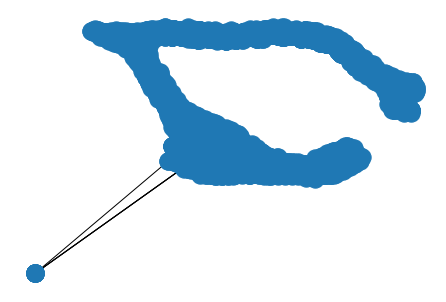

In [57]:
# This the new version (5/18) of the method to find the centerline points
# The total number of iterations
moved_count = []
for iteration in range(3):
    H_ini = 17
    H_delta = 5
    H_glo = 0
    trial_limit = 10
    min_neighbors = 60 + iteration * 25
    max_neighbors = 850
    curMoved = 0
  
    # We will move all the points for each iteration
    for targetPoint in range(len(pointsCor3D_base)):
        H_glo = H_ini
        trial = 0
        neighborsCor = []
        
        while(len(neighborsCor) < min_neighbors and trial < trial_limit and not len(neighborsCor) > max_neighbors):
            neighborsCor = collectPointsLite(targetPoint, H_glo, 2*H_glo)
            H_glo += H_delta
            trial += 1
            
        if(trial < trial_limit):
            moveVec = getMoveVec(pointsCor3D_base[targetPoint], neighborsCor)   
            print(targetPoint, "trial:",trial,len(neighborsCor))
            print(moveVec)
            vecLen = np.linalg.norm(moveVec);

            if(vecLen > H_glo/5):
                pointsCor3D_moved[targetPoint] = moveVec.tolist() + pointsCor3D_base[targetPoint]
                print("Moved!", vecLen, ">", H_glo/5)
                curMoved += 1
                
            else:
                print("Not Moved!", vecLen, "<", H_glo/5)
        else:
            print("Overflow!")
    
    curNeighborDis = 20
    first_flag = True
    
    while (first_flag or not nx.is_connected(graph_base)):
    
        if(first_flag):
            first_flag = False
            
        (graph_base, pointsCor3D_moved) = getMSTFromDataPoint(pointsCor3D_moved, drawMST=True, sampleNumber=len(pointsCor3D_base), maxNeighborDis=curNeighborDis)
        curNeighborDis *= 2 
        
    pointsCor3D_base = copy.deepcopy(pointsCor3D_moved)
    displayPoints(pointsCor3D_moved, 0.5)
    moved_count.append(curMoved)
print(moved_count)


In [ ]:
displayPoints(pointsCor3D_moved, 0.5)    

In [ ]:
# the code to move points toward the centerline 
points_centerline = []

# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 40
    H_delta = 5
    H_glo = 0
    trial_limit = 18
    min_neighbors = 100
    max_neighbors = 850
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points that has been moved
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(3000, 4000):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1, 1]
        # The next two lines are used in a dynamic programming version of computing the centerline
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
        
            
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        
        if(distance.euclidean(newCor3D, pointsCor3D[targetPoint]) < 80):
            pointsCor3D[targetPoint] = list(newCor3D)
            dirty_dict[targetPoint] = 1
            points_centerline.append(newCor3D)
            

        
    displayPoints(points_centerline, 0.5)    

In [58]:
# Construct a MST only using the 750 points modified above
#(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(pointsCor3D_base, drawMST=True, sampleNumber=len(pointsCor3D_base), maxNeighborDis=80)

graph_centerline = graph_base
pointsCor3D_centerline = pointsCor3D_moved

if(not nx.is_connected(graph_centerline)):
    raise Exception('the raw centerline points cannot form a connected MST, raise maxNeighborDis and try again!')


# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        toRemove = []
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")

# Displat the points on the centerline

to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)

# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

MST has 7000 nodes. Now begin to trim the graph.
Done! Trimed 6357 nodes. Now MST has 643 nodes left.
Now begin reconstruct endpoints
Done! Now MST has 817 nodes left.


In [59]:
displayPoints(to_display, 1.3)

In [ ]:
pointsCorInorder = []
for point, index in zip(pointsInorder, range(len(pointsInorder))):
    pointsCorInorder.append([pointsCor3D_centerline[point], index])

samplePointsCorInorder = np.asarray(sample(pointsCorInorder, int(len(pointsCorInorder)/2)))
samplePointsCorInorder = sorted(samplePointsCorInorder, key=lambda x:x[1])
samplePointsCorInorder = [x[0] for x in samplePointsCorInorder]
                        
displayPoints(samplePointsCorInorder, 1.3)

In [ ]:
np.savetxt("6_3_1_centerpoints_2016.csv", samplePointsCorInorder, delimiter=" ")
np.save("6_3_1_centerpoints_2016", samplePointsCorInorder)